# Union Hill Enslaved Data Preparation

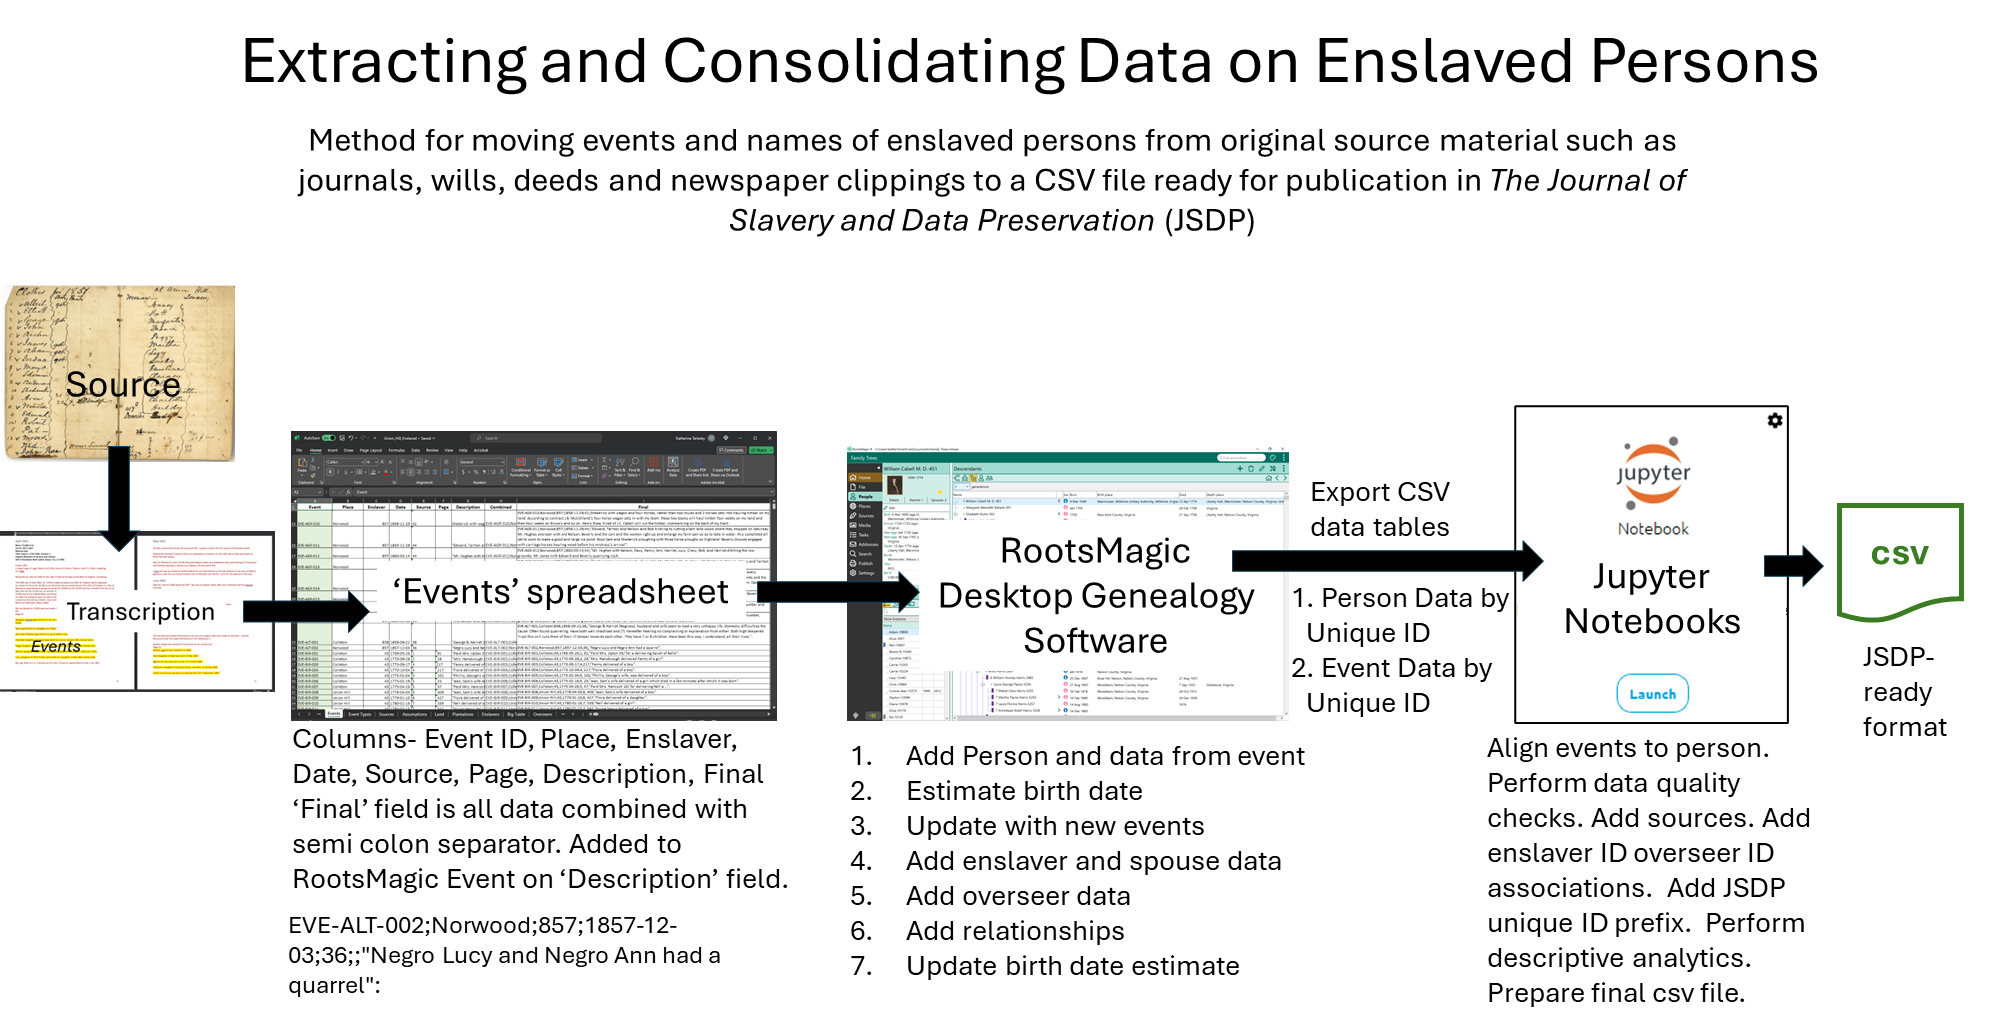

In [2]:
from IPython import display
display.Image(filename="Methodology.png", width=1000, height=1000)

In [3]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import seaborn as sns

# Matplotlib and associated plotting modules
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import rcParams
import matplotlib.animation as animation
from matplotlib.patches import Rectangle
import matplotlib.ticker as ticker

import missingno as msno

#import datetime module
import datetime

print('Libraries imported.')

Libraries imported.


## Common Functions

In [5]:
#Trim whitespace from ends of each value across all series in dataframe
def trim_all_columns(df):
    trim_strings = lambda x: x.strip() if isinstance(x, str) else x
    return df.map(trim_strings)

## Overview of Steps in this Notebook

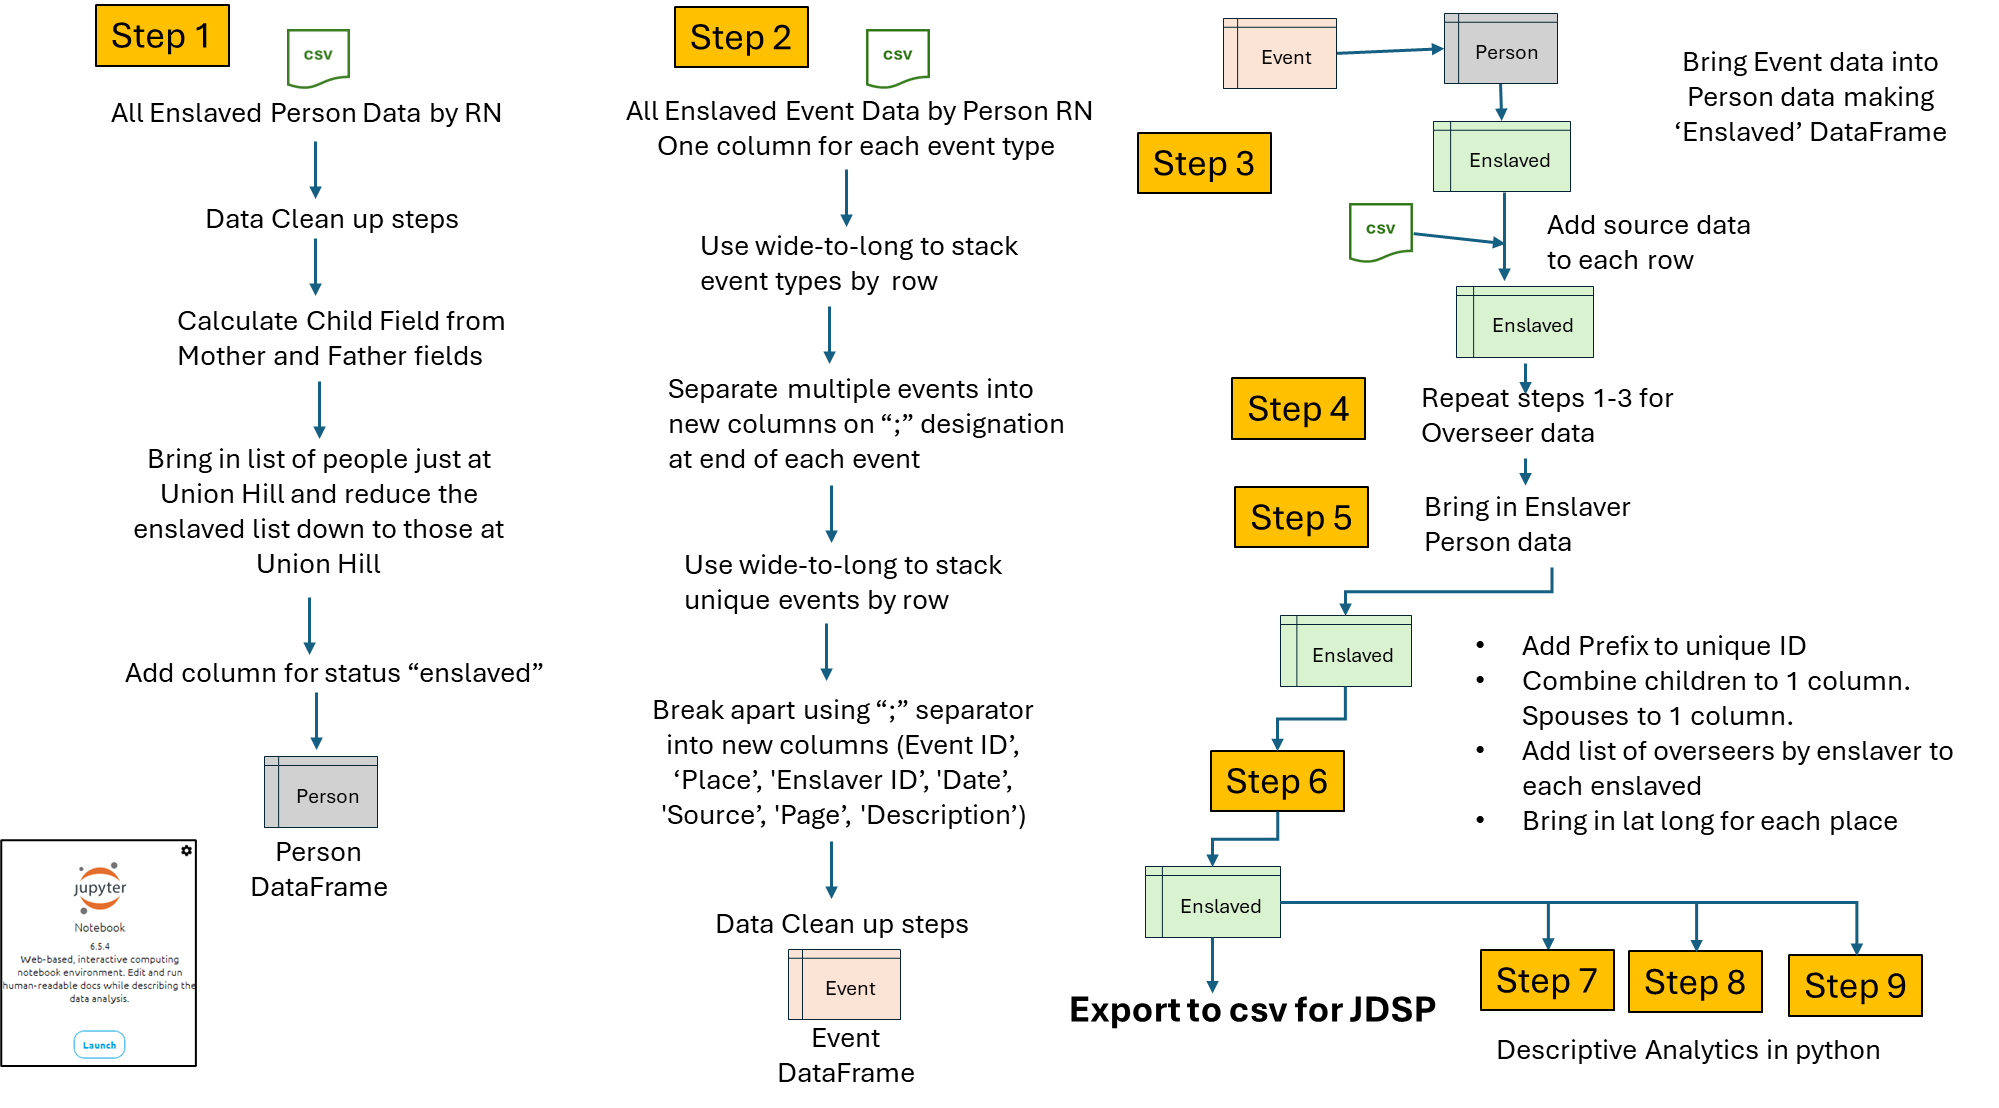

In [7]:
display.Image(filename="PythonSteps.png", width=1000, height=1000)

# STEP 1

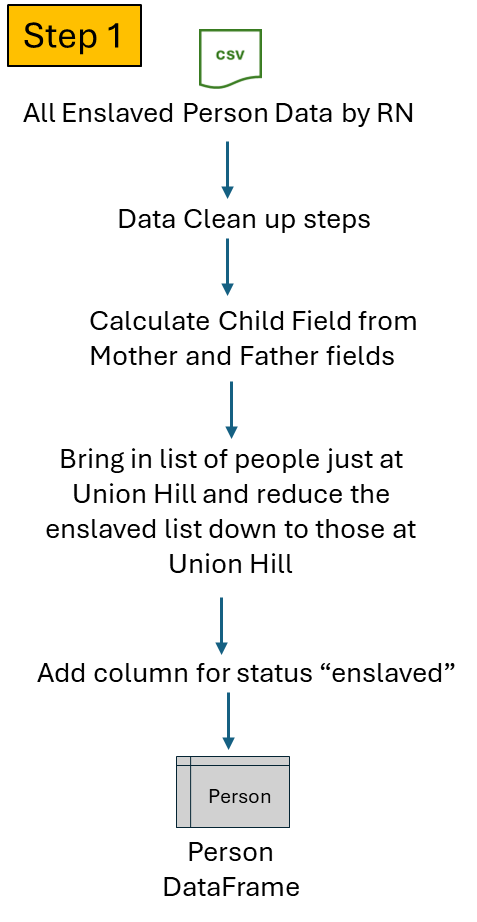

In [9]:
display.Image(filename="FirstStep.png", width=250, height=400)

## Bring in File of Enslaved Person Data from RootsMagic

In [11]:
#import the Masterfile CSV to work with and a column for "order"
file = "EnslavedPersonData_06242024.csv"
person = pd.read_csv(file)
person = trim_all_columns(person)
person = person.rename(columns={'Nickname':'Alternate Name'})
person = person.replace(to_replace='[Unknown] [Unknown]-0', value=np.NaN)

print(person.shape)
person.head()

(707, 10)


RN Given Name Alternate Name Surname Sex Birthdate Deathdate Father  \
0   708       Abby            NaN     NaN   F  abt 1793       NaN    NaN   
1   639       Abel            NaN     NaN   M  bef 1773       NaN    NaN   
2   199    Abraham            NaN     NaN   M      1796       NaN    NaN   
3   620    Abraham            NaN     NaN   M  abt 1797       NaN    NaN   
4  1035    Abraham            NaN     NaN   M  bef 1798       NaN    NaN   

                         Mother Spouse  
0                           NaN    NaN  
1                           NaN    NaN  
2                      Lett -86    NaN  
3  Cate "Creasy's daughter" -78    NaN  
4                  Esther -1037    NaN

### Data Clean Up Steps- Remove names from Spouse and Parents - just Keep RN

In [13]:
person[['Spouse','Mother','Father']] = person[['Spouse','Mother','Father']].replace(regex=[r'\D+'], value="")
person = person.sort_values('Mother')
person.head(10)

RN Given Name Alternate Name   Surname Sex    Birthdate Deathdate  \
189    97     George            NaN       NaN   M     bef 1762       NaN   
294   121     Joshua            NaN       NaN   M     bef 1765       NaN   
563   102    Unknown   Molly's girl       NaN   F  29 Dec 1795       NaN   
453   941    Rebecca            NaN       NaN   F     bef 1856       NaN   
672  1338     George            NaN  Jemmeson   M         1862       NaN   
669  1335  Charlotte            NaN  Jemmeson   F         1863       NaN   
670  1337     Elijah            NaN  Jemmeson   M         1859       NaN   
673  1336     Mariah            NaN  Jemmeson   F     abt 1856       NaN   
4    1035    Abraham            NaN       NaN   M     bef 1798       NaN   
603  1073  Charlotte            NaN     Banks   F         1836       NaN   

    Father Mother Spouse  
189     14      1    615  
294     14      1    NaN  
563    NaN    101    NaN  
453    297   1026    NaN  
672    663   1032    NaN  
669    663   1032    NaN  
670    663   1032    NaN  
673    663   1032    NaN  
4      NaN   1037    NaN  
603   1065   1067    NaN

### Convert Birth and Death dates to format-YY-MM-DD and add Birth year for analytics

##### Make a dictionary of months by name and number

In [16]:
month = {"Jan": 1, 'Feb':2,'Mar':3,'Apr':4,'May':5,'Jun':6,'Jul':7,'Aug':8,'Sep':9,'Oct':10,'Nov':11,'Dec':12}

In [17]:
hold =person[['RN','Birthdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Birthdate'].str.split(pat=' ', expand=True).fillna(np.NaN)
hold.head()

0     1     2
RN                 
1   bef  1745   NaN
2   bef  1766   NaN
3    25   Sep  1780
4   bef  1761   NaN
5   abt  1760   NaN

In [18]:
#replace mnth names with numbers in column 1
hold = hold.replace({1: month})
#reorder columns
hold= hold[[2,1,0]]
#add 'Birthyear' column for analytics later
hold['Birthyear'] = hold[2]
#move over Year value from columns that contain the year value
hold['Birthyear'] = hold['Birthyear'].fillna(hold[1])
hold['Birthyear'] = hold['Birthyear'].fillna(hold[0])
hold.head()

2     1    0 Birthyear
RN                           
1    NaN  1745  bef      1745
2    NaN  1766  bef      1766
3   1780     9   25      1780
4    NaN  1761  bef      1761
5    NaN  1760  abt      1760

In [19]:
BYhold = hold[['Birthyear']]
#drop rows with no birth year
hold=hold.dropna(subset=2)
#convert numbers to string for concatenation into date format
hold = hold.astype(str)
#Create new column for correct format birthdate
hold['Birth date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Birthyear'})
hold.head()

Birth date
RN           
3   1780-9-25
15   1724-1-1
53  1769-5-26
56  1770-9-28
57  1773-9-17

#### Merge back into person dataframe

In [21]:
person=person.sort_values('RN').set_index('RN')
person = person.join(hold)

person['Birth date'] = person['Birth date'].fillna(person['Birthdate'])
person = person.join(BYhold).drop(columns={'Birthdate'})

person['Birthyear'] = person['Birthyear'].astype(int)
person=person.reset_index()
print(person.shape)
person.head()

(707, 11)


RN Given Name Alternate Name Surname Sex Deathdate Father Mother Spouse  \
0   1      Venus            NaN     NaN   F       NaN    NaN    NaN     14   
1   2     Hannah            NaN     NaN   F       NaN    NaN    NaN    NaN   
2   3      Phill            NaN     NaN   M       NaN    NaN      2    NaN   
3   4   Greenock            NaN     NaN   M       NaN    NaN    NaN    NaN   
4   5      Mingo            NaN     NaN   M       NaN    NaN    NaN    NaN   

  Birth date  Birthyear  
0   bef 1745       1745  
1   bef 1766       1766  
2  1780-9-25       1780  
3   bef 1761       1761  
4   abt 1760       1760

### Clean up Death Dates using same method

In [23]:
hold =person[['RN','Deathdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Deathdate'].str.split(pat=' ', expand=True).fillna(np.NaN)

hold=hold.dropna(subset=2)
print(hold.shape)
hold.head()

(32, 3)


0    1     2
RN               
6    3  Aug  1773
14  20  Sep  1795
15  28  Sep  1784
18   7  May  1789
26  21  Jan  1790

In [24]:
hold = hold.replace({1: month})
hold= hold[[2,1,0]]
#move over Year value from columns that contain the year value
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])

DYhold = hold[['Deathyear']]
hold = hold.astype(str)
hold['Death date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Deathyear'})
print(hold.shape)
hold.head()

(32, 1)


Death date
RN           
6    1773-8-3
14  1795-9-20
15  1784-9-28
18   1789-5-7
26  1790-1-21

In [25]:
person=person.sort_values('RN').set_index('RN')
person = person.join(hold)
person['Death date'] = person['Death date'].fillna(person['Deathdate'])
person = person.join(DYhold)
person = person.drop(columns={'Deathdate'})
person=person.reset_index()
print(person.shape)
person.head()

(707, 12)


RN Given Name Alternate Name Surname Sex Father Mother Spouse Birth date  \
0   1      Venus            NaN     NaN   F    NaN    NaN     14   bef 1745   
1   2     Hannah            NaN     NaN   F    NaN    NaN    NaN   bef 1766   
2   3      Phill            NaN     NaN   M    NaN      2    NaN  1780-9-25   
3   4   Greenock            NaN     NaN   M    NaN    NaN    NaN   bef 1761   
4   5      Mingo            NaN     NaN   M    NaN    NaN    NaN   abt 1760   

   Birthyear Death date Deathyear  
0       1745        NaN       NaN  
1       1766        NaN       NaN  
2       1780        NaN       NaN  
3       1761        NaN       NaN  
4       1760        NaN       NaN

### Add columns for children of each person based on data from 'Mother' and 'Father' fields

In [27]:
#create dataframe of Mothers
df = person[['Mother','RN']]
df = df.dropna().sort_values(['Mother','RN'])
df= df.astype(int)
print(df.shape)
df.head()

(215, 2)


Mother    RN
81        1    97
98        1   121
86      101   102
492    1026   941
702    1032  1335

### Move all children into row with Mother RN

In [29]:
#determine the number of children for each mother
df['count'] = df.groupby('Mother').cumcount()
df = df.sort_values(['Mother','count'])
#pivot the dataframe to create a column for each child
df = df.pivot(index=['Mother'], columns='count', values='RN').reset_index()
df =df.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Mother':'RN'})
df.head()

count  RN  Child1  Child2  Child3  Child4  Child5  Child6  Child7  Child8  \
0       1    97.0   121.0     NaN     NaN     NaN     NaN     NaN     NaN   
1       2     3.0    98.0   617.0   618.0  1240.0     NaN     NaN     NaN   
2      19    36.0    56.0    57.0     NaN     NaN     NaN     NaN     NaN   
3      20    41.0    85.0     NaN     NaN     NaN     NaN     NaN     NaN   
4      22    58.0    66.0    77.0    84.0     NaN     NaN     NaN     NaN   

count  Child9  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

### Repeat for Father and children

In [31]:
#create dataframe of Fathers
dff = person[['Father','RN']]
dff = dff.dropna().sort_values(['Father','RN'])
dff= dff.astype(int)
print(dff.shape)
dff = dff[dff['Father']!=0]
print(dff.shape)
dff['count'] = dff.groupby('Father').cumcount()
dff = dff.sort_values(['Father','count'])
dff = dff.pivot(index=['Father'], columns='count', values='RN').reset_index()
dff =dff.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Father':'RN'})
dff.head()

(115, 2)
(115, 2)


count  RN  Child1  Child2  Child3  Child4  Child5  Child6  Child7  Child8  \
0       8    36.0    56.0    57.0     NaN     NaN     NaN     NaN     NaN   
1      14    97.0   121.0     NaN     NaN     NaN     NaN     NaN     NaN   
2      25    35.0    60.0    80.0     NaN     NaN     NaN     NaN     NaN   
3      37    39.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      62    65.0    79.0     NaN     NaN     NaN     NaN     NaN     NaN   

count  Child9  
0         NaN  
1         NaN  
2         NaN  
3         NaN  
4         NaN

### Concatenate Join Mother and Father together

In [33]:
children = pd.concat([df,dff]).sort_values('RN').set_index('RN')
print(children.shape)
children.head()

(129, 9)


count  Child1  Child2  Child3  Child4  Child5  Child6  Child7  Child8  Child9
RN                                                                           
1        97.0   121.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
2         3.0    98.0   617.0   618.0  1240.0     NaN     NaN     NaN     NaN
8        36.0    56.0    57.0     NaN     NaN     NaN     NaN     NaN     NaN
14       97.0   121.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
19       36.0    56.0    57.0     NaN     NaN     NaN     NaN     NaN     NaN

### Rejoin Children data to person Dataframe

In [35]:
person = person.sort_values('RN').set_index('RN')
person = person.join(children).reset_index()

person['Status'] = 'Enslaved'
print(person.shape)
person.head()

(707, 22)


RN Given Name Alternate Name Surname Sex Father Mother Spouse Birth date  \
0   1      Venus            NaN     NaN   F    NaN    NaN     14   bef 1745   
1   2     Hannah            NaN     NaN   F    NaN    NaN    NaN   bef 1766   
2   3      Phill            NaN     NaN   M    NaN      2    NaN  1780-9-25   
3   4   Greenock            NaN     NaN   M    NaN    NaN    NaN   bef 1761   
4   5      Mingo            NaN     NaN   M    NaN    NaN    NaN   abt 1760   

   Birthyear Death date Deathyear  Child1  Child2  Child3  Child4  Child5  \
0       1745        NaN       NaN    97.0   121.0     NaN     NaN     NaN   
1       1766        NaN       NaN     3.0    98.0   617.0   618.0  1240.0   
2       1780        NaN       NaN     NaN     NaN     NaN     NaN     NaN   
3       1761        NaN       NaN     NaN     NaN     NaN     NaN     NaN   
4       1760        NaN       NaN     NaN     NaN     NaN     NaN     NaN   

   Child6  Child7  Child8  Child9    Status  
0     NaN     NaN     NaN     NaN  Enslaved  
1     NaN     NaN     NaN     NaN  Enslaved  
2     NaN     NaN     NaN     NaN  Enslaved  
3     NaN     NaN     NaN     NaN  Enslaved  
4     NaN     NaN     NaN     NaN  Enslaved

### Insert column for 'Spouse2' to help concatenate step later on

In [37]:
person.loc[:, "Spouse2"] = np.NaN

In [38]:
person[person['RN']==191]

RN Given Name Alternate Name Surname Sex Father Mother Spouse  \
154  191      Sucky            NaN     NaN   F    NaN    NaN    792   

    Birth date  Birthyear Death date Deathyear  Child1  Child2  Child3  \
154   bef 1789       1789  1859-5-14      1859   751.0   793.0   836.0   

     Child4  Child5  Child6  Child7  Child8  Child9    Status  Spouse2  
154   852.0   881.0     NaN     NaN     NaN     NaN  Enslaved      NaN

# STEP 2

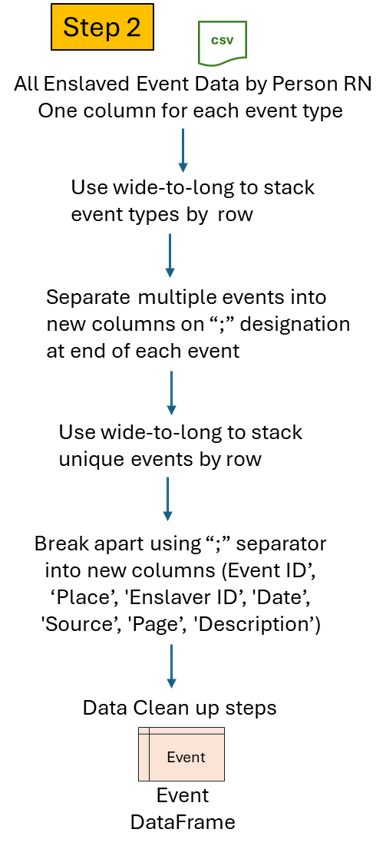

In [40]:
display.Image(filename="SecondStep.png", width=250, height=400)

## Bring in Enslaved Event Data

### REMOVE QUOTATION MARKS FROM EXCEL BEFORE IMPORTING

In [43]:
file = "EnslavedEventData_06242024.csv"
events = pd.read_csv(file)
events = trim_all_columns(events)

print(events.shape)
events.head()

(707, 31)


RN EVE-BIR EVE-DEA                                            EVE-TRF  \
0   708     NaN     NaN                                                NaN   
1   639     NaN     NaN                                                NaN   
2   199     NaN     NaN                                                NaN   
3   620     NaN     NaN                                                NaN   
4  1035     NaN     NaN  EVE-TFR-031;Union Hill;44;1816;13;418;Changes ...   

  EVE-CRM EVE-DIS                                            EVE-CRT EVE-PRO  \
0     NaN     NaN                                                NaN     NaN   
1     NaN     NaN                                                NaN     NaN   
2     NaN     NaN                                                NaN     NaN   
3     NaN     NaN  EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...     NaN   
4     NaN     NaN                                                NaN     NaN   

  EVE-NEC                                            EVE-ENS EVE-MED EVE-RES  \
0     NaN  EVE-ENS-008;Soldier's Joy;272;1818;;;Enslaved ...     NaN     NaN   
1     NaN  EVE-ENS-008;Soldier's Joy;272;1818;;;Enslaved ...     NaN     NaN   
2     NaN  EVE-ENS-001;Colleton;43;1798;;;Enslaved by Wil...     NaN     NaN   
3     NaN  EVE-ENS-011;Montezuma;271;1807;;;Enslaved by H...     NaN     NaN   
4     NaN  EVE-ENS-005;Union Hill;44;1810;;;Enslaved by W...     NaN     NaN   

  EVE-HIR EVE-LAB EVE-DOM EVE-TRV  \
0     NaN     NaN     NaN     NaN   
1     NaN     NaN     NaN     NaN   
2     NaN     NaN     NaN     NaN   
3     NaN     NaN     NaN     NaN   
4     NaN     NaN     NaN     NaN   

                                             EVE-ADV  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3  EVE-AUC-003;Montezuma;271;1807-12-31;65;;Adver...   
4                                                NaN   

                                             EVE-TAX  \
0                                                NaN   
1                                                NaN   
2                                                NaN   
3                                                NaN   
4  EVE-TAX-007;Union Hill;44;1810;14;;Date Estima...   

                                            EVE-WILL EVE-CRF EVE-RET EVE-OVR  \
0  EVE-PRO-019;Soldier's Joy;1065;1823-11-24;21;1...     NaN     NaN     NaN   
1  EVE-PRO-018;Soldier's Joy;1065;1823-11-24;21;1...     NaN     NaN     NaN   
2  EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...     NaN     NaN     NaN   
3  EVE-PRO-016;Montezuma;271;1807-02-26;19;444;Ag...     NaN     NaN     NaN   
4                                                NaN     NaN     NaN     NaN   

  EVE-PUN EVE-MIL EVE-ALT EVE-AGR EVE-EMN EVE-CEN EVE-CEM EVE-ILL EVE-MAR  
0     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
1     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
2     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
3     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN  
4     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN     NaN

### Use wide-to-long to get the events stacked

In [45]:
events = pd.wide_to_long(events, stubnames='EVE',i='RN', j='type',sep='-', suffix= '\D+')#text suffixes
events= events.reset_index().drop(columns={'type'}).sort_values('RN').set_index('RN').dropna()
events = trim_all_columns(events)

print(events.shape)
events.head()

(2373, 1)


EVE
RN                                                   
1   EVE-ENS-001;Colleton;43;1770-09-22;2; 27;Ensla...
1   EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1   EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
2   EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...
2   EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...

### Remove the last ":" colon in each event row - THIS STEP IS CRITICAL

In [47]:
events['EVE'] = events['EVE'].str[:-1]
print(events.shape)
events.head(10)

(2373, 1)


EVE
RN                                                   
1   EVE-ENS-001;Colleton;43;1770-09-22;2; 27;Ensla...
1   EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
1   EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
2   EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...
2   EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...
2   EVE-AUC-003;Montezuma;271;1807-12-31;65;;Adver...
2   EVE-ENS-001;Union Hill;43;1780-09-25;7;360;Ens...
2   EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
2   EVE-PRO-016;Montezuma;271;1807-02-26;19;444;Ag...
3   EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...

### Sort rows by RN and use new index as unique identifier

In [49]:
events = events.reset_index().reset_index().rename(columns={'index':'Order'}).set_index(['Order','RN'])
events.head()

EVE
Order RN                                                   
0     1   EVE-ENS-001;Colleton;43;1770-09-22;2; 27;Ensla...
1     1   EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...
2     1   EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...
3     2   EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...
4     2   EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...

### Now use String Split to separate out multiple events on ":" colon

In [51]:
events =events['EVE'].str.split(pat=':', expand=True).fillna(np.NaN)
events= events.rename(columns={0:'EVE-A',1:'EVE-B',2:'EVE-C',3:'EVE-D',4:'EVE-D',5:'EVE-E',6:'EVE-F',7:'EVE-G',8:'EVE-H',9:'EVE-I',10:'EVE-J',11:'EVE-K',12:'EVE-L',13:'EVE-M',14:'EVE-N',15:'EVE-O',16:'EVE-P',17:'EVE-Q',18:'EVE-R',19:'EVE-S',20:'EVE-T'})
events = events.reset_index()
events = trim_all_columns(events)
print(events.shape)
events.head()

(2373, 21)


Order  RN                                              EVE-A  \
0      0   1  EVE-ENS-001;Colleton;43;1770-09-22;2; 27;Ensla...   
1      1   1  EVE-NEC-002;Colleton;43;1770-09-22;2; 27;Blank...   
2      2   1  EVE-BIR-013;Union Hill;43;1780-09-25;7; 360;Th...   
3      3   2  EVE-CRT-005;Montezuma;271;1805-05-17;68;;Hecto...   
4      4   2  EVE-PRO-001;Union Hill;43;1800-01-01;14;;Negro...   

                                               EVE-B  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-017;Union Hill;43;1783-11-05;8; 37;Cre...   
3                                                NaN   
4  EVE-PRO-004;Union Hill;43;1800-01-02;14;;List ...   

                                               EVE-C  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-020;Union Hill;43;1785-08-14;8; 89;Sam...   
3                                                NaN   
4                                                NaN   

                                               EVE-D  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-021;Union Hill;43;1785-09-22;8; 91;You...   
3                                                NaN   
4                                                NaN   

                                               EVE-D  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-026;Union Hill;43;1787-03-03;8; 139;Lu...   
3                                                NaN   
4                                                NaN   

                                               EVE-E  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-033;Union Hill;43;1795-07-25;8;303;Han...   
3                                                NaN   
4                                                NaN   

                                               EVE-F  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-022;Union Hill;43;1785-10-22;8; 93;Flo...   
3                                                NaN   
4                                                NaN   

                                               EVE-G  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-023;Union Hill;43;1786-01-08;8; 99;Nan...   
3                                                NaN   
4                                                NaN   

                                               EVE-H  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-024;Union Hill;43;1786-05-17;8; 115;Le...   
3                                                NaN   
4                                                NaN   

                                               EVE-I  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-030;Union Hill;43;1788-01-25;8;154;Tin...   
3                                                NaN   
4                                                NaN   

                                               EVE-J  \
0                                                NaN   
1                                                NaN   
2  EVE-BIR-034;Union Hill;43;1795-08-07;8;304;You...   
3                                                NaN   
4                                                NaN   

                                               EVE-K EVE-L EVE-M EVE-N EVE-O  \
0                                                NaN   NaN   NaN   NaN   NaN   
1                                                NaN   NaN   NaN   NaN

### And stack again using wide-to-long

In [53]:
events = pd.wide_to_long(events, stubnames='EVE',i=['Order','RN'], j='type',sep='-', suffix= '\D+')#text suffixes
events= events.reset_index().drop(columns={'type','Order'}).drop_duplicates().dropna().sort_values('RN').set_index('RN')
print(events.shape)
events.head(10)

(3879, 1)


EVE
RN                                                   
1   EVE-ENS-001;Colleton;43;1770-09-22;2; 27;Ensla...
1   EVE-BIR-035;Union Hill;43;1795-12-29;8;310;Mol...
1   EVE-BIR-034;Union Hill;43;1795-08-07;8;304;You...
1   EVE-BIR-030;Union Hill;43;1788-01-25;8;154;Tin...
1   EVE-BIR-024;Union Hill;43;1786-05-17;8; 115;Le...
1   EVE-BIR-023;Union Hill;43;1786-01-08;8; 99;Nan...
1   EVE-BIR-033;Union Hill;43;1795-07-25;8;303;Han...
1   EVE-BIR-022;Union Hill;43;1785-10-22;8; 93;Flo...
1   EVE-BIR-021;Union Hill;43;1785-09-22;8; 91;You...
1   EVE-BIR-020;Union Hill;43;1785-08-14;8; 89;Sam...

### Now break out to columns for each event using the existing semicolon separator

In [55]:
events =events['EVE'].str.split(pat=';', expand=True)
events = events.rename(columns={0:'Event ID',1:'Place',2:'Enslaver ID',3:'Date',4:'Source',5:'Page',6:'Description'})
events.head()

Event ID       Place Enslaver ID        Date Source  Page  \
RN                                                                 
1   EVE-ENS-001    Colleton          43  1770-09-22      2    27   
1   EVE-BIR-035  Union Hill          43  1795-12-29      8   310   
1   EVE-BIR-034  Union Hill          43  1795-08-07      8   304   
1   EVE-BIR-030  Union Hill          43  1788-01-25      8   154   
1   EVE-BIR-024  Union Hill          43  1786-05-17      8   115   

                                          Description  
RN                                                     
1                     Enslaved by William Cabell, Sr.  
1             Molly delivered of a girl by old Venus.  
1   Young Isbel delivered of a boy by old Venus an...  
1              Tinor delivered of a girl by old Venus  
1                Lett delivered of a boy by Old Venus

In [56]:
events['Source'] = events['Source'].replace(to_replace='', value=0)
events['Source'].value_counts().tail()

Source
34    2
3     1
22    1
54    1
60    1
Name: count, dtype: int64

### Data Clean-up

In [58]:
events['Place'].value_counts()

Place
Union Hill                               1654
Soldier's Joy                             623
Colleton                                  458
Montezuma                                 374
Norwood                                   266
Glenmore                                  109
Unknown                                   108
Benvenue                                   79
Lovingston, Nelson, Virginia               37
Rose Hill                                  30
New Glasgow, Amherst County, Virginia      20
Philadelphia, Pennsylvania                 15
Mountain View, Clifford, Amherst           12
Richmond, Virginia                         11
Oak Ridge                                   9
Amherst                                     8
Buckingham County, Virginia                 5
Liberty Hall                                5
Rock Cliff                                  5
Williamsburg, Virginia                      4
Hanover, Virginia                           3
Halifax County, Virginia    

### Add column for Event type

In [60]:
events['Event Type'] = events['Event ID'].str[:-4]
events['Event Type'] = events['Event Type'].replace(to_replace='EVE-NEC', value='Necessities').replace(to_replace='EVE-DEA', value='Death').replace(to_replace='EVE-CRM', value='Crime')\
                                           .replace(to_replace='EVE-BIR', value='Birth').replace(to_replace='EVE-TRV', value='Travel').replace(to_replace='EVE-TFR', value='Transfer')\
                                           .replace(to_replace='EVE-LAB', value='Labor').replace(to_replace='EVE-DOM', value='Domestic').replace(to_replace='EVE-MED', value='Medical')\
                                           .replace(to_replace='EVE-AGR', value='Agriculture').replace(to_replace='EVE-TAX', value='Tax').replace(to_replace='EVE-MAR', value='Marriage')\
                                           .replace(to_replace='EVE-CFT', value='Craft').replace(to_replace='EVE-WILL', value='Will').replace(to_replace='EVE-RES', value='Residence')\
                                           .replace(to_replace='EVE-DIS', value='Disappeared').replace(to_replace='EVE-HIR', value='Hiring').replace(to_replace='EVE-PRO', value='Probate')\
                                           .replace(to_replace='EVE-ADV', value='Advertisement').replace(to_replace='EVE-PUN', value='Punishment').replace(to_replace='EVE-ALT', value='Altercation')\
                                           .replace(to_replace='EVE-MIL', value='Military').replace(to_replace='EVE-RET', value='Returned').replace(to_replace='EVE-OVR', value='Overseer Contract')\
                                           .replace(to_replace='EVE-EMP', value='Employed').replace(to_replace='EVE-ILL', value='Illness').replace(to_replace='EVE-CEN', value='Census')\
                                           .replace(to_replace='EVE-CEM', value='Cemetery').replace(to_replace='EVE-EMN', value='Emancipation').replace(to_replace='EVE-CRT', value='Court')\
                                           .replace(to_replace='EVE-REL', value='Relocation').replace(to_replace='EVE-ENS', value='Enslaved').replace(to_replace='EVE-AUC', value='Auction')
events.head()

Event ID       Place Enslaver ID        Date Source  Page  \
RN                                                                 
1   EVE-ENS-001    Colleton          43  1770-09-22      2    27   
1   EVE-BIR-035  Union Hill          43  1795-12-29      8   310   
1   EVE-BIR-034  Union Hill          43  1795-08-07      8   304   
1   EVE-BIR-030  Union Hill          43  1788-01-25      8   154   
1   EVE-BIR-024  Union Hill          43  1786-05-17      8   115   

                                          Description Event Type  
RN                                                                
1                     Enslaved by William Cabell, Sr.   Enslaved  
1             Molly delivered of a girl by old Venus.      Birth  
1   Young Isbel delivered of a boy by old Venus an...      Birth  
1              Tinor delivered of a girl by old Venus      Birth  
1                Lett delivered of a boy by Old Venus      Birth

### Add a column for 'Role' for each event type

In [62]:
events['Role'] = events['Event Type']
events['Role'] = events['Role'].replace(to_replace='Advertisement', value='Runaway').replace(to_replace='Auction', value='Auctioned person').replace(to_replace='Agriculture', value='Laborer').replace(to_replace='Death', value='Deceased Person')\
                                           .replace(to_replace='Travel', value='Traveller').replace(to_replace='Transfer', value='Transferred Person').replace(to_replace='Birth', value='Mother')\
                                           .replace(to_replace='Labor', value='Laborer').replace(to_replace='Domestic', value='Domestic laborer').replace(to_replace='Medical', value='Patient')\
                                           .replace(to_replace='Agriculture', value='Agriculture laborer').replace(to_replace='Tax', value='Tithable enslaved person').replace(to_replace='Marriage', value='Spouse')\
                                           .replace(to_replace='Craft', value='Craftsperson').replace(to_replace='Will', value='Listed Person').replace(to_replace='Residence', value='Resident')\
                                           .replace(to_replace='Disappeared', value='Missing Person').replace(to_replace='Hiring', value='Laborer').replace(to_replace='Probate', value='Listed Person')\
                                           .replace(to_replace='Necessities', value='Recipient').replace(to_replace='Punishment', value='Punished person').replace(to_replace='Altercation', value='Participant')\
                                           .replace(to_replace='Military', value='Enslaved travelling companion').replace(to_replace='Returned', value='Returned Person').replace(to_replace='Overseer Contract', value='Laborer')\
                                           .replace(to_replace='Employed', value='Laborer').replace(to_replace='Illness', value='Patient').replace(to_replace='Census', value='Resident')\
                                           .replace(to_replace='Cemetery', value='Deceased Person').replace(to_replace='Emancipation', value='Freed Person').replace(to_replace='Court', value='Listed Person')\
                                           .replace(to_replace='Relocation', value='Relocated Person').replace(to_replace='Enslaved', value='Enslaved Person')
                                          
events.head()


Event ID       Place Enslaver ID        Date Source  Page  \
RN                                                                 
1   EVE-ENS-001    Colleton          43  1770-09-22      2    27   
1   EVE-BIR-035  Union Hill          43  1795-12-29      8   310   
1   EVE-BIR-034  Union Hill          43  1795-08-07      8   304   
1   EVE-BIR-030  Union Hill          43  1788-01-25      8   154   
1   EVE-BIR-024  Union Hill          43  1786-05-17      8   115   

                                          Description Event Type  \
RN                                                                 
1                     Enslaved by William Cabell, Sr.   Enslaved   
1             Molly delivered of a girl by old Venus.      Birth   
1   Young Isbel delivered of a boy by old Venus an...      Birth   
1              Tinor delivered of a girl by old Venus      Birth   
1                Lett delivered of a boy by Old Venus      Birth   

               Role  
RN                   
1   Enslaved Person  
1            Mother  
1            Mother  
1            Mother  
1            Mother

#### Fix the Crime events based on the role of the enslaved person

In [64]:
events['Role'] = events['Role'].where(events['Event ID']!='EVE-CRM-001','Victim')
events['Role'] = events['Role'].where(events['Event ID']!='EVE-CRM-002','Witness')
events['Role'] = events['Role'].where(events['Event ID']!='EVE-CRM-003','Witness')
events['Role'] = events['Role'].where(events['Event ID']!='EVE-CRM-004','Perpetrator')

#### Fix the Medical events based on the role of the enslaved person

In [66]:
events= events.reset_index().sort_values('RN')

In [67]:
Caregivers=[792,931]
Midwives=[1,1204]
events['Role'] = events['Role'].where(~events['RN'].isin(Caregivers), events['Role'].replace(to_replace='Patient', value='Caregiver'))
events['Role'] = events['Role'].where(~events['RN'].isin(Midwives), events['Role'].replace(to_replace='Mother', value='Midwife'))

events['Role'].value_counts()

Role
Enslaved Person                  1322
Listed Person                     654
Resident                          430
Recipient                         358
Laborer                           220
Transferred Person                208
Tithable enslaved person          206
Mother                            139
Auctioned person                   81
Traveller                          62
Patient                            39
Spouse                             36
Deceased Person                    32
Punished person                    14
Midwife                            12
Craftsperson                       10
Relocated Person                    9
Freed Person                        9
Missing Person                      7
Domestic laborer                    7
Runaway                             5
Participant                         4
Caregiver                           4
Returned Person                     3
Enslaved travelling companion       3
Witness                             2
Victim 

In [68]:
#Check for duplicate events under a person
test = events.groupby('RN')['Event ID'].value_counts().to_frame().reset_index().sort_values('count', ascending=False)
test.head(10)

RN     Event ID  count
2915  913  EVE-ENS-045      2
0       1  EVE-BIR-013      1
2590  842  EVE-HIR-001      1
2577  840  EVE-HIR-001      1
2578  840  EVE-HIR-003      1
2579  840  EVE-NEC-018      1
2580  841  EVE-ENS-006      1
2581  841  EVE-HIR-001      1
2582  841  EVE-HIR-003      1
2583  841  EVE-HIR-012      1

### Add Column for Year

In [70]:
events['Year'] = events['Date'].str[:4]
events['Year'] = events['Year'].astype(int)
events = events.sort_values('RN').set_index('RN')
events.head()

Event ID       Place Enslaver ID        Date Source Page  \
RN                                                                
1   EVE-ENS-001    Colleton          43  1770-09-22      2   27   
1   EVE-BIR-033  Union Hill          43  1795-07-25      8  303   
1   EVE-BIR-035  Union Hill          43  1795-12-29      8  310   
1   EVE-BIR-034  Union Hill          43  1795-08-07      8  304   
1   EVE-BIR-030  Union Hill          43  1788-01-25      8  154   

                                          Description Event Type  \
RN                                                                 
1                     Enslaved by William Cabell, Sr.   Enslaved   
1   Hannah wife of young George was delivered of a...      Birth   
1             Molly delivered of a girl by old Venus.      Birth   
1   Young Isbel delivered of a boy by old Venus an...      Birth   
1              Tinor delivered of a girl by old Venus      Birth   

               Role  Year  
RN                         
1   Enslaved Person  1770  
1           Midwife  1795  
1           Midwife  1795  
1           Midwife  1795  
1           Midwife  1788

## Join Enslaved Person and Event Data together into final `Enslaved` DataFrame

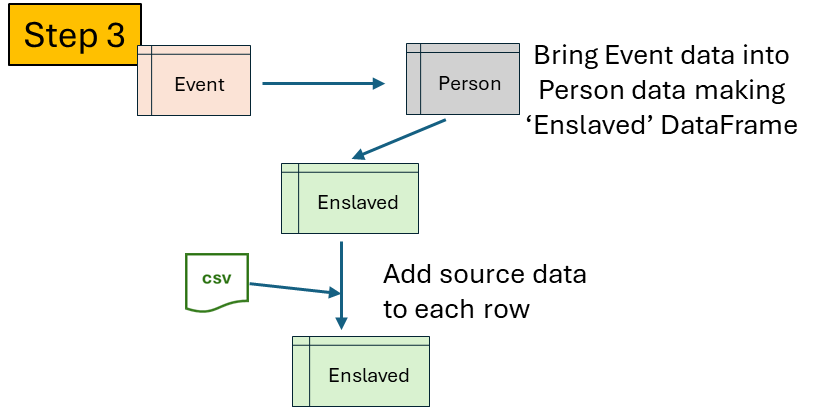

In [72]:
display.Image(filename="ThirdStep.png", width=700, height=700)

In [73]:
person = person.sort_values('RN').set_index('RN')
enslaved = person.join(events, how='left')
print(enslaved.shape)
enslaved.head()

(3880, 32)


Given Name Alternate Name Surname Sex Father Mother Spouse Birth date  \
RN                                                                         
1       Venus            NaN     NaN   F    NaN    NaN     14   bef 1745   
1       Venus            NaN     NaN   F    NaN    NaN     14   bef 1745   
1       Venus            NaN     NaN   F    NaN    NaN     14   bef 1745   
1       Venus            NaN     NaN   F    NaN    NaN     14   bef 1745   
1       Venus            NaN     NaN   F    NaN    NaN     14   bef 1745   

    Birthyear Death date Deathyear  Child1  Child2  Child3  Child4  Child5  \
RN                                                                           
1        1745        NaN       NaN    97.0   121.0     NaN     NaN     NaN   
1        1745        NaN       NaN    97.0   121.0     NaN     NaN     NaN   
1        1745        NaN       NaN    97.0   121.0     NaN     NaN     NaN   
1        1745        NaN       NaN    97.0   121.0     NaN     NaN     NaN   
1        1745        NaN       NaN    97.0   121.0     NaN     NaN     NaN   

    Child6  Child7  Child8  Child9    Status  Spouse2     Event ID  \
RN                                                                   
1      NaN     NaN     NaN     NaN  Enslaved      NaN  EVE-ENS-001   
1      NaN     NaN     NaN     NaN  Enslaved      NaN  EVE-BIR-033   
1      NaN     NaN     NaN     NaN  Enslaved      NaN  EVE-BIR-035   
1      NaN     NaN     NaN     NaN  Enslaved      NaN  EVE-BIR-034   
1      NaN     NaN     NaN     NaN  Enslaved      NaN  EVE-BIR-030   

         Place Enslaver ID        Date Source Page  \
RN                                                   
1     Colleton          43  1770-09-22      2   27   
1   Union Hill          43  1795-07-25      8  303   
1   Union Hill          43  1795-12-29      8  310   
1   Union Hill          43  1795-08-07      8  304   
1   Union Hill          43  1788-01-25      8  154   

                                          Description Event Type  \
RN                                                                 
1                     Enslaved by William Cabell, Sr.   Enslaved   
1   Hannah wife of young George was delivered of a...      Birth   
1             Molly delivered of a girl by old Venus.      Birth   
1   Young Isbel delivered of a boy by old Venus an...      Birth   
1              Tinor delivered of a girl by old Venus      Birth   

               Role    Year  
RN                           
1   Enslaved Person  1770.0  
1           Midwife  1795.0  
1           Midwife  1795.0  
1           Midwife  1795.0  
1           Midwife  1788.0

### Drop any enslaved who have no events associated with them

In [75]:
enslaved = enslaved.dropna(subset ='Year')
print(enslaved.shape)

(3879, 32)


## Fix the role of the child in the Birth events

In [77]:
enslaved[['Birthyear','Year']] = enslaved[['Birthyear','Year']].astype(int)
enslaved['Role'].value_counts()

Role
Enslaved Person                  1322
Listed Person                     654
Resident                          430
Recipient                         358
Laborer                           220
Transferred Person                208
Tithable enslaved person          206
Mother                            139
Auctioned person                   81
Traveller                          62
Patient                            39
Spouse                             36
Deceased Person                    32
Punished person                    14
Midwife                            12
Craftsperson                       10
Relocated Person                    9
Freed Person                        9
Missing Person                      7
Domestic laborer                    7
Runaway                             5
Participant                         4
Caregiver                           4
Returned Person                     3
Enslaved travelling companion       3
Witness                             2
Victim 

In [78]:
enslaved['Role'] = enslaved['Role'].where(enslaved['Birthyear']!=enslaved['Year'], enslaved['Role'].replace(to_replace='Mother', value='Child'))
enslaved['Role'].value_counts()

Role
Enslaved Person                  1322
Listed Person                     654
Resident                          430
Recipient                         358
Laborer                           220
Transferred Person                208
Tithable enslaved person          206
Auctioned person                   81
Mother                             74
Child                              65
Traveller                          62
Patient                            39
Spouse                             36
Deceased Person                    32
Punished person                    14
Midwife                            12
Craftsperson                       10
Relocated Person                    9
Freed Person                        9
Missing Person                      7
Domestic laborer                    7
Runaway                             5
Participant                         4
Caregiver                           4
Enslaved travelling companion       3
Returned Person                     3
Witness

## Add Source data

In [80]:
enslaved = enslaved.reset_index()
enslaved = enslaved[['RN','Given Name','Alternate Name','Surname','Sex','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Event ID','Event Type','Place','Status','Role','Enslaver ID','Date','Year','Description','Source','Page']]
enslaved['Source'] = enslaved['Source'].astype(float)
enslaved.head()

RN Given Name Alternate Name Surname Sex  Birthyear Birth date Deathyear  \
0   1      Venus            NaN     NaN   F       1745   bef 1745       NaN   
1   1      Venus            NaN     NaN   F       1745   bef 1745       NaN   
2   1      Venus            NaN     NaN   F       1745   bef 1745       NaN   
3   1      Venus            NaN     NaN   F       1745   bef 1745       NaN   
4   1      Venus            NaN     NaN   F       1745   bef 1745       NaN   

  Death date Father Mother Spouse  Spouse2  Child1  Child2  Child3  Child4  \
0        NaN    NaN    NaN     14      NaN    97.0   121.0     NaN     NaN   
1        NaN    NaN    NaN     14      NaN    97.0   121.0     NaN     NaN   
2        NaN    NaN    NaN     14      NaN    97.0   121.0     NaN     NaN   
3        NaN    NaN    NaN     14      NaN    97.0   121.0     NaN     NaN   
4        NaN    NaN    NaN     14      NaN    97.0   121.0     NaN     NaN   

   Child5  Child6  Child7  Child8  Child9     Event ID Event Type       Place  \
0     NaN     NaN     NaN     NaN     NaN  EVE-ENS-001   Enslaved    Colleton   
1     NaN     NaN     NaN     NaN     NaN  EVE-BIR-033      Birth  Union Hill   
2     NaN     NaN     NaN     NaN     NaN  EVE-BIR-035      Birth  Union Hill   
3     NaN     NaN     NaN     NaN     NaN  EVE-BIR-034      Birth  Union Hill   
4     NaN     NaN     NaN     NaN     NaN  EVE-BIR-030      Birth  Union Hill   

     Status             Role Enslaver ID        Date  Year  \
0  Enslaved  Enslaved Person          43  1770-09-22  1770   
1  Enslaved          Midwife          43  1795-07-25  1795   
2  Enslaved          Midwife          43  1795-12-29  1795   
3  Enslaved          Midwife          43  1795-08-07  1795   
4  Enslaved          Midwife          43  1788-01-25  1788   

                                         Description  Source Page  
0                    Enslaved by William Cabell, Sr.     2.0   27  
1  Hannah wife of young George was delivered of a...     8.0  303  
2            Molly delivered of a girl by old Venus.     8.0  310  
3  Young Isbel delivered of a boy by old Venus an...     8.0  304  
4             Tinor delivered of a girl by old Venus     8.0  154

In [81]:
#import the Masterfile CSV to work with and a column for "order"
file = "Sources_03082024.csv"
sources = pd.read_csv(file)
sources = trim_all_columns(sources)
print(sources.shape)
sources.head()

(74, 3)


Source                                 Source Description  \
0       1  Cabell, William, Sr. Commonplace books, 1769-1...   
1       2  Cabell, William, Sr. Commonplace books, 1769-1...   
2       3  Cabell, William, Sr. Commonplace books, 1769-1...   
3       4  Cabell, William, Sr. Commonplace books, 1769-1...   
4       5  Cabell, William, Sr. Commonplace books, 1769-1...   

                                          Repository  
0  Virginia Museum of History and Culture, Richmo...  
1  Virginia Museum of History and Culture, Richmo...  
2  Virginia Museum of History and Culture, Richmo...  
3  Virginia Museum of History and Culture, Richmo...  
4  Virginia Museum of History and Culture, Richmo...

### Prepare for joining sources to 'enslaved' dataframe

In [83]:
sources= sources.sort_values('Source').set_index('Source')
enslaved = enslaved.sort_values('Source').set_index('Source')

In [84]:
enslaved = enslaved.join(sources, how='left').reset_index()
enslaved = enslaved[['RN','Given Name','Alternate Name','Surname','Sex','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Event ID','Event Type','Place','Status','Role','Enslaver ID','Date','Year','Description','Source','Source Description','Page','Repository']]
print(enslaved.shape)
enslaved.head()

(3879, 35)


RN Given Name Alternate Name Surname Sex  Birthyear Birth date Deathyear  \
0  711      Sarah            NaN     NaN   F       1793   abt 1793       NaN   
1  641      Jacob            NaN     NaN   M       1773   bef 1773       NaN   
2  641      Jacob            NaN     NaN   M       1773   bef 1773       NaN   
3  640      Peter            NaN     NaN   M       1793   abt 1793       NaN   
4  640      Peter            NaN     NaN   M       1793   abt 1793       NaN   

  Death date Father Mother Spouse  Spouse2  Child1  Child2  Child3  Child4  \
0        NaN    NaN    NaN    NaN      NaN     NaN     NaN     NaN     NaN   
1        NaN    NaN    NaN    NaN      NaN     NaN     NaN     NaN     NaN   
2        NaN    NaN    NaN    NaN      NaN     NaN     NaN     NaN     NaN   
3        NaN    NaN    NaN    NaN      NaN     NaN     NaN     NaN     NaN   
4        NaN    NaN    NaN    NaN      NaN     NaN     NaN     NaN     NaN   

   Child5  Child6  Child7  Child8  Child9     Event ID Event Type  \
0     NaN     NaN     NaN     NaN     NaN  EVE-ENS-009   Enslaved   
1     NaN     NaN     NaN     NaN     NaN  EVE-ENS-009   Enslaved   
2     NaN     NaN     NaN     NaN     NaN  EVE-ENS-008   Enslaved   
3     NaN     NaN     NaN     NaN     NaN  EVE-ENS-009   Enslaved   
4     NaN     NaN     NaN     NaN     NaN  EVE-ENS-008   Enslaved   

           Place    Status             Role Enslaver ID  Date  Year  \
0  Soldier's Joy  Enslaved  Enslaved Person        1065  1823  1823   
1  Soldier's Joy  Enslaved  Enslaved Person        1065  1823  1823   
2  Soldier's Joy  Enslaved  Enslaved Person         272  1818  1818   
3  Soldier's Joy  Enslaved  Enslaved Person        1065  1823  1823   
4  Soldier's Joy  Enslaved  Enslaved Person         272  1818  1818   

                        Description  Source Source Description Page Repository  
0   Enslaved by Daniel Higginbotham     0.0                NaN             NaN  
1   Enslaved by Daniel Higginbotham     0.0                NaN             NaN  
2  Enslaved by Samuel Jordan Cabell     0.0                NaN             NaN  
3   Enslaved by Daniel Higginbotham     0.0                NaN             NaN  
4  Enslaved by Samuel Jordan Cabell     0.0                NaN             NaN

## Change Status from Enslaved to Free for events after 1865 and those emancipated

In [86]:
enslaved['Status'].value_counts()

Status
Enslaved    3879
Name: count, dtype: int64

In [87]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Year']<=1865,'Free')
enslaved['Status'].value_counts()

Status
Enslaved    3838
Free          41
Name: count, dtype: int64

In [88]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Event Type'] !='Emancipation','Free')
enslaved['Status'].value_counts()

Status
Enslaved    3829
Free          50
Name: count, dtype: int64

In [89]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Place'] !='Philadelphia, Pennsylvania','Free')
enslaved['Status'].value_counts()

Status
Enslaved    3814
Free          65
Name: count, dtype: int64

In [90]:
enslaved['Status'] = enslaved['Status'].where(enslaved['Place'] != "Bristol, Bucks, Pennsylvania",'Free')
enslaved['Status'].value_counts()

Status
Enslaved    3813
Free          66
Name: count, dtype: int64

## Narrow down to only those enslaved persons who resided at Union Hill or Neighboring Plantation (Norwood, Union Hill, Montezuma, Colleton, Soldier's Joy, Rock Cliff)

In [92]:
#import the Masterfile CSV to work with and a column for "order"
#Norwood, Union Hill, Montezuma, Colleton, Soldier's Joy, Rock Cliff
file = "UnionHill_06242024.csv"
UHill = pd.read_csv(file).drop_duplicates().sort_values('RN')
UHill = UHill["RN"].tolist()


In [93]:
enslaved['RN'] = enslaved['RN'].astype(int)
enslaved=enslaved.sort_values('RN')
print(enslaved.shape)
enslaved = enslaved.sort_values('RN')
enslaved = enslaved[enslaved['RN'].isin(UHill)]
print(enslaved.shape)
enslaved.head()

(3879, 35)
(3743, 35)


RN Given Name Alternate Name Surname Sex  Birthyear Birth date  \
1143   1      Venus            NaN     NaN   F       1745   bef 1745   
1278   1      Venus            NaN     NaN   F       1745   bef 1745   
1260   1      Venus            NaN     NaN   F       1745   bef 1745   
1263   1      Venus            NaN     NaN   F       1745   bef 1745   
1264   1      Venus            NaN     NaN   F       1745   bef 1745   

     Deathyear Death date Father Mother Spouse  Spouse2  Child1  Child2  \
1143       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1278       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1260       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1263       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1264       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   

      Child3  Child4  Child5  Child6  Child7  Child8  Child9     Event ID  \
1143     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-NEC-002   
1278     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-024   
1260     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-033   
1263     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-035   
1264     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-034   

       Event Type       Place    Status       Role Enslaver ID        Date  \
1143  Necessities    Colleton  Enslaved  Recipient          43  1770-09-22   
1278        Birth  Union Hill  Enslaved    Midwife          43  1786-05-17   
1260        Birth  Union Hill  Enslaved    Midwife          43  1795-07-25   
1263        Birth  Union Hill  Enslaved    Midwife          43  1795-12-29   
1264        Birth  Union Hill  Enslaved    Midwife          43  1795-08-07   

      Year                                        Description  Source  \
1143  1770  Blankets gave out 1770. 2 Fanny and her childr...     2.0   
1278  1786               Lett delivered of a boy by Old Venus     8.0   
1260  1795  Hannah wife of young George was delivered of a...     8.0   
1263  1795            Molly delivered of a girl by old Venus.     8.0   
1264  1795  Young Isbel delivered of a boy by old Venus an...     8.0   

                                     Source Description  Page  \
1143  Cabell, William, Sr. Commonplace books, 1769-1...    27   
1278  Cabell, William, Sr. Commonplace books, 1769-1...   115   
1260  Cabell, William, Sr. Commonplace books, 1769-1...   303   
1263  Cabell, William, Sr. Commonplace books, 1769-1...   310   
1264  Cabell, William, Sr. Commonplace books, 1769-1...   304   

                                             Repository  
1143  Virginia Museum of History and Culture, Richmo...  
1278  Virginia Museum of History and Culture, Richmo...  
1260  Virginia Museum of History and Culture, Richmo...  
1263  Virginia Museum of History and Culture, Richmo...  
1264  Virginia Museum of History and Culture, Richmo...

#### Replace all blank spaces in dataframe with NA

In [95]:
# replace field that's entirely space (or empty) with pd.NA
enslaved = enslaved.replace(r'^\s*$', pd.NA, regex=True)
enslaved.head()

RN Given Name Alternate Name Surname Sex  Birthyear Birth date  \
1143   1      Venus            NaN     NaN   F       1745   bef 1745   
1278   1      Venus            NaN     NaN   F       1745   bef 1745   
1260   1      Venus            NaN     NaN   F       1745   bef 1745   
1263   1      Venus            NaN     NaN   F       1745   bef 1745   
1264   1      Venus            NaN     NaN   F       1745   bef 1745   

     Deathyear Death date Father Mother Spouse  Spouse2  Child1  Child2  \
1143       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1278       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1260       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1263       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   
1264       NaN        NaN    NaN    NaN     14      NaN    97.0   121.0   

      Child3  Child4  Child5  Child6  Child7  Child8  Child9     Event ID  \
1143     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-NEC-002   
1278     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-024   
1260     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-033   
1263     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-035   
1264     NaN     NaN     NaN     NaN     NaN     NaN     NaN  EVE-BIR-034   

       Event Type       Place    Status       Role Enslaver ID        Date  \
1143  Necessities    Colleton  Enslaved  Recipient          43  1770-09-22   
1278        Birth  Union Hill  Enslaved    Midwife          43  1786-05-17   
1260        Birth  Union Hill  Enslaved    Midwife          43  1795-07-25   
1263        Birth  Union Hill  Enslaved    Midwife          43  1795-12-29   
1264        Birth  Union Hill  Enslaved    Midwife          43  1795-08-07   

      Year                                        Description  Source  \
1143  1770  Blankets gave out 1770. 2 Fanny and her childr...     2.0   
1278  1786               Lett delivered of a boy by Old Venus     8.0   
1260  1795  Hannah wife of young George was delivered of a...     8.0   
1263  1795            Molly delivered of a girl by old Venus.     8.0   
1264  1795  Young Isbel delivered of a boy by old Venus an...     8.0   

                                     Source Description  Page  \
1143  Cabell, William, Sr. Commonplace books, 1769-1...    27   
1278  Cabell, William, Sr. Commonplace books, 1769-1...   115   
1260  Cabell, William, Sr. Commonplace books, 1769-1...   303   
1263  Cabell, William, Sr. Commonplace books, 1769-1...   310   
1264  Cabell, William, Sr. Commonplace books, 1769-1...   304   

                                             Repository  
1143  Virginia Museum of History and Culture, Richmo...  
1278  Virginia Museum of History and Culture, Richmo...  
1260  Virginia Museum of History and Culture, Richmo...  
1263  Virginia Museum of History and Culture, Richmo...  
1264  Virginia Museum of History and Culture, Richmo...

# Step 4

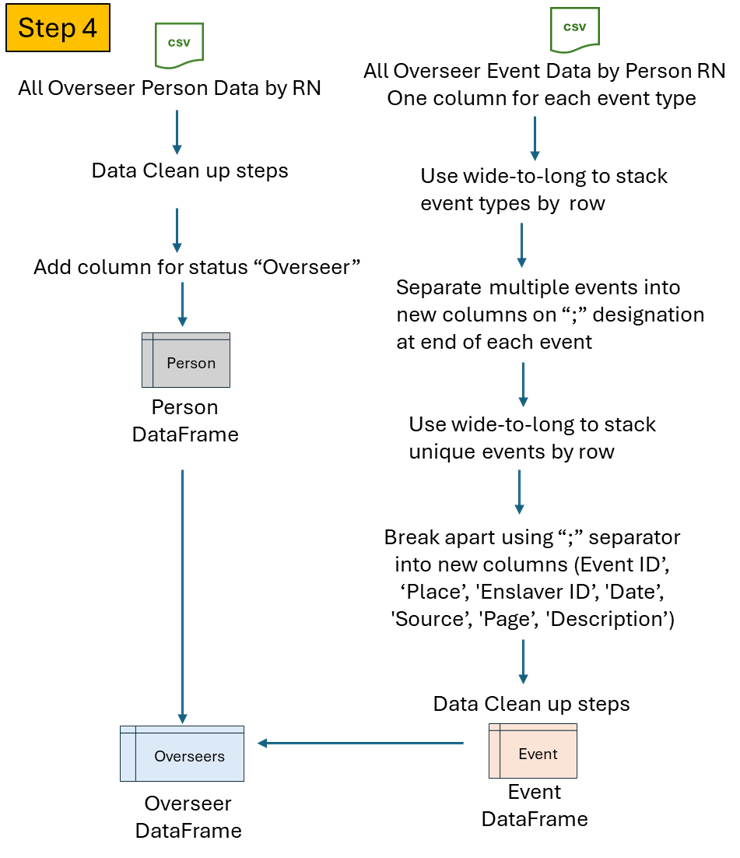

In [97]:
display.Image(filename="FourthStep.png", width=500, height=500)

## Bring in Overseer Person Data and correct date elements as done above for Enslaved persons

In [99]:
#import the Masterfile CSV to work with and a column for "order"
cols= ['RN','Given Name', 'Alternate Name', 'Surname','Sex','Birthdate','Deathdate','Father','Mother','Spouse']
file = "OverseerPersonData_02062024.csv"
OVperson = pd.read_csv(file,header=0, names=cols)
OVperson = trim_all_columns(OVperson)
print(OVperson.shape)
OVperson.head()

(47, 10)


RN Given Name  Alternate Name  Surname Sex Birthdate   Deathdate  \
0  343     Thomas             NaN  Appling   M  Sep 1755  3 Sep 1835   
1  968   Langston             NaN    Bacon   M  bef 1779         NaN   
2  346      Allen             NaN    Blair   M      1754        1834   
3  969         R.             NaN   Bolton   M  bef 1797         NaN   
4  405       John             NaN   Bryant   M  abt 1755         NaN   

            Father                  Mother                Spouse  
0              NaN                     NaN  Elizabeth Austin-344  
1              NaN                     NaN                   NaN  
2              NaN                     NaN  Mary Ann Staples-368  
3              NaN                     NaN                   NaN  
4  John Bryant-404  Elizabeth Hamblett-447                   NaN

### Clean up birth and death dates

In [101]:
hold =OVperson[['RN','Birthdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Birthdate'].str.split(pat=' ', expand=True).fillna(np.NaN)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]

hold['Birthyear'] = hold[2]
hold['Birthyear'] = hold['Birthyear'].fillna(hold[1])
hold['Birthyear'] = hold['Birthyear'].fillna(hold[0])

BYhold = hold[['Birthyear']]
hold=hold.dropna(subset=2)

hold = hold.astype(str)
hold['Birth date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Birthyear'})
hold.head()

Birth date
RN             
355   1767-4-16
446  1759-11-29

In [102]:
OVperson=OVperson.sort_values('RN').set_index('RN')
OVperson = OVperson.join(hold)
OVperson['Birth date'] = OVperson['Birth date'].fillna(OVperson['Birthdate'])
OVperson = OVperson.join(BYhold)
OVperson= OVperson.drop(columns={'Birthdate'})
OVperson=OVperson.reset_index()
print(OVperson.shape)
OVperson.head()

(47, 11)


RN    Given Name  Alternate Name  Surname Sex    Deathdate  \
0  173         Henry             NaN     Reid   M          NaN   
1  343        Thomas             NaN  Appling   M   3 Sep 1835   
2  346         Allen             NaN    Blair   M         1834   
3  355  Burgess Leon             NaN  Griffin   M     Mar 1839   
4  357       Younger             NaN  Landrum   M  19 Sep 1796   

               Father                  Mother                  Spouse  \
0                 NaN                     NaN                     NaN   
1                 NaN                     NaN    Elizabeth Austin-344   
2                 NaN                     NaN    Mary Ann Staples-368   
3    John Griffin-443      Martha Jopling-444  Virginia Jane Page-365   
4  Samuel Landrum-493  Ellizabeth Wortham-495       Patsey Sevier-367   

  Birth date Birthyear  
0   abt 1762      1762  
1   Sep 1755      1755  
2       1754      1754  
3  1767-4-16      1767  
4       1740      1740

In [103]:
hold =OVperson[['RN','Deathdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Deathdate'].str.split(pat=' ', expand=True).fillna(np.NaN)
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])

DYhold = hold[['Deathyear']]
hold=hold.dropna(subset=2)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])

DYhold = hold[['Deathyear']]
hold = hold.astype(str)
hold['Death date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Deathyear'})


OVperson=OVperson.sort_values('RN').set_index('RN')
OVperson = OVperson.join(hold)
OVperson['Death date'] = OVperson['Death date'].fillna(OVperson['Deathdate'])
OVperson = OVperson.join(DYhold)
OVperson = OVperson.drop(columns={'Deathdate'})
OVperson=OVperson.reset_index()
print(OVperson.shape)
OVperson.head()

(47, 12)


RN    Given Name  Alternate Name  Surname Sex              Father  \
0  173         Henry             NaN     Reid   M                 NaN   
1  343        Thomas             NaN  Appling   M                 NaN   
2  346         Allen             NaN    Blair   M                 NaN   
3  355  Burgess Leon             NaN  Griffin   M    John Griffin-443   
4  357       Younger             NaN  Landrum   M  Samuel Landrum-493   

                   Mother                  Spouse Birth date Birthyear  \
0                     NaN                     NaN   abt 1762      1762   
1                     NaN    Elizabeth Austin-344   Sep 1755      1755   
2                     NaN    Mary Ann Staples-368       1754      1754   
3      Martha Jopling-444  Virginia Jane Page-365  1767-4-16      1767   
4  Ellizabeth Wortham-495       Patsey Sevier-367       1740      1740   

  Death date Deathyear  
0        NaN       NaN  
1   1835-9-3      1835  
2       1834       NaN  
3   Mar 1839       NaN  
4  1796-9-19      1796

In [104]:
OVperson['Spouse'] = OVperson['Spouse'].replace(regex=[r'\D+'], value="")
OVperson['Father'] = OVperson['Father'].replace(regex=[r'\D+'], value="")
OVperson['Mother'] = OVperson['Mother'].replace(regex=[r'\D+'], value="")
OVperson[['Father','Mother','Spouse']] =  OVperson[['Father','Mother','Spouse']]

OVperson['Status'] = 'Free'
OVperson.head(10)

RN    Given Name  Alternate Name  Surname Sex Father Mother Spouse  \
0  173         Henry             NaN     Reid   M    NaN    NaN    NaN   
1  343        Thomas             NaN  Appling   M    NaN    NaN    344   
2  346         Allen             NaN    Blair   M    NaN    NaN    368   
3  355  Burgess Leon             NaN  Griffin   M    443    444    365   
4  357       Younger             NaN  Landrum   M    493    495    367   
5  364  Joseph Innis             NaN     Page   M    514      0    352   
6  405          John             NaN   Bryant   M    404    447    NaN   
7  406      Permanus             NaN   Bryant   M    404    447    NaN   
8  412      Benjamin             NaN   Camden   M    413      0    390   
9  423        Daniel             NaN   Connor   M    NaN    NaN    403   

  Birth date Birthyear Death date Deathyear Status  
0   abt 1762      1762        NaN       NaN   Free  
1   Sep 1755      1755   1835-9-3      1835   Free  
2       1754      1754       1834       NaN   Free  
3  1767-4-16      1767   Mar 1839       NaN   Free  
4       1740      1740  1796-9-19      1796   Free  
5       1756      1756   abt 1830       NaN   Free  
6   abt 1755      1755        NaN       NaN   Free  
7   abt 1760      1760        NaN       NaN   Free  
8   abt 1762      1762        NaN       NaN   Free  
9   abt 1760      1760        NaN       NaN   Free

#### Add columns for children even though no children are calculated for overseers

In [106]:
OVperson.loc[:, "Child1"] = np.NaN
OVperson.loc[:, "Child2"] = np.NaN
OVperson.loc[:, "Child3"] = np.NaN
OVperson.loc[:, "Child4"] = np.NaN
OVperson.loc[:, "Child5"] = np.NaN
OVperson.loc[:, "Child6"] = np.NaN
OVperson.loc[:, "Child7"] = np.NaN
OVperson.loc[:, "Child8"] = np.NaN
OVperson.loc[:, "Child9"] = np.NaN
OVperson.loc[:, "Spouse2"] = np.NaN

## Bring in Overseer Event Data and process as above for Enslaved Event Data

/ IMPORTANT- Remove all quotation marks (") before uploading file from Roots Magic

In [109]:
#import the Masterfile CSV to work with and a column for "order"
file = "OverseerEventData_02062024.csv"
OVevents = pd.read_csv(file)
OVevents = trim_all_columns(OVevents)

print(OVevents.shape)
OVevents.head()

(48, 17)


RN  EVE-BIR  EVE-DEA  EVE-TAX  EVE-WILL  EVE-CRF  EVE-RET  \
0  1205      NaN      NaN      NaN       NaN      NaN      NaN   
1   343      NaN      NaN      NaN       NaN      NaN      NaN   
2   968      NaN      NaN      NaN       NaN      NaN      NaN   
3   346      NaN      NaN      NaN       NaN      NaN      NaN   
4   969      NaN      NaN      NaN       NaN      NaN      NaN   

                                             EVE-OVR  EVE-PUN  EVE-MIL  \
0                                                NaN      NaN      NaN   
1  EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...      NaN      NaN   
2  EVE-OVR-049;Union Hill;44;1799-07-23;12;267;Em...      NaN      NaN   
3  EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...      NaN      NaN   
4  EVE-OVR-050;Union Hill;44;1817-08-16;13;422;Ag...      NaN      NaN   

   EVE-ALT  EVE-AGR  EVE-EMN  EVE-CEN  EVE-CEM  EVE-ILL  EVE-MAR  
0      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
1      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
2      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
3      NaN      NaN      NaN      NaN      NaN      NaN      NaN  
4      NaN      NaN      NaN      NaN      NaN      NaN      NaN

In [110]:
OVevents = pd.wide_to_long(OVevents, stubnames='EVE',i='RN', j='type',sep='-', suffix= '\D+')#text suffixes
OVevents= OVevents.reset_index().drop(columns={'type'}).sort_values('RN').set_index('RN').dropna()
OVevents = trim_all_columns(OVevents)
### REmove the last ":" colon in each event row - THIS STEP IS CRITICAL
OVevents['EVE'] = OVevents['EVE'].str[:-1]
### Sort rows by RN and use new index as unique identifier
OVevents = OVevents.reset_index().reset_index().rename(columns={'index':'Order'}).set_index(['Order','RN'])
print(OVevents.shape)
OVevents.head()

(47, 1)


EVE
Order RN                                                    
0     173  EVE-OVR-001;Colleton;44;1792-03-28;12;249;Memo...
1     343  EVE-OVR-002;Colleton;44;1792-03-28;12;249;Memo...
2     346  EVE-OVR-030;Union Hill;43;1788-08-11;8;170;All...
3     355  EVE-OVR-034;Union Hill;43;1791-07-31;8;223;Agr...
4     357  EVE-OVR-011;Colleton;43;1774-07-25;5;7;Agreed ...

#### Expand events splitting the cell on the final ":" of each event then restack using wide_to_long, then break out individual elements splitting on ";"

In [112]:
OVevents =OVevents['EVE'].str.split(pat=':', expand=True).fillna(np.NaN)
OVevents= OVevents.rename(columns={0:'EVE-A',1:'EVE-B',2:'EVE-C',3:'EVE-D',4:'EVE-D',5:'EVE-E',6:'EVE-F',7:'EVE-G',8:'EVE-H',9:'EVE-I',10:'EVE-J',11:'EVE-K',12:'EVE-L',13:'EVE-M',14:'EVE-N',15:'EVE-O',16:'EVE-P',17:'EVE-Q',18:'EVE-R'})
OVevents = OVevents.reset_index()
OVevents = trim_all_columns(OVevents)
#Restack now
OVevents = pd.wide_to_long(OVevents, stubnames='EVE',i=['Order','RN'], j='type',sep='-', suffix= '\D+')#text suffixes
OVevents= OVevents.reset_index().drop(columns={'type','Order'}).drop_duplicates().dropna().sort_values('RN').set_index('RN')
### Now break out to columns for each event using the existing semicolon separator
OVevents =OVevents['EVE'].str.split(pat=';', expand=True)
OVevents = OVevents.rename(columns={0:'Event ID',1:'Place',2:'Enslaver ID',3:'Date',4:'Source',5:'Page',6:'Description'})
print(OVevents.shape)
OVevents.head()

(60, 7)


Event ID     Place Enslaver ID        Date Source Page  \
RN                                                               
173  EVE-OVR-001  Colleton          44  1792-03-28     12  249   
173  EVE-OVR-028  Colleton          44  1787-08-12     11  226   
173  EVE-OVR-044  Colleton          44  1793-10-16     12  255   
343  EVE-OVR-002  Colleton          44  1792-03-28     12  249   
343  EVE-OVR-027  Colleton          44  1787-08-12     11  226   

                                           Description  
RN                                                      
173  Memo of agreement with Henry Reid, overseer, f...  
173  Have agreed with Henry Read, overseer, to over...  
173  Have employed Henry Reid to be an overseer the...  
343  Memo of agreement with Thomas Appling, oversee...  
343  Have agreed with Tho. Appling, Overseer, to ov...

### Add column for Event type and Year

In [114]:
OVevents['Event Type'] = OVevents['Event ID'].str[:-4]
OVevents['Event Type'] = OVevents['Event Type'].replace(to_replace='EVE-OVR', value='Overseer Contract')

OVevents['Year'] = OVevents['Date'].str[:4]
OVevents['Year'] = OVevents['Year'].astype(int)
OVevents['Role'] = 'Overseer'
OVevents.head()

Event ID     Place Enslaver ID        Date Source Page  \
RN                                                               
173  EVE-OVR-001  Colleton          44  1792-03-28     12  249   
173  EVE-OVR-028  Colleton          44  1787-08-12     11  226   
173  EVE-OVR-044  Colleton          44  1793-10-16     12  255   
343  EVE-OVR-002  Colleton          44  1792-03-28     12  249   
343  EVE-OVR-027  Colleton          44  1787-08-12     11  226   

                                           Description         Event Type  \
RN                                                                          
173  Memo of agreement with Henry Reid, overseer, f...  Overseer Contract   
173  Have agreed with Henry Read, overseer, to over...  Overseer Contract   
173  Have employed Henry Reid to be an overseer the...  Overseer Contract   
343  Memo of agreement with Thomas Appling, oversee...  Overseer Contract   
343  Have agreed with Tho. Appling, Overseer, to ov...  Overseer Contract   

     Year      Role  
RN                   
173  1792  Overseer  
173  1787  Overseer  
173  1793  Overseer  
343  1792  Overseer  
343  1787  Overseer

### Now link back to person data 

In [116]:
OVperson = OVperson.sort_values('RN').set_index('RN')
overseers = OVperson.join(OVevents, how='left').reset_index()
overseers['RN'] = overseers['RN'].astype(str)

print(overseers.shape)
overseers.head()

(60, 33)


RN Given Name  Alternate Name  Surname Sex Father Mother Spouse  \
0  173      Henry             NaN     Reid   M    NaN    NaN    NaN   
1  173      Henry             NaN     Reid   M    NaN    NaN    NaN   
2  173      Henry             NaN     Reid   M    NaN    NaN    NaN   
3  343     Thomas             NaN  Appling   M    NaN    NaN    344   
4  343     Thomas             NaN  Appling   M    NaN    NaN    344   

  Birth date Birthyear Death date Deathyear Status  Child1  Child2  Child3  \
0   abt 1762      1762        NaN       NaN   Free     NaN     NaN     NaN   
1   abt 1762      1762        NaN       NaN   Free     NaN     NaN     NaN   
2   abt 1762      1762        NaN       NaN   Free     NaN     NaN     NaN   
3   Sep 1755      1755   1835-9-3      1835   Free     NaN     NaN     NaN   
4   Sep 1755      1755   1835-9-3      1835   Free     NaN     NaN     NaN   

   Child4  Child5  Child6  Child7  Child8  Child9  Spouse2     Event ID  \
0     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-001   
1     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-028   
2     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-044   
3     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-002   
4     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-027   

      Place Enslaver ID        Date Source Page  \
0  Colleton          44  1792-03-28     12  249   
1  Colleton          44  1787-08-12     11  226   
2  Colleton          44  1793-10-16     12  255   
3  Colleton          44  1792-03-28     12  249   
4  Colleton          44  1787-08-12     11  226   

                                         Description         Event Type  Year  \
0  Memo of agreement with Henry Reid, overseer, f...  Overseer Contract  1792   
1  Have agreed with Henry Read, overseer, to over...  Overseer Contract  1787   
2  Have employed Henry Reid to be an overseer the...  Overseer Contract  1793   
3  Memo of agreement with Thomas Appling, oversee...  Overseer Contract  1792   
4  Have agreed with Tho. Appling, Overseer, to ov...  Overseer Contract  1787   

       Role  
0  Overseer  
1  Overseer  
2  Overseer  
3  Overseer  
4  Overseer

## Add Source data

In [118]:
overseers['Source'] = overseers['Source'].astype(float)
overseers = overseers.sort_values('Source').set_index('Source')
overseers.head()

RN  Given Name  Alternate Name   Surname Sex Father Mother Spouse  \
Source                                                                       
3.0     571  William H.             NaN     Trice   M    570      0    585   
3.0     539       David             NaN  Reynolds   M    NaN    NaN    NaN   
4.0     549  Theoderick             NaN   Scruggs   M    993    971    NaN   
4.0     405        John             NaN    Bryant   M    404    447    NaN   
5.0     357     Younger             NaN   Landrum   M    493    495    367   

       Birth date Birthyear Death date Deathyear Status  Child1  Child2  \
Source                                                                    
3.0      abt 1742      1742       1812       NaN   Free     NaN     NaN   
3.0          1740      1740       1823       NaN   Free     NaN     NaN   
4.0      abt 1740      1740        NaN       NaN   Free     NaN     NaN   
4.0      abt 1755      1755        NaN       NaN   Free     NaN     NaN   
5.0          1740      1740  1796-9-19      1796   Free     NaN     NaN   

        Child3  Child4  Child5  Child6  Child7  Child8  Child9  Spouse2  \
Source                                                                    
3.0        NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN   
3.0        NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN   
4.0        NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN   
4.0        NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN   
5.0        NaN     NaN     NaN     NaN     NaN     NaN     NaN      NaN   

           Event ID     Place Enslaver ID        Date Page  \
Source                                                       
3.0     EVE-OVR-008  Colleton          43  1771-10-01        
3.0     EVE-OVR-007  Colleton          43  1771-09-13        
4.0     EVE-OVR-009  Colleton          43  1773-07-20        
4.0     EVE-OVR-010  Colleton          43  1773-11-29        
5.0     EVE-OVR-011  Colleton          43  1774-07-25    7   

                                              Description         Event Type  \
Source                                                                         
3.0     Agreed with Trice to continue my overseer for ...  Overseer Contract   
3.0     Agreed with David Reynolds to overlook 10 negr...  Overseer Contract   
4.0     Agreed with Theoderick Scruggs to be an overse...  Overseer Contract   
4.0     John Bryant came and settled at my upper place...  Overseer Contract   
5.0     Agreed with Young Landrum to look after my two...  Overseer Contract   

        Year      Role  
Source                  
3.0     1771  Overseer  
3.0     1771  Overseer  
4.0     1773  Overseer  
4.0     1773  Overseer  
5.0     1774  Overseer

In [119]:
overseers = overseers.join(sources, how='left').reset_index()
print(overseers.shape)
overseers.head()

(60, 35)


Source   RN  Given Name  Alternate Name   Surname Sex Father Mother Spouse  \
0     3.0  571  William H.             NaN     Trice   M    570      0    585   
1     3.0  539       David             NaN  Reynolds   M    NaN    NaN    NaN   
2     4.0  549  Theoderick             NaN   Scruggs   M    993    971    NaN   
3     4.0  405        John             NaN    Bryant   M    404    447    NaN   
4     5.0  357     Younger             NaN   Landrum   M    493    495    367   

  Birth date Birthyear Death date Deathyear Status  Child1  Child2  Child3  \
0   abt 1742      1742       1812       NaN   Free     NaN     NaN     NaN   
1       1740      1740       1823       NaN   Free     NaN     NaN     NaN   
2   abt 1740      1740        NaN       NaN   Free     NaN     NaN     NaN   
3   abt 1755      1755        NaN       NaN   Free     NaN     NaN     NaN   
4       1740      1740  1796-9-19      1796   Free     NaN     NaN     NaN   

   Child4  Child5  Child6  Child7  Child8  Child9  Spouse2     Event ID  \
0     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-008   
1     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-007   
2     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-009   
3     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-010   
4     NaN     NaN     NaN     NaN     NaN     NaN      NaN  EVE-OVR-011   

      Place Enslaver ID        Date Page  \
0  Colleton          43  1771-10-01        
1  Colleton          43  1771-09-13        
2  Colleton          43  1773-07-20        
3  Colleton          43  1773-11-29        
4  Colleton          43  1774-07-25    7   

                                         Description         Event Type  Year  \
0  Agreed with Trice to continue my overseer for ...  Overseer Contract  1771   
1  Agreed with David Reynolds to overlook 10 negr...  Overseer Contract  1771   
2  Agreed with Theoderick Scruggs to be an overse...  Overseer Contract  1773   
3  John Bryant came and settled at my upper place...  Overseer Contract  1773   
4  Agreed with Young Landrum to look after my two...  Overseer Contract  1774   

       Role                                 Source Description  \
0  Overseer  Cabell, William, Sr. Commonplace books, 1769-1...   
1  Overseer  Cabell, William, Sr. Commonplace books, 1769-1...   
2  Overseer  Cabell, William, Sr. Commonplace books, 1769-1...   
3  Overseer  Cabell, William, Sr. Commonplace books, 1769-1...   
4  Overseer  Cabell, William, Sr. Commonplace books, 1769-1...   

                                          Repository  
0  Virginia Museum of History and Culture, Richmo...  
1  Virginia Museum of History and Culture, Richmo...  
2  Virginia Museum of History and Culture, Richmo...  
3  Virginia Museum of History and Culture, Richmo...  
4  Virginia Museum of History and Culture, Richmo...

## Create Overseer-hold dataframe for overseers by enslaver

In [121]:
OVhold = overseers[['RN','Enslaver ID','Year']]
print(OVhold.shape)
OVhold.head()

(60, 3)


RN Enslaver ID  Year
0  571          43  1771
1  539          43  1771
2  549          43  1773
3  405          43  1773
4  357          43  1774

In [122]:
OVhold = OVhold.sort_values('Year').rename(columns={'RN':'Overseer'}).drop(columns={'Year'}).drop_duplicates().sort_values(['Enslaver ID','Overseer'])
OVhold['count'] = OVhold.groupby('Enslaver ID').cumcount()
OVhold = OVhold.sort_values(['Enslaver ID','count'])
OVhold = OVhold.pivot(index=['Enslaver ID'], columns='count', values='Overseer').reset_index()
print(OVhold.shape)
OVhold.head(10)

(6, 29)


count Enslaver ID     0    1    2    3    4    5    6    7    8    9   10  \
0             272   531  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1              43   346  355  357  364  405  406  412  423  425  430  446   
2              44   173  343  560  561  575  967  968  969  970  NaN  NaN   
3              45  1000  994  995  996  997  999  NaN  NaN  NaN  NaN  NaN   
4             857   977  981  987  989  998  NaN  NaN  NaN  NaN  NaN  NaN   
5             858   998  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

count   11   12   13   14   15   16   17   18   19   20   21   22   23   24  \
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
1      459  462  477  507  513  532  534  539  549  556  560  561  562  571   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
5      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

count   25   26   27  
0      NaN  NaN  NaN  
1      587  597  965  
2      NaN  NaN  NaN  
3      NaN  NaN  NaN  
4      NaN  NaN  NaN  
5      NaN  NaN  NaN

# Step 5

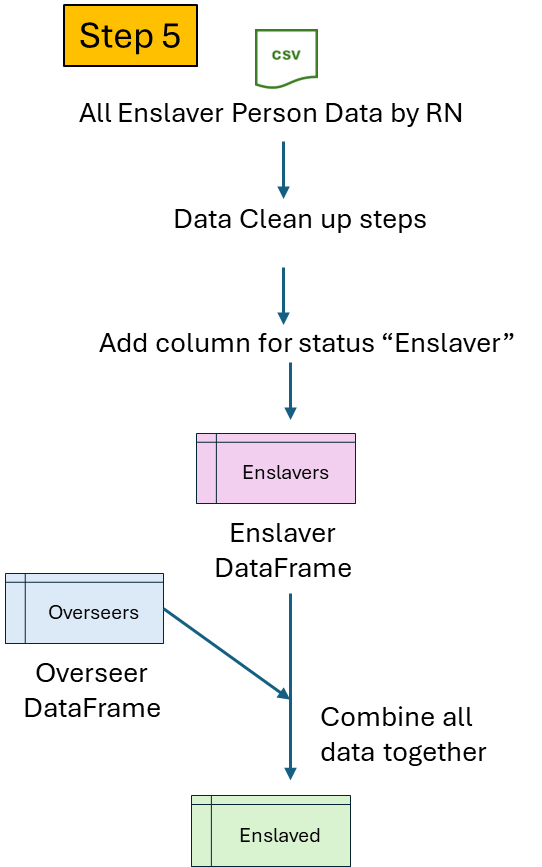

In [124]:
display.Image(filename="Fifth Step.png", width=300, height=300)

## Bring in Enslaver Person Data

In [126]:
#import the Masterfile CSV to work with and a column for "order"
cols= ['RN','Given Name', 'Alternate Name', 'Surname','Sex','Birthdate','Deathdate','Father','Mother','Spouse','Spouse2']
file = "ENSLAVERPersonData_03082024.csv"
ENperson = pd.read_csv(file, header=0, names=cols)
ENperson = trim_all_columns(ENperson)

# Remove names from Spouse and Parents - just Keep RN
ENperson[['Spouse','Spouse2','Father','Mother']] = ENperson[['Spouse','Spouse2','Father','Mother']].replace(regex=[r'\D+'], value="")
ENperson['Status'] = 'Enslaver'

ENperson = ENperson.sort_values('Mother')
ENperson.head(10)

print(ENperson.shape)
ENperson.head()

(110, 12)


RN  Given Name  Alternate Name   Surname Sex   Birthdate    Deathdate  \
109  591        Seth             NaN  Woodroof   M        1804   4 Aug 1875   
76   137  John David             NaN    Loving   M  4 Oct 1739  10 May 1804   
67   892     William             NaN   Johnson   M    bef 1775          NaN   
65   919     William             NaN   Horsley   M        1815         1887   
57   286   Mary Rice             NaN   Garland   F        1804         1893   

    Father Mother Spouse  Spouse2    Status  
109    589      0    NaN      NaN  Enslaver  
76     334      0    NaN      NaN  Enslaver  
67    1039      0   1038      NaN  Enslaver  
65    1053   1049    NaN      NaN  Enslaver  
57    1050   1057    276      NaN  Enslaver

### Fix Birth and Death dates as done above for Enslaved and Overseers

In [128]:
hold =ENperson[['RN','Birthdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Birthdate'].str.split(pat=' ', expand=True).fillna(np.NaN)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]

hold['Birthyear'] = hold[2]
hold['Birthyear'] = hold['Birthyear'].fillna(hold[1])
hold['Birthyear'] = hold['Birthyear'].fillna(hold[0])

BYhold = hold[['Birthyear']]
hold=hold.dropna(subset=2)

hold = hold.astype(str)
hold['Birth date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Birthyear'})
hold.head()

Birth date
RN             
43    1730-3-13
44    1759-3-25
45    1800-11-7
137   1739-10-4
215  1820-11-22

In [129]:
ENperson=ENperson.sort_values('RN').set_index('RN')
ENperson=ENperson.join(hold)
ENperson['Birth date'] = ENperson['Birth date'].fillna(ENperson['Birthdate'])
ENperson = ENperson.join(BYhold)
ENperson= ENperson.drop(columns={'Birthdate'})

ENperson=ENperson.reset_index()
print(ENperson.shape)
ENperson.head()

(110, 13)


RN  Given Name  Alternate Name     Surname Sex    Deathdate Father Mother  \
0  43     William             NaN      Cabell   M  23 Mar 1798     42     48   
1  44     William             NaN      Cabell   M  22 Nov 1822     43     47   
2  45        Mayo             NaN      Cabell   M   5 May 1869     44     46   
3  46  Anne Nancy             NaN  Carrington   F         1838    932    933   
4  47    Margaret             NaN      Jordan   F         1812    131    132   

  Spouse  Spouse2    Status Birth date Birthyear  
0     47      NaN  Enslaver  1730-3-13      1730  
1     46      NaN  Enslaver  1759-3-25      1759  
2    856    860.0  Enslaver  1800-11-7      1800  
3     44      NaN  Enslaver       1760      1760  
4     43      NaN  Enslaver       1742      1742

In [130]:
hold =ENperson[['RN','Deathdate']]
hold= hold.sort_values('RN').set_index('RN')
hold = hold['Deathdate'].str.split(pat=' ', expand=True).fillna(np.NaN)
hold=hold.dropna(subset=2)

hold = hold.replace({1: month})
hold= hold[[2,1,0]]
hold['Deathyear'] = hold[2]
hold['Deathyear'] = hold['Deathyear'].fillna(hold[1])
hold['Deathyear'] = hold['Deathyear'].fillna(hold[0])


DYhold = hold[['Deathyear']]
hold = hold.astype(str)
hold['Death date'] = hold[[2,1,0]].agg('-'.join, axis=1)
hold = hold.drop(columns={2,1,0,'Deathyear'})


ENperson=ENperson.sort_values('RN').set_index('RN')
ENperson = ENperson.join(hold)
ENperson['Death date'] = ENperson['Death date'].fillna(ENperson['Deathdate'])
ENperson = ENperson.join(DYhold)
ENperson = ENperson.drop(columns={'Deathdate'})
ENperson=ENperson.reset_index()
print(ENperson.shape)
ENperson.head()

(110, 14)


RN  Given Name  Alternate Name     Surname Sex Father Mother Spouse  \
0  43     William             NaN      Cabell   M     42     48     47   
1  44     William             NaN      Cabell   M     43     47     46   
2  45        Mayo             NaN      Cabell   M     44     46    856   
3  46  Anne Nancy             NaN  Carrington   F    932    933     44   
4  47    Margaret             NaN      Jordan   F    131    132     43   

   Spouse2    Status Birth date Birthyear  Death date Deathyear  
0      NaN  Enslaver  1730-3-13      1730   1798-3-23      1798  
1      NaN  Enslaver  1759-3-25      1759  1822-11-22      1822  
2    860.0  Enslaver  1800-11-7      1800    1869-5-5      1869  
3      NaN  Enslaver       1760      1760        1838       NaN  
4      NaN  Enslaver       1742      1742        1812       NaN

### Calculate Child Field from Mother and Father

In [132]:
#create dataframe of Mothers
df = ENperson[['Mother','RN']].sort_values(['Mother','RN'])
print(df.shape)
df = df.dropna().astype(int)
print(df.shape)
df = df[df['Mother']!=0]
df['count'] = df.groupby('Mother').cumcount()
df = df.sort_values(['Mother','count'])
df = df.pivot(index=['Mother'], columns='count', values='RN').reset_index()
df =df.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Mother':'RN'})
df.head()

(110, 2)
(44, 2)


count   RN  Child1  Child2  Child3  Child4  Child5  Child6  Child7  Child8  \
0       46    45.0   213.0   276.0   277.0   278.0   279.0   280.0   281.0   
1       47    44.0   261.0   265.0   268.0   271.0   272.0     NaN     NaN   
2       48    43.0    51.0     NaN     NaN     NaN     NaN     NaN     NaN   
3      132    47.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   
4      213   215.0   680.0     NaN     NaN     NaN     NaN     NaN     NaN   

count  Child9  
0       282.0  
1         NaN  
2         NaN  
3         NaN  
4         NaN

### Repeat for Father and children

In [134]:
#create dataframe of Fathers
dff = ENperson[['Father','RN']]
dff= dff.sort_values(['Father','RN'])
print(dff.shape)
dff = dff.dropna().astype(int)
dff = dff[dff['Father']!=0]
print(dff.shape)
dff['count'] = dff.groupby('Father').cumcount()
dff = dff.sort_values(['Father','count'])
dff = dff.pivot(index=['Father'], columns='count', values='RN').reset_index()
dff =dff.rename(columns={0:'Child1',1:'Child2',2:'Child3',3:'Child4',4:'Child5',5:'Child6',6:'Child7',7:'Child8',8:'Child9','Father':'RN'})
dff.head()

(110, 2)
(44, 2)


count   RN  Child1  Child2  Child3  Child4  Child5  Child6  Child7  Child8  \
0       42    43.0    51.0     NaN     NaN     NaN     NaN     NaN     NaN   
1       43    44.0   261.0   265.0   268.0   271.0   272.0     NaN     NaN   
2       44    45.0   213.0   276.0   277.0   278.0   279.0   280.0   281.0   
3       45   857.0   858.0   859.0   866.0     NaN     NaN     NaN     NaN   
4      131    47.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN   

count  Child9  
0         NaN  
1         NaN  
2       282.0  
3         NaN  
4         NaN

### Concatenate Join Mother and Father together

In [136]:
children = pd.concat([df,dff]).sort_values('RN').set_index('RN')
print(children.shape)
children.head()

(43, 9)


count  Child1  Child2  Child3  Child4  Child5  Child6  Child7  Child8  Child9
RN                                                                           
42       43.0    51.0     NaN     NaN     NaN     NaN     NaN     NaN     NaN
43       44.0   261.0   265.0   268.0   271.0   272.0     NaN     NaN     NaN
44       45.0   213.0   276.0   277.0   278.0   279.0   280.0   281.0   282.0
45      857.0   858.0   859.0   866.0     NaN     NaN     NaN     NaN     NaN
46       45.0   213.0   276.0   277.0   278.0   279.0   280.0   281.0   282.0

### Rejoin to person Dataframe

In [138]:
ENperson = ENperson.sort_values('RN').set_index('RN')
ENperson = ENperson.join(children)
print(ENperson.shape)
ENperson.head()

(110, 22)


Given Name  Alternate Name     Surname Sex Father Mother Spouse  Spouse2  \
RN                                                                             
43     William             NaN      Cabell   M     42     48     47      NaN   
44     William             NaN      Cabell   M     43     47     46      NaN   
45        Mayo             NaN      Cabell   M     44     46    856    860.0   
46  Anne Nancy             NaN  Carrington   F    932    933     44      NaN   
47    Margaret             NaN      Jordan   F    131    132     43      NaN   

      Status Birth date Birthyear  Death date Deathyear  Child1  Child2  \
RN                                                                        
43  Enslaver  1730-3-13      1730   1798-3-23      1798    44.0   261.0   
44  Enslaver  1759-3-25      1759  1822-11-22      1822    45.0   213.0   
45  Enslaver  1800-11-7      1800    1869-5-5      1869   857.0   858.0   
46  Enslaver       1760      1760        1838       NaN    45.0   213.0   
47  Enslaver       1742      1742        1812       NaN    44.0   261.0   

    Child3  Child4  Child5  Child6  Child7  Child8  Child9  
RN                                                          
43   265.0   268.0   271.0   272.0     NaN     NaN     NaN  
44   276.0   277.0   278.0   279.0   280.0   281.0   282.0  
45   859.0   866.0     NaN     NaN     NaN     NaN     NaN  
46   276.0   277.0   278.0   279.0   280.0   281.0   282.0  
47   265.0   268.0   271.0   272.0     NaN     NaN     NaN

### Add Source Data for Enslavers

In [140]:
#import the Masterfile CSV to work with and a column for "order"
file = "EnslaverSources_06242024.csv"
ENsources = pd.read_csv(file)
ENsources = trim_all_columns(ENsources)
ENsources['RN'] = ENsources['RN'].astype(int)
ENsources = ENsources.sort_values('RN').set_index('RN')
print(ENsources.shape)
ENsources.head()

(109, 3)


Source Description   Page Repository
RN                                                                     
43  Brown, Alexander. The Cabells and Their Kin: A...   81.0        NaN
44  Brown, Alexander. The Cabells and Their Kin: A...  207.0        NaN
45  Brown, Alexander. The Cabells and Their Kin: A...  423.0        NaN
46  Brown, Alexander. The Cabells and Their Kin: A...  209.0        NaN
47  Brown, Alexander. The Cabells and Their Kin: A...   83.0        NaN

In [141]:
ENperson = ENperson.join(ENsources).reset_index()
ENperson.head()

RN  Given Name  Alternate Name     Surname Sex Father Mother Spouse  \
0  43     William             NaN      Cabell   M     42     48     47   
1  44     William             NaN      Cabell   M     43     47     46   
2  45        Mayo             NaN      Cabell   M     44     46    856   
3  46  Anne Nancy             NaN  Carrington   F    932    933     44   
4  47    Margaret             NaN      Jordan   F    131    132     43   

   Spouse2    Status Birth date Birthyear  Death date Deathyear  Child1  \
0      NaN  Enslaver  1730-3-13      1730   1798-3-23      1798    44.0   
1      NaN  Enslaver  1759-3-25      1759  1822-11-22      1822    45.0   
2    860.0  Enslaver  1800-11-7      1800    1869-5-5      1869   857.0   
3      NaN  Enslaver       1760      1760        1838       NaN    45.0   
4      NaN  Enslaver       1742      1742        1812       NaN    44.0   

   Child2  Child3  Child4  Child5  Child6  Child7  Child8  Child9  \
0   261.0   265.0   268.0   271.0   272.0     NaN     NaN     NaN   
1   213.0   276.0   277.0   278.0   279.0   280.0   281.0   282.0   
2   858.0   859.0   866.0     NaN     NaN     NaN     NaN     NaN   
3   213.0   276.0   277.0   278.0   279.0   280.0   281.0   282.0   
4   261.0   265.0   268.0   271.0   272.0     NaN     NaN     NaN   

                                  Source Description   Page Repository  
0  Brown, Alexander. The Cabells and Their Kin: A...   81.0        NaN  
1  Brown, Alexander. The Cabells and Their Kin: A...  207.0        NaN  
2  Brown, Alexander. The Cabells and Their Kin: A...  423.0        NaN  
3  Brown, Alexander. The Cabells and Their Kin: A...  209.0        NaN  
4  Brown, Alexander. The Cabells and Their Kin: A...   83.0        NaN

## Join all person and event data together from enslavers and overseers

In [143]:
df = pd.concat([ENperson,overseers])
print(df.shape)
df.head()      

(170, 35)


RN  Given Name  Alternate Name     Surname Sex Father Mother Spouse  \
0  43     William             NaN      Cabell   M     42     48     47   
1  44     William             NaN      Cabell   M     43     47     46   
2  45        Mayo             NaN      Cabell   M     44     46    856   
3  46  Anne Nancy             NaN  Carrington   F    932    933     44   
4  47    Margaret             NaN      Jordan   F    131    132     43   

   Spouse2    Status Birth date Birthyear  Death date Deathyear  Child1  \
0      NaN  Enslaver  1730-3-13      1730   1798-3-23      1798    44.0   
1      NaN  Enslaver  1759-3-25      1759  1822-11-22      1822    45.0   
2    860.0  Enslaver  1800-11-7      1800    1869-5-5      1869   857.0   
3      NaN  Enslaver       1760      1760        1838       NaN    45.0   
4      NaN  Enslaver       1742      1742        1812       NaN    44.0   

   Child2  Child3  Child4  Child5  Child6  Child7  Child8  Child9  \
0   261.0   265.0   268.0   271.0   272.0     NaN     NaN     NaN   
1   213.0   276.0   277.0   278.0   279.0   280.0   281.0   282.0   
2   858.0   859.0   866.0     NaN     NaN     NaN     NaN     NaN   
3   213.0   276.0   277.0   278.0   279.0   280.0   281.0   282.0   
4   261.0   265.0   268.0   271.0   272.0     NaN     NaN     NaN   

                                  Source Description   Page Repository  \
0  Brown, Alexander. The Cabells and Their Kin: A...   81.0        NaN   
1  Brown, Alexander. The Cabells and Their Kin: A...  207.0        NaN   
2  Brown, Alexander. The Cabells and Their Kin: A...  423.0        NaN   
3  Brown, Alexander. The Cabells and Their Kin: A...  209.0        NaN   
4  Brown, Alexander. The Cabells and Their Kin: A...   83.0        NaN   

   Source Event ID Place Enslaver ID Date Description Event Type  Year Role  
0     NaN      NaN   NaN         NaN  NaN         NaN        NaN   NaN  NaN  
1     NaN      NaN   NaN         NaN  NaN         NaN        NaN   NaN  NaN  
2     NaN      NaN   NaN         NaN  NaN         NaN        NaN   NaN  NaN  
3     NaN      NaN   NaN         NaN  NaN         NaN        NaN   NaN  NaN  
4     NaN      NaN   NaN         NaN  NaN         NaN        NaN   NaN  NaN

In [144]:
df['Status'].value_counts()

Status
Enslaver    110
Free         60
Name: count, dtype: int64

# Step 6

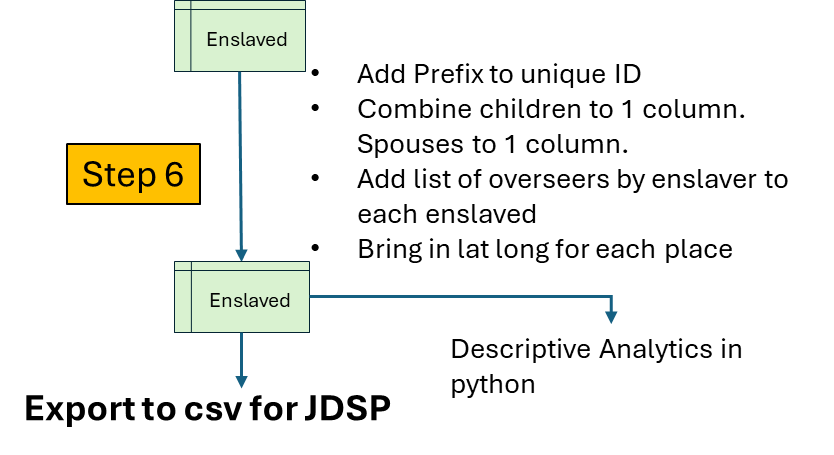

In [146]:
display.Image(filename="SixthStep.png", width=700, height=700)

## Join back to Enslaved DataFrame

In [148]:
enslaved = pd.concat([enslaved,df])
#reorganize columns
enslaved[['RN','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Enslaver ID']] = enslaved[['RN','Father','Mother','Spouse','Spouse2','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9','Enslaver ID']].fillna(10000).astype(int).astype(str)
print(enslaved.shape)
enslaved.head()

(3913, 35)


RN Given Name Alternate Name Surname Sex Birthyear Birth date Deathyear  \
1143  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1278  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1260  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1263  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1264  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   

     Death date Father Mother Spouse Spouse2 Child1 Child2 Child3 Child4  \
1143        NaN  10000  10000     14   10000     97    121  10000  10000   
1278        NaN  10000  10000     14   10000     97    121  10000  10000   
1260        NaN  10000  10000     14   10000     97    121  10000  10000   
1263        NaN  10000  10000     14   10000     97    121  10000  10000   
1264        NaN  10000  10000     14   10000     97    121  10000  10000   

     Child5 Child6 Child7 Child8 Child9     Event ID   Event Type       Place  \
1143  10000  10000  10000  10000  10000  EVE-NEC-002  Necessities    Colleton   
1278  10000  10000  10000  10000  10000  EVE-BIR-024        Birth  Union Hill   
1260  10000  10000  10000  10000  10000  EVE-BIR-033        Birth  Union Hill   
1263  10000  10000  10000  10000  10000  EVE-BIR-035        Birth  Union Hill   
1264  10000  10000  10000  10000  10000  EVE-BIR-034        Birth  Union Hill   

        Status       Role Enslaver ID        Date    Year  \
1143  Enslaved  Recipient          43  1770-09-22  1770.0   
1278  Enslaved    Midwife          43  1786-05-17  1786.0   
1260  Enslaved    Midwife          43  1795-07-25  1795.0   
1263  Enslaved    Midwife          43  1795-12-29  1795.0   
1264  Enslaved    Midwife          43  1795-08-07  1795.0   

                                            Description  Source  \
1143  Blankets gave out 1770. 2 Fanny and her childr...     2.0   
1278               Lett delivered of a boy by Old Venus     8.0   
1260  Hannah wife of young George was delivered of a...     8.0   
1263            Molly delivered of a girl by old Venus.     8.0   
1264  Young Isbel delivered of a boy by old Venus an...     8.0   

                                     Source Description  Page  \
1143  Cabell, William, Sr. Commonplace books, 1769-1...    27   
1278  Cabell, William, Sr. Commonplace books, 1769-1...   115   
1260  Cabell, William, Sr. Commonplace books, 1769-1...   303   
1263  Cabell, William, Sr. Commonplace books, 1769-1...   310   
1264  Cabell, William, Sr. Commonplace books, 1769-1...   304   

                                             Repository  
1143  Virginia Museum of History and Culture, Richmo...  
1278  Virginia Museum of History and Culture, Richmo...  
1260  Virginia Museum of History and Culture, Richmo...  
1263  Virginia Museum of History and Culture, Richmo...  
1264  Virginia Museum of History and Culture, Richmo...

In [149]:
enslaved[enslaved['RN']=='45']

RN Given Name Alternate Name Surname Sex Birthyear Birth date Deathyear  \
2  45       Mayo            NaN  Cabell   M      1800  1800-11-7      1869   

  Death date Father Mother Spouse Spouse2 Child1 Child2 Child3 Child4 Child5  \
2   1869-5-5     44     46    856     860    857    858    859    866  10000   

  Child6 Child7 Child8 Child9 Event ID Event Type Place    Status Role  \
2  10000  10000  10000  10000      NaN        NaN   NaN  Enslaver  NaN   

  Enslaver ID Date  Year Description  Source  \
2       10000  NaN   NaN         NaN     NaN   

                                  Source Description   Page Repository  
2  Brown, Alexander. The Cabells and Their Kin: A...  423.0        NaN

## Fix Individual to have 'PERS-CAB-' in front of the RN and '-UH' on the back of the RN

### For each future data set, the last element will change, but the person can be matched across plantations with the prefix and number part

In [152]:
#enslaved['Person'] = 'PERS-CAB-'+enslaved['RN']+'-UH'
enslaved['Person'] = enslaved['RN']

keys_to_update = ['Person', 'Father', 'Mother', 'Spouse','Spouse2','Enslaver ID','Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9']
prefix = 'PERS-CAB-'

for key in keys_to_update:
    enslaved[key] = prefix + enslaved[key] + '-UH'
    
enslaved = enslaved.replace(to_replace='PERS-CAB-10000-UH', value=pd.NA)
print(enslaved.shape)
enslaved.head()   

(3913, 36)


RN Given Name Alternate Name Surname Sex Birthyear Birth date Deathyear  \
1143  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1278  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1260  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1263  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   
1264  1      Venus            NaN     NaN   F      1745   bef 1745       NaN   

     Death date Father Mother          Spouse Spouse2          Child1  \
1143        NaN   <NA>   <NA>  PERS-CAB-14-UH    <NA>  PERS-CAB-97-UH   
1278        NaN   <NA>   <NA>  PERS-CAB-14-UH    <NA>  PERS-CAB-97-UH   
1260        NaN   <NA>   <NA>  PERS-CAB-14-UH    <NA>  PERS-CAB-97-UH   
1263        NaN   <NA>   <NA>  PERS-CAB-14-UH    <NA>  PERS-CAB-97-UH   
1264        NaN   <NA>   <NA>  PERS-CAB-14-UH    <NA>  PERS-CAB-97-UH   

               Child2 Child3 Child4 Child5 Child6 Child7 Child8 Child9  \
1143  PERS-CAB-121-UH   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
1278  PERS-CAB-121-UH   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
1260  PERS-CAB-121-UH   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
1263  PERS-CAB-121-UH   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   
1264  PERS-CAB-121-UH   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   <NA>   

         Event ID   Event Type       Place    Status       Role  \
1143  EVE-NEC-002  Necessities    Colleton  Enslaved  Recipient   
1278  EVE-BIR-024        Birth  Union Hill  Enslaved    Midwife   
1260  EVE-BIR-033        Birth  Union Hill  Enslaved    Midwife   
1263  EVE-BIR-035        Birth  Union Hill  Enslaved    Midwife   
1264  EVE-BIR-034        Birth  Union Hill  Enslaved    Midwife   

         Enslaver ID        Date    Year  \
1143  PERS-CAB-43-UH  1770-09-22  1770.0   
1278  PERS-CAB-43-UH  1786-05-17  1786.0   
1260  PERS-CAB-43-UH  1795-07-25  1795.0   
1263  PERS-CAB-43-UH  1795-12-29  1795.0   
1264  PERS-CAB-43-UH  1795-08-07  1795.0   

                                            Description  Source  \
1143  Blankets gave out 1770. 2 Fanny and her childr...     2.0   
1278               Lett delivered of a boy by Old Venus     8.0   
1260  Hannah wife of young George was delivered of a...     8.0   
1263            Molly delivered of a girl by old Venus.     8.0   
1264  Young Isbel delivered of a boy by old Venus an...     8.0   

                                     Source Description  Page  \
1143  Cabell, William, Sr. Commonplace books, 1769-1...    27   
1278  Cabell, William, Sr. Commonplace books, 1769-1...   115   
1260  Cabell, William, Sr. Commonplace books, 1769-1...   303   
1263  Cabell, William, Sr. Commonplace books, 1769-1...   310   
1264  Cabell, William, Sr. Commonplace books, 1769-1...   304   

                                             Repository         Person  
1143  Virginia Museum of History and Culture, Richmo...  PERS-CAB-1-UH  
1278  Virginia Museum of History and Culture, Richmo...  PERS-CAB-1-UH  
1260  Virginia Museum of History and Culture, Richmo...  PERS-CAB-1-UH  
1263  Virginia Museum of History and Culture, Richmo...  PERS-CAB-1-UH  
1264  Virginia Museum of History and Culture, Richmo...  PERS-CAB-1-UH

### Combine Overseers into one column

In [154]:
OVhold[['Enslaver ID',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]] = 'PERS-CAB-' + OVhold[['Enslaver ID',0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]] +'-UH'
OVhold.head()

count      Enslaver ID                 0                1                2  \
0      PERS-CAB-272-UH   PERS-CAB-531-UH              NaN              NaN   
1       PERS-CAB-43-UH   PERS-CAB-346-UH  PERS-CAB-355-UH  PERS-CAB-357-UH   
2       PERS-CAB-44-UH   PERS-CAB-173-UH  PERS-CAB-343-UH  PERS-CAB-560-UH   
3       PERS-CAB-45-UH  PERS-CAB-1000-UH  PERS-CAB-994-UH  PERS-CAB-995-UH   
4      PERS-CAB-857-UH   PERS-CAB-977-UH  PERS-CAB-981-UH  PERS-CAB-987-UH   

count                3                4                5                6  \
0                  NaN              NaN              NaN              NaN   
1      PERS-CAB-364-UH  PERS-CAB-405-UH  PERS-CAB-406-UH  PERS-CAB-412-UH   
2      PERS-CAB-561-UH  PERS-CAB-575-UH  PERS-CAB-967-UH  PERS-CAB-968-UH   
3      PERS-CAB-996-UH  PERS-CAB-997-UH  PERS-CAB-999-UH              NaN   
4      PERS-CAB-989-UH  PERS-CAB-998-UH              NaN              NaN   

count                7                8                9               10  \
0                  NaN              NaN              NaN              NaN   
1      PERS-CAB-423-UH  PERS-CAB-425-UH  PERS-CAB-430-UH  PERS-CAB-446-UH   
2      PERS-CAB-969-UH  PERS-CAB-970-UH              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   

count               11               12               13               14  \
0                  NaN              NaN              NaN              NaN   
1      PERS-CAB-459-UH  PERS-CAB-462-UH  PERS-CAB-477-UH  PERS-CAB-507-UH   
2                  NaN              NaN              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   

count               15               16               17               18  \
0                  NaN              NaN              NaN              NaN   
1      PERS-CAB-513-UH  PERS-CAB-532-UH  PERS-CAB-534-UH  PERS-CAB-539-UH   
2                  NaN              NaN              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   

count               19               20               21               22  \
0                  NaN              NaN              NaN              NaN   
1      PERS-CAB-549-UH  PERS-CAB-556-UH  PERS-CAB-560-UH  PERS-CAB-561-UH   
2                  NaN              NaN              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   

count               23               24               25               26  \
0                  NaN              NaN              NaN              NaN   
1      PERS-CAB-562-UH  PERS-CAB-571-UH  PERS-CAB-587-UH  PERS-CAB-597-UH   
2                  NaN              NaN              NaN              NaN   
3                  NaN              NaN              NaN              NaN   
4                  NaN              NaN              NaN              NaN   

count               27  
0                  NaN  
1      PERS-CAB-965-UH  
2                  NaN  
3                  NaN  
4                  NaN

In [155]:
OVhold['Overseers'] = OVhold[[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27]].apply(lambda x: x.str.cat(sep=','), axis=1)
OVhold = OVhold[['Enslaver ID','Overseers']]
OVhold = OVhold.sort_values('Enslaver ID').set_index('Enslaver ID')
print(OVhold.shape)
OVhold.head(5)

(6, 1)


count                                                    Overseers
Enslaver ID                                                       
PERS-CAB-272-UH                                    PERS-CAB-531-UH
PERS-CAB-43-UH   PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...
PERS-CAB-44-UH   PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...
PERS-CAB-45-UH   PERS-CAB-1000-UH,PERS-CAB-994-UH,PERS-CAB-995-...
PERS-CAB-857-UH  PERS-CAB-977-UH,PERS-CAB-981-UH,PERS-CAB-987-U...

In [156]:
enslaved = enslaved.sort_values('Enslaver ID').set_index('Enslaver ID')
enslaved = enslaved.join(OVhold).reset_index()
print(enslaved.shape)
enslaved.head(5)

(3913, 37)


Enslaver ID   RN Given Name     Alternate Name Surname Sex Birthyear  \
0  PERS-CAB-0-UH   74       Will       Creasy's boy     NaN   M      1781   
1  PERS-CAB-0-UH  259        Sam                NaN     NaN   M      1793   
2  PERS-CAB-0-UH   78       Cate  Creasy's daughter     NaN   F      1783   
3  PERS-CAB-0-UH   97     George                NaN     NaN   M      1762   
4  PERS-CAB-0-UH  916     Edward                NaN     NaN   M      1841   

  Birth date Deathyear Death date           Father          Mother  \
0  1781-1-15       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
1       1793       NaN        NaN             <NA>            <NA>   
2  1783-11-5       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
3   bef 1762       NaN        NaN   PERS-CAB-14-UH   PERS-CAB-1-UH   
4   bef 1841       NaN        NaN             <NA>            <NA>   

            Spouse Spouse2           Child1 Child2 Child3 Child4 Child5  \
0             <NA>    <NA>             <NA>   <NA>   <NA>   <NA>   <NA>   
1             <NA>    <NA>             <NA>   <NA>   <NA>   <NA>   <NA>   
2             <NA>    <NA>  PERS-CAB-620-UH   <NA>   <NA>   <NA>   <NA>   
3  PERS-CAB-615-UH    <NA>  PERS-CAB-619-UH   <NA>   <NA>   <NA>   <NA>   
4             <NA>    <NA>             <NA>   <NA>   <NA>   <NA>   <NA>   

  Child6 Child7 Child8 Child9     Event ID Event Type    Place    Status  \
0   <NA>   <NA>   <NA>   <NA>  EVE-ENS-090   Enslaved  Unknown  Enslaved   
1   <NA>   <NA>   <NA>   <NA>  EVE-ENS-090   Enslaved  Unknown  Enslaved   
2   <NA>   <NA>   <NA>   <NA>  EVE-ENS-090   Enslaved  Unknown  Enslaved   
3   <NA>   <NA>   <NA>   <NA>  EVE-ENS-090   Enslaved  Unknown  Enslaved   
4   <NA>   <NA>   <NA>   <NA>  EVE-ENS-090   Enslaved  Unknown  Enslaved   

              Role        Date    Year       Description  Source  \
0  Enslaved Person        1808  1808.0  Enslaver Unknown     0.0   
1  Enslaved Person        1808  1808.0  Enslaver Unknown     0.0   
2  Enslaved Person        1808  1808.0  Enslaver Unknown     0.0   
3  Enslaved Person        1808  1808.0  Enslaver Unknown     0.0   
4  Enslaved Person  1859-01-02  1859.0  Enslaver Unknown     0.0   

  Source Description  Page Repository           Person Overseers  
0                NaN  <NA>        NaN   PERS-CAB-74-UH       NaN  
1                NaN  <NA>        NaN  PERS-CAB-259-UH       NaN  
2                NaN  <NA>        NaN   PERS-CAB-78-UH       NaN  
3                NaN  <NA>        NaN   PERS-CAB-97-UH       NaN  
4                NaN  <NA>        NaN  PERS-CAB-916-UH       NaN

In [157]:
enslaved['Overseers'].value_counts()

Overseers
PERS-CAB-1000-UH,PERS-CAB-994-UH,PERS-CAB-995-UH,PERS-CAB-996-UH,PERS-CAB-997-UH,PERS-CAB-999-UH                                                                                                                                                                                                                                                                                                                                                                   795
PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-UH,PERS-CAB-364-UH,PERS-CAB-405-UH,PERS-CAB-406-UH,PERS-CAB-412-UH,PERS-CAB-423-UH,PERS-CAB-425-UH,PERS-CAB-430-UH,PERS-CAB-446-UH,PERS-CAB-459-UH,PERS-CAB-462-UH,PERS-CAB-477-UH,PERS-CAB-507-UH,PERS-CAB-513-UH,PERS-CAB-532-UH,PERS-CAB-534-UH,PERS-CAB-539-UH,PERS-CAB-549-UH,PERS-CAB-556-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-562-UH,PERS-CAB-571-UH,PERS-CAB-587-UH,PERS-CAB-597-UH,PERS-CAB-965-UH    591
PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-UH,PERS-CAB-561-UH,PERS-CAB-575-UH,

## Combine Children into one column

In [159]:
enslaved['Children'] = enslaved[['Child1','Child2','Child3','Child4','Child5','Child6','Child7','Child8','Child9']].apply(lambda x: x.str.cat(sep=','), axis=1)
# Fix order of the columns
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouse','Spouse2','Children','Event ID','Event Type','Place','Status','Role','Enslaver ID','Overseers','Date','Year','Description','Source','Source Description','Page','Repository']]
enslaved.head(5)


Person Given Name     Alternate Name Surname Sex   RN Birthyear  \
0   PERS-CAB-74-UH       Will       Creasy's boy     NaN   M   74      1781   
1  PERS-CAB-259-UH        Sam                NaN     NaN   M  259      1793   
2   PERS-CAB-78-UH       Cate  Creasy's daughter     NaN   F   78      1783   
3   PERS-CAB-97-UH     George                NaN     NaN   M   97      1762   
4  PERS-CAB-916-UH     Edward                NaN     NaN   M  916      1841   

  Birth date Deathyear Death date           Father          Mother  \
0  1781-1-15       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
1       1793       NaN        NaN             <NA>            <NA>   
2  1783-11-5       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
3   bef 1762       NaN        NaN   PERS-CAB-14-UH   PERS-CAB-1-UH   
4   bef 1841       NaN        NaN             <NA>            <NA>   

            Spouse Spouse2         Children     Event ID Event Type    Place  \
0             <NA>    <NA>                   EVE-ENS-090   Enslaved  Unknown   
1             <NA>    <NA>                   EVE-ENS-090   Enslaved  Unknown   
2             <NA>    <NA>  PERS-CAB-620-UH  EVE-ENS-090   Enslaved  Unknown   
3  PERS-CAB-615-UH    <NA>  PERS-CAB-619-UH  EVE-ENS-090   Enslaved  Unknown   
4             <NA>    <NA>                   EVE-ENS-090   Enslaved  Unknown   

     Status             Role    Enslaver ID Overseers        Date    Year  \
0  Enslaved  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
1  Enslaved  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
2  Enslaved  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
3  Enslaved  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
4  Enslaved  Enslaved Person  PERS-CAB-0-UH       NaN  1859-01-02  1859.0   

        Description  Source Source Description  Page Repository  
0  Enslaver Unknown     0.0                NaN  <NA>        NaN  
1  Enslaver Unknown     0.0                NaN  <NA>        NaN  
2  Enslaver Unknown     0.0                NaN  <NA>        NaN  
3  Enslaver Unknown     0.0                NaN  <NA>        NaN  
4  Enslaver Unknown     0.0                NaN  <NA>        NaN

## Combine Spouse into one column

In [161]:
enslaved['Spouses'] = enslaved[['Spouse','Spouse2']].apply(lambda x: x.str.cat(sep=','), axis=1)
enslaved = enslaved.drop(columns={'Spouse','Spouse2'})
print(enslaved.shape)
enslaved.head(5)

(3913, 28)


Person Given Name     Alternate Name Surname Sex   RN Birthyear  \
0   PERS-CAB-74-UH       Will       Creasy's boy     NaN   M   74      1781   
1  PERS-CAB-259-UH        Sam                NaN     NaN   M  259      1793   
2   PERS-CAB-78-UH       Cate  Creasy's daughter     NaN   F   78      1783   
3   PERS-CAB-97-UH     George                NaN     NaN   M   97      1762   
4  PERS-CAB-916-UH     Edward                NaN     NaN   M  916      1841   

  Birth date Deathyear Death date           Father          Mother  \
0  1781-1-15       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
1       1793       NaN        NaN             <NA>            <NA>   
2  1783-11-5       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
3   bef 1762       NaN        NaN   PERS-CAB-14-UH   PERS-CAB-1-UH   
4   bef 1841       NaN        NaN             <NA>            <NA>   

          Children     Event ID Event Type    Place    Status  \
0                   EVE-ENS-090   Enslaved  Unknown  Enslaved   
1                   EVE-ENS-090   Enslaved  Unknown  Enslaved   
2  PERS-CAB-620-UH  EVE-ENS-090   Enslaved  Unknown  Enslaved   
3  PERS-CAB-619-UH  EVE-ENS-090   Enslaved  Unknown  Enslaved   
4                   EVE-ENS-090   Enslaved  Unknown  Enslaved   

              Role    Enslaver ID Overseers        Date    Year  \
0  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
1  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
2  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
3  Enslaved Person  PERS-CAB-0-UH       NaN        1808  1808.0   
4  Enslaved Person  PERS-CAB-0-UH       NaN  1859-01-02  1859.0   

        Description  Source Source Description  Page Repository  \
0  Enslaver Unknown     0.0                NaN  <NA>        NaN   
1  Enslaver Unknown     0.0                NaN  <NA>        NaN   
2  Enslaver Unknown     0.0                NaN  <NA>        NaN   
3  Enslaver Unknown     0.0                NaN  <NA>        NaN   
4  Enslaver Unknown     0.0                NaN  <NA>        NaN   

           Spouses  
0                   
1                   
2                   
3  PERS-CAB-615-UH  
4

In [162]:
enslaved['Children'] = enslaved['Children'].where(enslaved['Children']!='',np.NaN)
enslaved['Spouses'] = enslaved['Spouses'].where(enslaved['Spouses']!='',np.NaN)
enslaved['Overseers'] = enslaved['Overseers'].where(enslaved['Overseers']!='',np.NaN)

In [163]:
enslaved[enslaved['RN']=='11']

Person Given Name Alternate Name Surname Sex  RN Birthyear  \
1586  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1596  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1598  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1603  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1929  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1933  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1954  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1957  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1958  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1965  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1982  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
1986  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   
2042  PERS-CAB-11-UH       Dick            NaN     NaN   M  11      1764   

     Birth date Deathyear Death date Father Mother Children     Event ID  \
1586   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-TFR-002   
1596   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-NEC-003   
1598   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-LAB-001   
1603   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-ENS-001   
1929   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-TAX-006   
1933   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-OVR-002   
1954   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-TAX-002   
1957   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-ENS-002   
1958   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-NEC-010   
1965   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-TAX-004   
1982   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-OVR-004   
1986   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-TAX-003   
2042   bef 1764       NaN        NaN   <NA>   <NA>      NaN  EVE-TAX-005   

             Event Type       Place    Status                      Role  \
1586           Transfer  Union Hill  Enslaved        Transferred Person   
1596        Necessities    Colleton  Enslaved                 Recipient   
1598              Labor  Union Hill  Enslaved                   Laborer   
1603           Enslaved    Colleton  Enslaved           Enslaved Person   
1929                Tax    Colleton  Enslaved  Tithable enslaved person   
1933  Overseer Contract    Colleton  Enslaved                   Laborer   
1954                Tax    Colleton  Enslaved  Tithable enslaved person   
1957           Enslaved    Colleton  Enslaved           Enslaved Person   
1958        Necessities    Colleton  Enslaved                 Recipient   
1965                Tax    Colleton  Enslaved  Tithable enslaved person   
1982  Overseer Contract    Colleton  Enslaved                   Laborer   
1986                Tax    Colleton  Enslaved  Tithable enslaved person   
2042                Tax    Colleton  Enslaved  Tithable enslaved person   

         Enslaver ID                                          Overseers  \
1586  PERS-CAB-43-UH  PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...   
1596  PERS-CAB-43-UH  PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...   
1598  PERS-CAB-43-UH  PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...   
1603  PERS-CAB-43-UH  PERS-CAB-346-UH,PERS-CAB-355-UH,PERS-CAB-357-U...   
1929  PERS-CAB-44-UH  PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...   
1933  PERS-CAB-44-UH  PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...   
1954  PERS-CAB-44-UH  PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...   
1957  PERS-CAB-44-UH  PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...   
1958  PERS-CAB-44-UH  PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...   
1965  PERS-CAB-44-UH  PERS-CAB-173-UH,PERS-CAB-343-UH,PERS-CAB-560-U...   
1982  PE

In [164]:
# Fix order of the columns
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birthyear','Birth date','Deathyear','Death date','Father','Mother','Spouses','Children','Event ID','Event Type','Place','Status','Role','Enslaver ID','Date','Year','Description','Overseers','Source','Source Description','Page','Repository']].fillna(np.NaN)
# replace field that's entirely space (or empty) with NaN
enslaved.replace(r'^\s*$', np.nan, regex=True)
print(enslaved.shape)
enslaved.head()

(3913, 28)


Person Given Name     Alternate Name Surname Sex   RN Birthyear  \
0   PERS-CAB-74-UH       Will       Creasy's boy     NaN   M   74      1781   
1  PERS-CAB-259-UH        Sam                NaN     NaN   M  259      1793   
2   PERS-CAB-78-UH       Cate  Creasy's daughter     NaN   F   78      1783   
3   PERS-CAB-97-UH     George                NaN     NaN   M   97      1762   
4  PERS-CAB-916-UH     Edward                NaN     NaN   M  916      1841   

  Birth date Deathyear Death date           Father          Mother  \
0  1781-1-15       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
1       1793       NaN        NaN              NaN             NaN   
2  1783-11-5       NaN        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH   
3   bef 1762       NaN        NaN   PERS-CAB-14-UH   PERS-CAB-1-UH   
4   bef 1841       NaN        NaN              NaN             NaN   

           Spouses         Children     Event ID Event Type    Place  \
0              NaN              NaN  EVE-ENS-090   Enslaved  Unknown   
1              NaN              NaN  EVE-ENS-090   Enslaved  Unknown   
2              NaN  PERS-CAB-620-UH  EVE-ENS-090   Enslaved  Unknown   
3  PERS-CAB-615-UH  PERS-CAB-619-UH  EVE-ENS-090   Enslaved  Unknown   
4              NaN              NaN  EVE-ENS-090   Enslaved  Unknown   

     Status             Role    Enslaver ID        Date    Year  \
0  Enslaved  Enslaved Person  PERS-CAB-0-UH        1808  1808.0   
1  Enslaved  Enslaved Person  PERS-CAB-0-UH        1808  1808.0   
2  Enslaved  Enslaved Person  PERS-CAB-0-UH        1808  1808.0   
3  Enslaved  Enslaved Person  PERS-CAB-0-UH        1808  1808.0   
4  Enslaved  Enslaved Person  PERS-CAB-0-UH  1859-01-02  1859.0   

        Description Overseers  Source Source Description Page Repository  
0  Enslaver Unknown       NaN     0.0                NaN  NaN        NaN  
1  Enslaver Unknown       NaN     0.0                NaN  NaN        NaN  
2  Enslaver Unknown       NaN     0.0                NaN  NaN        NaN  
3  Enslaver Unknown       NaN     0.0                NaN  NaN        NaN  
4  Enslaver Unknown       NaN     0.0                NaN  NaN        NaN

# Step 7 

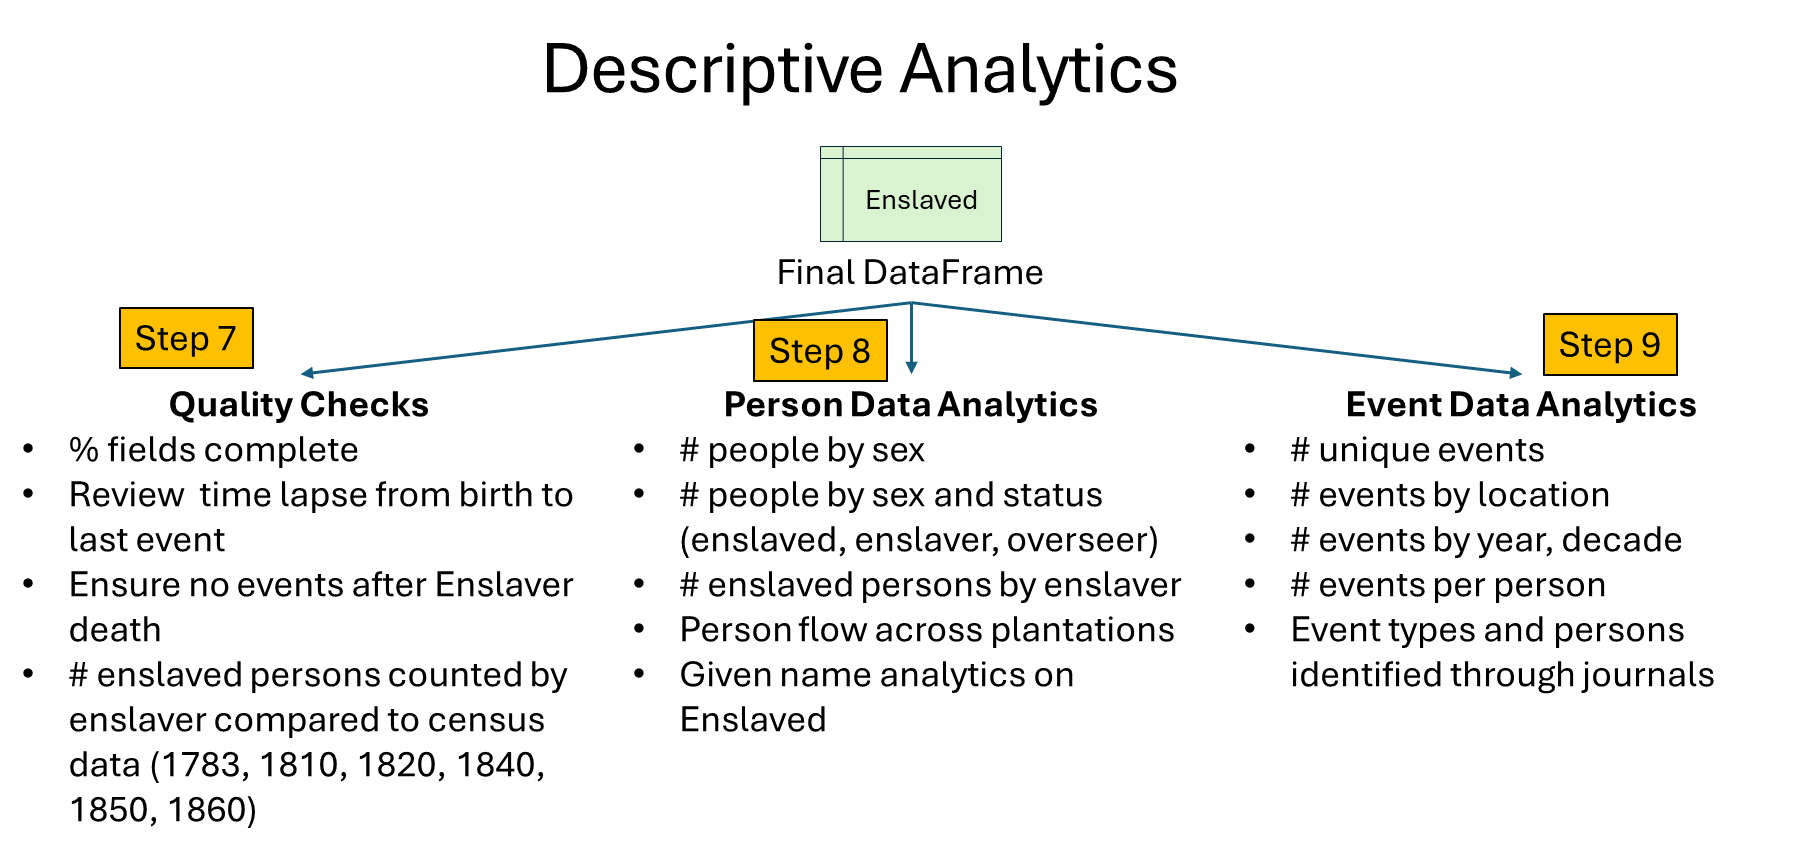

In [166]:
display.Image(filename="Descriptive Anal.png", width=1000, height=1000)

## Quality Checks

### Data Field Completeness of Person Data

In [169]:
print("The percent empty each field is")
enslaved.notnull().sum()/len(enslaved) * 100

The percent empty each field is


Person                100.000000
Given Name            100.000000
Alternate Name         11.551239
Surname                27.165857
Sex                   100.000000
RN                    100.000000
Birthyear             100.000000
Birth date            100.000000
Deathyear               6.976744
Death date              8.995656
Father                 21.032456
Mother                 31.638129
Spouses                28.826987
Children               28.264758
Event ID               97.188858
Event Type             97.188858
Place                  97.163302
Status                100.000000
Role                   97.188858
Enslaver ID            95.502172
Date                   97.188858
Year                   97.188858
Description            97.188858
Overseers              61.972911
Source                 97.188858
Source Description     74.214158
Page                   43.853821
Repository             72.450805
dtype: float64

<Axes: >

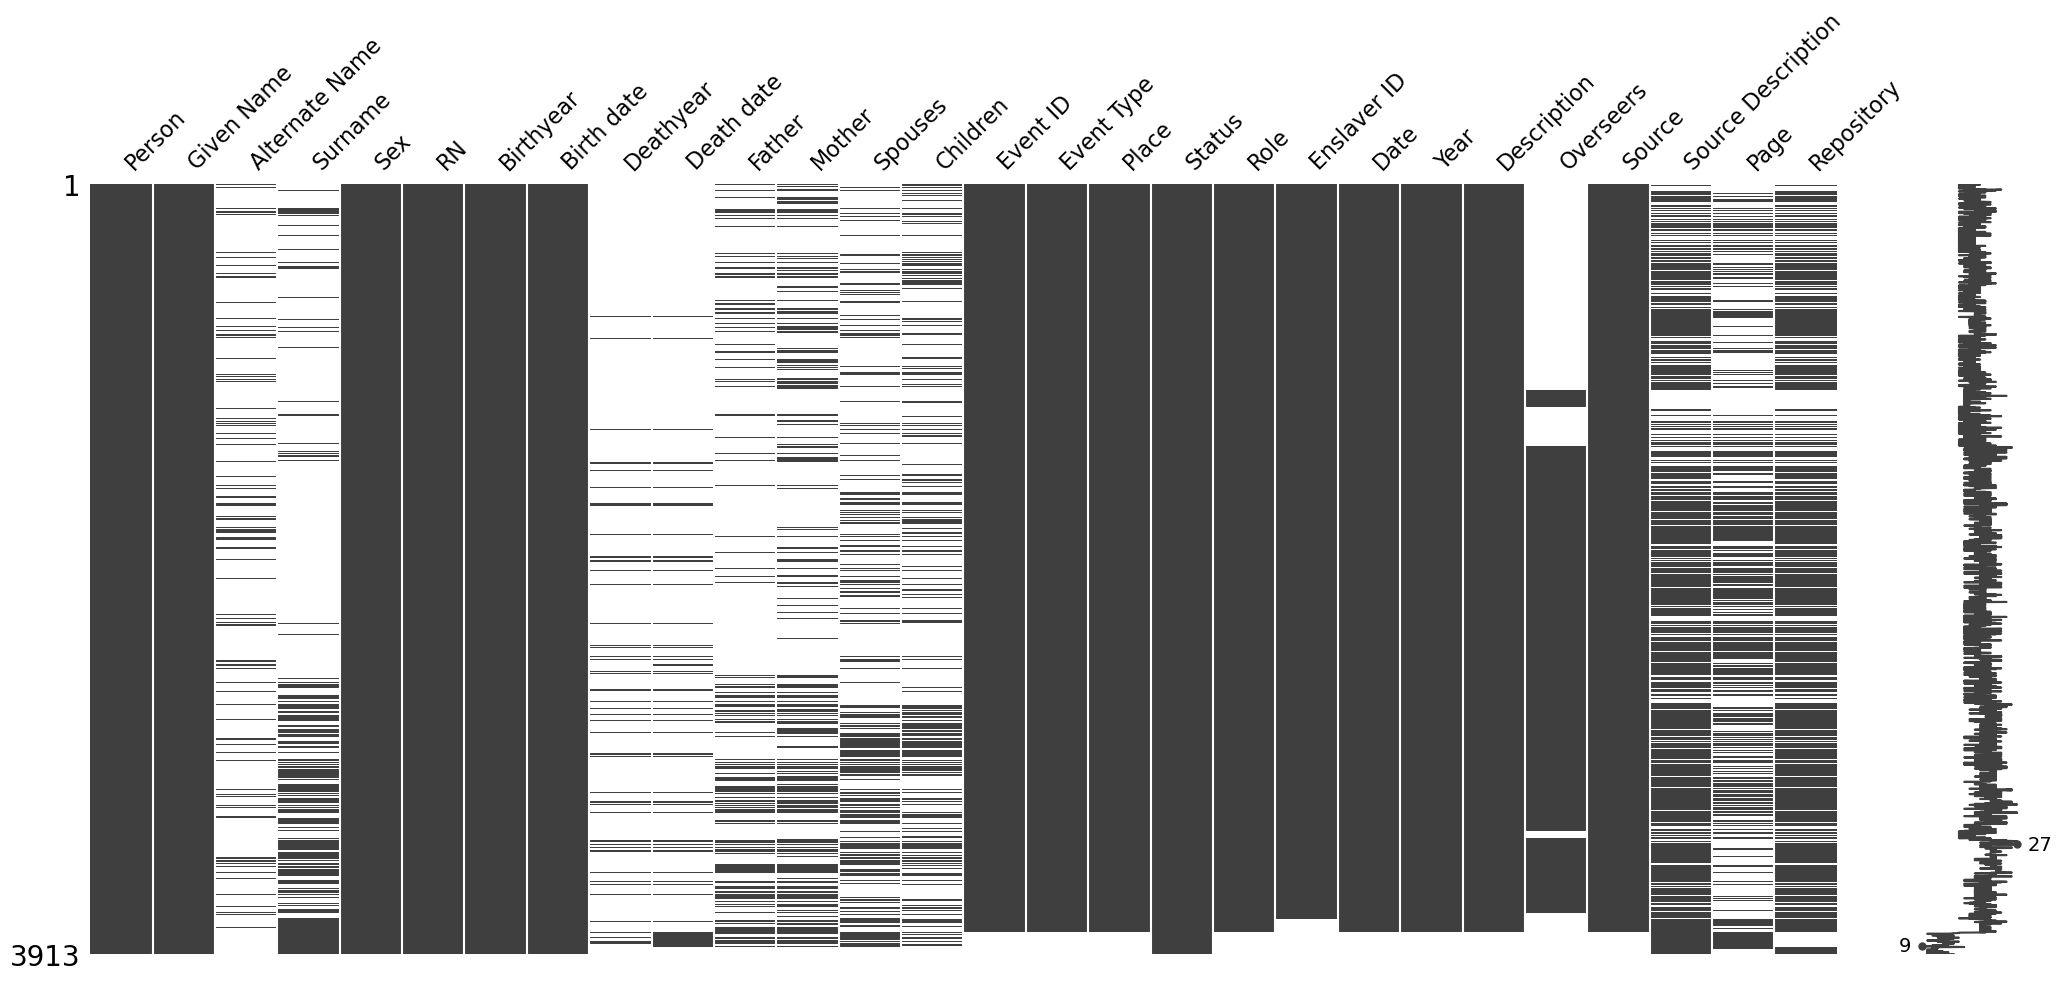

In [170]:
msno.matrix(enslaved)

In [171]:
Persons = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children']]
print(Persons.shape)
Persons = Persons.drop_duplicates()
print(Persons.shape)
Persons.head()

(3913, 12)
(820, 12)


Person Given Name     Alternate Name Surname Sex   RN Birth date  \
0   PERS-CAB-74-UH       Will       Creasy's boy     NaN   M   74  1781-1-15   
1  PERS-CAB-259-UH        Sam                NaN     NaN   M  259       1793   
2   PERS-CAB-78-UH       Cate  Creasy's daughter     NaN   F   78  1783-11-5   
3   PERS-CAB-97-UH     George                NaN     NaN   M   97   bef 1762   
4  PERS-CAB-916-UH     Edward                NaN     NaN   M  916   bef 1841   

  Death date           Father          Mother          Spouses  \
0        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH              NaN   
1        NaN              NaN             NaN              NaN   
2        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH              NaN   
3        NaN   PERS-CAB-14-UH   PERS-CAB-1-UH  PERS-CAB-615-UH   
4        NaN              NaN             NaN              NaN   

          Children  
0              NaN  
1              NaN  
2  PERS-CAB-620-UH  
3  PERS-CAB-619-UH  
4              NaN

### Time lapse from birth to last event

In [173]:
test=enslaved[['RN','Birthyear','Year','Death date','Event Type', 'Event ID']]
test= test.drop_duplicates().dropna()
print(test.shape)
test.head()

(277, 6)


RN Birthyear    Year  Death date Event Type     Event ID
39   651      1810  1858.0        1858   Enslaved  EVE-ENS-013
40   651      1810  1863.0        1858    Auction  EVE-AUC-002
41   651      1810  1863.0        1858   Transfer  EVE-TFR-082
42   651      1810  1858.0        1858      Death  EVE-DEA-031
314  186      1785  1832.0  1851-11-12     Hiring  EVE-HIR-016

#### Review the events where a person was over 70

In [175]:
test['Birthyear'] = test['Birthyear'].astype(int)
test['Span'] = test['Year'] -test['Birthyear']
test=test.sort_values('Span').set_index('Span').loc[70:].reset_index()
test['RN'].drop_duplicates().tolist()

['14', '112', '191', '177', '163', '148', '194']

### Review Event dates after Enslaver death

In [177]:
### Col. William Cabell died in 1798, probate in 1800
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-43-UH']
df = df[df['Year'] >=1801]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [178]:
### William Cabell, Jr. died in 1822, probate in 1823
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-44-UH']
df = df[df['Year'] >=1824]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [179]:
### Samuel Jordan Cabell died in 1818, probate in 1818
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-272-UH']
df = df[df['Year'] >=1819]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [180]:
### Hector Cabell died in 1807, probate in 1807
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-271-UH']
df = df[df['Year'] >=1808]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

In [181]:
### SThomas Stanhope McClelland died in 1835
df = enslaved[enslaved['Enslaver ID']=='PERS-CAB-283-UH']
df = df[df['Year'] >=1836]
df['RN'].value_counts()

Series([], Name: count, dtype: int64)

### Review persons with just one event

In [183]:
test = enslaved[['RN','Given Name','Year','Enslaver ID','Event ID','Status']]
test = test[test['Status']=='Enslaved']
print(test.shape)

(3677, 6)


In [184]:
test.groupby(['RN'])['Event ID'].count().to_frame().reset_index().sort_values('Event ID').set_index('Event ID').loc[1].reset_index()

Event ID    RN
0         1  1031
1         1  1030
2         1  1029
3         1  1028
4         1  1026
5         1  1070

### Spot checks on grouping of people by event and compare to original text grouping

In [186]:
test = enslaved[['RN','Person','Given Name','Year','Enslaver ID','Event ID']]
print(test.shape)
test= test.dropna(subset=['Year'])
test= test.dropna(subset=['Enslaver ID'])
test = test.drop_duplicates()
print(test.shape)


(3913, 6)
(3737, 6)


In [187]:
#RES-015 should have 9 people
test[test['Event ID'] == 'EVE-RES-015']

RN           Person Given Name    Year      Enslaver ID     Event ID
3617  852  PERS-CAB-852-UH      Moses  1859.0  PERS-CAB-858-UH  EVE-RES-015
3639  321  PERS-CAB-321-UH    Harriet  1859.0  PERS-CAB-858-UH  EVE-RES-015
3640  312  PERS-CAB-312-UH    Winston  1859.0  PERS-CAB-858-UH  EVE-RES-015
3656  887  PERS-CAB-887-UH        Ned  1859.0  PERS-CAB-858-UH  EVE-RES-015
3678  821  PERS-CAB-821-UH     George  1859.0  PERS-CAB-858-UH  EVE-RES-015
3686  918  PERS-CAB-918-UH   Mordecai  1859.0  PERS-CAB-858-UH  EVE-RES-015
3696  847  PERS-CAB-847-UH      Henry  1859.0  PERS-CAB-858-UH  EVE-RES-015
3698  801  PERS-CAB-801-UH   Margaret  1859.0  PERS-CAB-858-UH  EVE-RES-015
3700  791  PERS-CAB-791-UH        Pat  1859.0  PERS-CAB-858-UH  EVE-RES-015

#### Spot check on Prefix and Suffix addition

In [189]:
test[test['RN'] == '725']

RN           Person Given Name    Year       Enslaver ID     Event ID
311   725  PERS-CAB-725-UH      Susan  1823.0  PERS-CAB-1065-UH  EVE-ENS-009
316   725  PERS-CAB-725-UH      Susan  1823.0  PERS-CAB-1065-UH  EVE-PRO-021
442   725  PERS-CAB-725-UH      Susan  1862.0  PERS-CAB-1088-UH  EVE-AUC-001
485   725  PERS-CAB-725-UH      Susan  1857.0  PERS-CAB-1088-UH  EVE-CRT-006
492   725  PERS-CAB-725-UH      Susan  1862.0  PERS-CAB-1088-UH  EVE-TFR-077
499   725  PERS-CAB-725-UH      Susan  1846.0  PERS-CAB-1088-UH  EVE-ENS-010
701   725  PERS-CAB-725-UH      Susan  1862.0  PERS-CAB-1275-UH  EVE-ENS-083
1117  725  PERS-CAB-725-UH      Susan  1818.0   PERS-CAB-272-UH  EVE-ENS-008

## Person Analytics

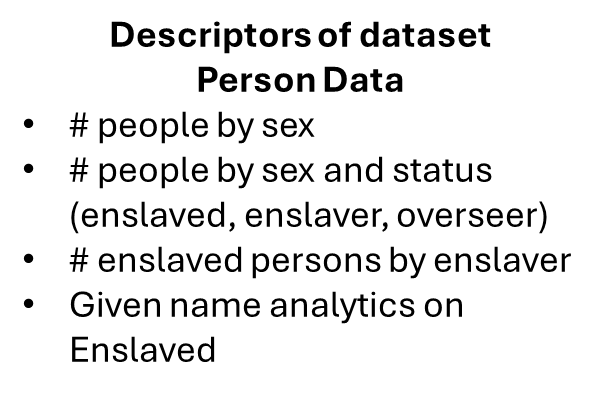

In [191]:
display.Image(filename="People.png", width=300, height=300)

### Total number of people

In [193]:
enslaved['RN'].nunique()

820

### Total number of unique persons by sex

In [195]:
enslaved.groupby(['Sex'])['RN'].nunique().to_frame().reset_index()

Sex   RN
0   ?   18
1   F  322
2   M  480

### Total number of unique persons by status and sex

In [197]:
enslaved.groupby(['Status'])['RN'].nunique().to_frame().reset_index()


Status   RN
0  Enslaved  663
1  Enslaver  110
2      Free   93

In [198]:
enslaved.groupby(['Status','Sex'])['RN'].nunique().to_frame().reset_index()

Status Sex   RN
0  Enslaved   ?   18
1  Enslaved   F  292
2  Enslaved   M  353
3  Enslaver   F   30
4  Enslaver   M   80
5      Free   F   22
6      Free   M   71

#### Earliest birth year and range of birth years for enslaved persons

In [200]:
a = enslaved[['RN','Given Name','Birthyear','Status']]
a = a[a['Status']=='Enslaved']
a= a[['RN','Given Name','Birthyear']]
a= a.drop_duplicates()
a['Birthyear'] = a['Birthyear'].astype(int)
z= a[a['Birthyear']<1800]
print("the number born before 1800 is", z.shape)
print(a.shape)
#a['Year'] = (((a['Birthyear'])*2).round(-1)/2).astype(int)
a['Year'] = ((a['Birthyear']).round(-1).astype(int))
a.groupby(['Year'])['RN'].nunique()

the number born before 1800 is (311, 3)
(663, 3)


Year
1700      1
1710      1
1720      4
1730      2
1740      8
1750      4
1760     46
1770     37
1780    115
1790     59
1800     79
1810     19
1820     68
1830     53
1840     82
1850     50
1860     35
Name: RN, dtype: int64

Text(0.5, 0, 'Year')

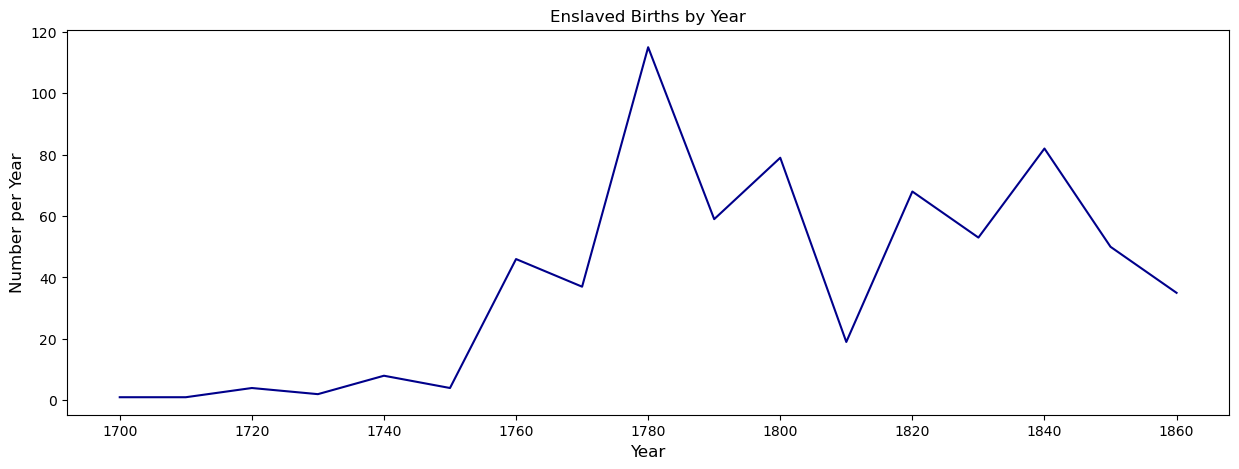

In [201]:
b = a.groupby(['Year'])['RN'].nunique().to_frame().reset_index()
b = b.rename(columns={'RN':'Births'}).set_index('Year')

fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(111)

ax1.plot(b['Births'],color='darkblue')
plt.title('Enslaved Births by Year', fontsize=12)
plt.ylabel('Number per Year', fontsize=12)
plt.xlabel('Year', fontsize=12)


### Number of enslaved by major enslaver 

In [203]:
Enslavers = [43,44,45,46,207,216,262,265,268,269,271,272,276,277,280,282,283,677,680,866,857,858,866,919,1034,1065,1088,1320]
UHEnslaved = enslaved[['RN','Enslaver ID','Status','Source','Event Type','Event ID']]
print(UHEnslaved.shape)
UHEnslaved = UHEnslaved.drop_duplicates()
print(UHEnslaved.shape)
UHEnslaved = UHEnslaved.sort_values('Status').set_index('Status').loc['Enslaved'].reset_index().drop(columns={'Status'})
UHEnslaved['Enslaver ID'] = UHEnslaved['Enslaver ID'].replace(regex=[r'\D+'], value=" ")
UHEnslaved['Enslaver ID'] = UHEnslaved['Enslaver ID'].astype(int)
UHEnslaved = UHEnslaved[UHEnslaved['Enslaver ID'].isin(Enslavers)] 
print(UHEnslaved.shape)
UHEnslaved.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().rename(columns={'RN':'Number'}).sort_values(['Enslaver ID']).set_index(['Enslaver ID'])


(3913, 6)
(3913, 6)
(3523, 5)


Number
Enslaver ID        
43              194
44              147
45              145
46               11
207              16
216              27
262              10
265               4
269              36
271              28
272              75
276              19
277              12
280              32
282              16
283              35
677               5
680               4
857              59
858              23
866               8
919               3
1034             28
1065            102
1088            104
1320             22

### number of events by enslaver

In [205]:
UHEnslaved =UHEnslaved[ UHEnslaved['Event Type']!='Enslaved']
print(UHEnslaved.shape)
UHEnslaved.groupby(['Enslaver ID'])['Event ID'].nunique().to_frame().reset_index().rename(columns={'Event ID':'Events'}).sort_values(['Enslaver ID']).set_index(['Enslaver ID'])


(2422, 5)


Events
Enslaver ID        
43              139
44               41
45              120
46                1
207               7
216               8
265               1
269               1
271               3
272               4
276               2
280               1
282               1
283               7
857             100
858              18
866               1
919               1
1034              9
1065             22
1088             34
1320              2

### Plantations and Enslavers per enslaved person

In [207]:
# of places lived per person across all data
places  = enslaved[['RN','Event ID','Enslaver ID','Status','Place']]
print(places.shape)
places = places[places['Status']=='Enslaved']
places['Enslaver ID'] = places['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
print("The mean number of places an enslaved person lived is", places.groupby(['RN'])['Place'].nunique().mean().round(2))
print("The number of enslaved persons living at more than 3 locations is", len(places.groupby(['RN'])['Place'].nunique().to_frame().reset_index().sort_values('Place').set_index('Place').loc[3:].reset_index().sort_values('RN')))   
print("The number of enslavec persons living under 3 or more enslavers is", len(places.groupby(['RN'])['Enslaver ID'].nunique().to_frame().reset_index().sort_values('Enslaver ID').set_index('Enslaver ID').loc[3:].reset_index().sort_values('RN')))

(3913, 5)
The mean number of places an enslaved person lived is 1.6
The number of enslaved persons living at more than 3 locations is 73
The number of enslavec persons living under 3 or more enslavers is 170


### Number of enslaved persons across multiple generations of Union Hill enslavers

### Define the Enslavers- Any Cabell family member whether a Union Hill plantation owner or not plus the non-Cabell Union Hill plantation owneres

In [210]:
Enslavers = [43,44,45,46,207,216,262,265,268,269,271,272,276,277,280,282,283,677,680,866,857,858,866,919,1034,1065,1088,1320]

### Where did enslaved of Col. William Cabell go?

In [212]:
whereto = enslaved[['RN','Enslaver ID','Status']]
whereto = whereto[whereto['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates()
whereto['Enslaver ID'] = whereto['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
whereto['RN'] = whereto['RN'].astype(int)

In [213]:
#Down select to enslaver of choice
a = whereto[whereto['Enslaver ID'] ==43]
a = a[['RN','Enslaver ID']].sort_values('RN').drop_duplicates()
print(a.shape)
#create list for look up
Cabell = a['RN'].tolist()
#go back to original df and extract people from that enslaver
df = enslaved[enslaved['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
df['RN'] = df['RN'].astype(int)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
df =df[df['RN'].isin(Cabell)]
df1 = df.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().sort_values('RN',ascending=False)
df1.head(15)

(194, 2)


Enslaver ID   RN
1            43  194
2            44   68
15          269   36
16          271   15
0             0   13
17          272   12
26         1065    8
3            45    7
13          262    7
8           131    5
11          207    4
4            46    4
7           126    4
14          265    3
18          276    3

### Where did enslaved of William Cabell Jr go?

In [215]:
#Down select to enslaver of choice
a = whereto[whereto['Enslaver ID'] ==44]
a = a[['RN','Enslaver ID']].sort_values('RN').drop_duplicates()
#create list for look up
Cabell = whereto['RN'].tolist()
#go back to original df and extract people from that enslaver
df = enslaved[enslaved['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
df['RN'] = df['RN'].astype(int)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)

df =df[df['RN'].isin(Cabell)]
df1 = df.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().sort_values('RN',ascending=False)
df1.head(20)

Enslaver ID   RN
1            43  194
2            44  147
3            45  145
50         1088  104
49         1065  102
21          272   75
38          857   59
19          269   36
27          283   35
24          280   32
20          271   28
47         1034   28
16          216   27
0             0   26
39          858   23
81         1320   22
22          276   19
13          207   16
26          282   16
23          277   12

### Where did enslaved of Mayo Cabell go?

In [217]:
a = whereto[whereto['Enslaver ID'] ==45]
a = a[['RN','Enslaver ID']].sort_values('RN').drop_duplicates()
#create list for look up
Cabell = whereto['RN'].tolist()
#go back to original df and extract people from that enslaver
df = enslaved[enslaved['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
df['RN'] = df['RN'].astype(int)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").astype(int)
df =df[df['RN'].isin(Cabell)]
df1 = df.groupby(['Enslaver ID'])['RN'].nunique().to_frame().reset_index().sort_values('RN',ascending=False)
df1.head(15)

Enslaver ID   RN
1            43  194
2            44  147
3            45  145
50         1088  104
49         1065  102
21          272   75
38          857   59
19          269   36
27          283   35
24          280   32
20          271   28
47         1034   28
16          216   27
0             0   26
39          858   23

## Enslaved Given Name Analytics

In [219]:
names = enslaved[['RN','Given Name','Sex','Status','Place']]
names = names[names['Status'] == 'Enslaved'].reset_index().drop(columns={'Status'}).drop_duplicates().sort_values('RN')
names.groupby(['Sex'])['RN'].nunique()


Sex
?     18
F    292
M    353
Name: RN, dtype: int64

In [220]:
names = names.groupby(['Sex','Given Name'])['RN'].nunique().to_frame().reset_index()
names = names.sort_values(['Sex','RN'],ascending=False)
names[names['Sex']=='M'].head(10)

Sex Given Name  RN
316   M    Unknown  18
247   M       John  12
224   M     George  10
232   M      Henry  10
293   M        Sam   9
248   M     Jordan   8
320   M       Will   7
237   M      James   6
285   M     Reuben   6
167   M     Andrew   5

In [221]:
names[names['Sex']=='F'].head(15)

Sex Given Name  RN
108   F       Mary  11
117   F      Nancy  11
65    F      Fanny   8
96    F     Louisa   7
103   F   Margaret   7
155   F    Unknown   7
28    F      Betty   6
107   F     Martha   6
35    F  Charlotte   5
73    F     Hannah   5
81    F       Jane   5
100   F       Lucy   5
132   F      Polly   5
140   F      Sally   5
141   F      Sarah   5

In [222]:
surnames = enslaved[['RN','Surname','Status','Place']]
surnames = surnames[surnames['Status'] == 'Enslaved']
surnames.groupby(['Surname'])['RN'].nunique().to_frame().reset_index().sort_values('RN', ascending=False)

Surname  RN
11       Hatcher  16
1          Banks  15
13       Jackson  10
10     Hartgrove  10
2        Bolling   8
14      Jemmeson   7
21          Rose   6
25       Trotter   5
19       Madison   4
27       Winslow   3
28       Woodson   2
23         Smith   2
20      Randolph   1
0             B.   1
18         Lewis   1
24       Spencer   1
26         Watts   1
22        Seyton   1
15      Jemmison   1
17          King   1
16       Johnson   1
12  Higginbotham   1
9       Franklin   1
8        Fleming   1
7          Estis   1
6          Early   1
5          Davis   1
4         Cabell   1
3         Booker   1
29        Yancey   1

#### Number of enslaved with surames

In [224]:
df = surnames[surnames['Surname'].notna()]
df['RN'].nunique()

106

## Event Analytics

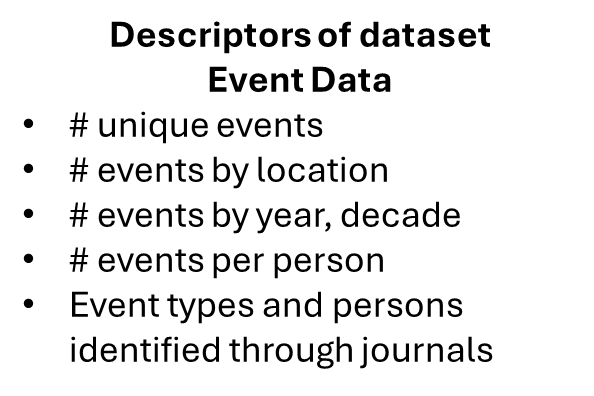

In [226]:
display.Image(filename="Events.png", width=400, height=400)

### Number of unique events

In [228]:
df = enslaved[enslaved['Event Type']!='Enslaved']
df['Event ID'].nunique()

596

### Total number of events by place

In [230]:
df.groupby(['Place'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID',ascending=False).head(15)

Place  Event ID
29                    Union Hill       277
22                       Norwood        90
7                       Colleton        87
28                 Soldier's Joy        65
18                     Montezuma        23
15  Lovingston, Nelson, Virginia        13
3                       Benvenue        11
31        Williamsburg, Virginia         4
0                        Amherst         3
2                        Belmont         3
9                       Glenmore         3
14                  Liberty Hall         3
25            Richmond, Virginia         2
24    Philadelphia, Pennsylvania         2
23                     Parsonage         1

### Number of events per person - People with more than 10 events

### number of people in this dataset

In [233]:
df['RN'].nunique()

819

### Number of enslaved with more than 10 events

In [235]:
df.groupby(['RN'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID').set_index('Event ID').loc[10:].reset_index().shape


(61, 2)

### Number of enslaved with just one event

In [237]:
df.groupby(['RN'])['Event ID'].nunique().to_frame().reset_index().sort_values('Event ID').set_index('Event ID').loc[:1].reset_index().shape


(374, 2)

### Events per person average

In [239]:
df.groupby(['RN'])['Event ID'].nunique().mean()

3.120879120879121

### Events by Decade across Plantations

Text(0.5, 0, 'Year')

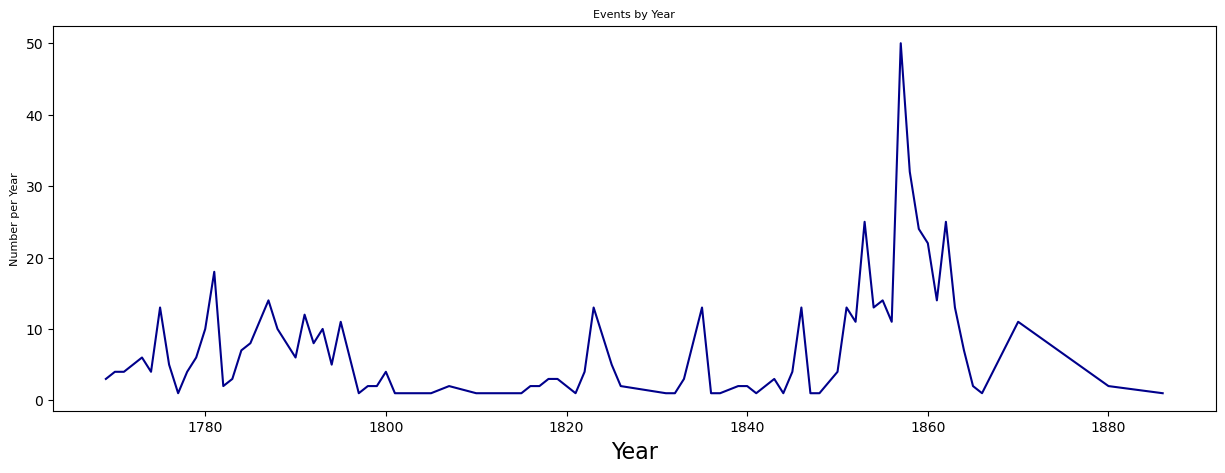

In [241]:
events = df.groupby(['Year'])['Event ID'].nunique().to_frame().reset_index()
events = events.rename(columns={'Year':'Year','Event ID':'Events'}).set_index('Year')

fig1 = plt.figure(figsize=(15,5))
ax1 = fig1.add_subplot(111)

ax1.plot(events['Events'],color='darkblue')
plt.title('Events by Year', fontsize=8)
plt.ylabel('Number per Year', fontsize=8)
plt.xlabel('Year', fontsize=16)
#plt.xticks(np.arange(1750, 1870, 20))
#plt.annotate('1862', (1862,90), fontsize=12)

## Enslaved persons named by year 

In [243]:
shortlist = [43,44,45,46,268,269,271,272,280,283,857,858,1034,1065,1088,1320]
df = enslaved[enslaved['Event Type']!='Enslaved']
print(df.shape)
df = df[df['Status']!='Overseer']
print(df.shape)
df = df[df['Status']!='Enslaver']
print(df.shape)
df = df[df['Year']< 1870]
print(df.shape)
df = df[df['Year']> 1764]
print(df.shape)
df['Enslaver ID'] = df['Enslaver ID'].replace(regex=[r'\D+'], value=" ").fillna(0).astype(int)
df = df[df['Enslaver ID'].isin(shortlist)]
df['RN'] =df['RN'].astype(int)
print(df.shape)
print(df['RN'].nunique())
df.head(2)


(2666, 28)
(2666, 28)
(2556, 28)
(2518, 28)
(2518, 28)
(2415, 28)
701


Person Given Name Alternate Name   Surname Sex   RN Birthyear  \
26  PERS-CAB-661-UH     Sophia          Sophy       NaN   F  661      1805   
28  PERS-CAB-663-UH     Sawney            NaN  Jemmeson   M  663      1832   

   Birth date Deathyear Death date           Father           Mother  \
26   abt 1805       NaN        NaN              NaN              NaN   
28   abt 1832       NaN        NaN  PERS-CAB-647-UH  PERS-CAB-661-UH   

             Spouses                                           Children  \
26   PERS-CAB-647-UH                    PERS-CAB-662-UH,PERS-CAB-663-UH   
28  PERS-CAB-1032-UH  PERS-CAB-1335-UH,PERS-CAB-1336-UH,PERS-CAB-133...   

       Event ID Event Type      Place    Status              Role  \
26  EVE-AUC-002    Auction  Montezuma  Enslaved  Auctioned person   
28  EVE-CRT-001      Court  Montezuma  Enslaved     Listed Person   

    Enslaver ID        Date    Year  \
26         1034  1863-09-18  1863.0   
28         1034  1859-11-15  1859.0   

                                          Description Overseers  Source  \
26  Valuable Lands for Sale. September, 1863, at p...       NaN    71.0   
28  James B. McClelland doth grant unto the said J...       NaN    61.0   

                                   Source Description Page  \
26  “Valuable Lands for Sale,” Richmond Times Disp...  NaN   
28  Deed of Trust for Benvenue Estate.Nelson Count...  137   

                                      Repository  
26   Newspapers.com (https://www.newspapers.com)  
28  Nelson County Circuit Court, Lovingston, Va.

### Sort data by Birthyear and assign new unique identifier through index for graphing purposes

In [245]:
newID = df[['RN','Birthyear']].astype(str)
newID= newID.drop_duplicates().sort_values('Birthyear').reset_index(drop=True).reset_index().rename(columns={'index':'ID'}).astype(int)
print(newID.shape)
print(newID['Birthyear'].max())
print(newID['Birthyear'].min())
newID= newID.sort_values('RN').set_index('RN')

(701, 3)
1864
1705


### Change Enslaver ID for graphing purposes

#### Renumber the enslaver ID to help with graphing by color 


In [248]:
a = df[['RN','Year','Enslaver ID']].sort_values('RN').set_index('RN')
a= a.join(newID).reset_index()
a['Year'] = a['Year'].astype(int)
a= a.sort_values('Year')
#Union Hill, Colleton and Norwood enslavers
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 43, value=10)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 269, value=11)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 44, value=12)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 46, value=13)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 45, value=14)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 857, value=15)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 858, value=16)

#Montezuma enslavers
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 271, value=20)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 280, value=21)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 283, value=22)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1034, value=23)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1320, value=24)

#Soldier's Joy enslavers
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 272, value=30)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1065, value=31)
a['Enslaver ID'] = a['Enslaver ID'].replace(to_replace= 1088, value=32)

a['Enslaver ID'] = a['Enslaver ID'].astype(int)
a.head(10)

RN  Year  Enslaver ID   ID  Birthyear
153  27  1769           10   38       1755
201  53  1769           10  114       1769
37    7  1769           10   35       1755
66    8  1769           10   33       1755
158  28  1770           10   45       1757
117  17  1770           10   69       1760
116  17  1770           10   69       1760
28    5  1770           10   63       1760
30    5  1770           10   63       1760
31    6  1770           10   58       1760

In [249]:
sns.color_palette('Greens_r',4) #Union Hill Colleton Norwood

[(0.08235294117647059, 0.49803921568627446, 0.23137254901960783),
 (0.29490196078431374, 0.6901960784313725, 0.38431372549019605),
 (0.596078431372549, 0.8345098039215686, 0.5788235294117647),
 (0.8274509803921569, 0.9325490196078431, 0.8031372549019608)]

In [250]:
print(sns.color_palette("Greens_r",4).as_hex())

['#157f3b', '#4bb062', '#98d594', '#d3eecd']


In [251]:
sns.color_palette('Oranges_r',4) #Soldier's Joy

[(0.7709803921568628, 0.2541176470588235, 0.007058823529411764),
 (0.9545098039215686, 0.44, 0.10666666666666666),
 (0.9921568627450981, 0.6564705882352941, 0.3827450980392157),
 (0.9937254901960785, 0.8501960784313726, 0.7043137254901961)]

In [252]:
print(sns.color_palette("Oranges_r",4).as_hex())

['#c54102', '#f3701b', '#fda762', '#fdd9b4']


In [253]:
sns.color_palette('Blues_r',6) #Montezuma

[(0.044059976931949255, 0.3338869665513264, 0.6244521337946944),
 (0.16696655132641294, 0.48069204152249134, 0.7291503267973857),
 (0.3262898885044214, 0.6186236063052672, 0.802798923490965),
 (0.5356862745098039, 0.746082276047674, 0.8642522106881968),
 (0.7309496347558632, 0.8394771241830065, 0.9213225682429834),
 (0.8584083044982699, 0.9134486735870818, 0.9645674740484429)]

In [254]:
print(sns.color_palette("Blues_r",6).as_hex())

['#0b559f', '#2b7bba', '#539ecd', '#89bedc', '#bad6eb', '#dbe9f6']


#### Fillin the blank years with NaN values

In [256]:
df2 = pd.DataFrame({'Year':range(1765,1865), 'Enslaver ID':np.NaN, 'ID':np.NaN})
a= pd.concat([a,df2]).sort_values('Year')
a= a.sample(frac=1) #shuffle the rows so the dots are randomly inserted on the graph
a.head()

RN  Year  Enslaver ID     ID  Birthyear
535    168.0  1796         12.0  152.0     1777.0
2235  1157.0  1846         32.0  586.0     1840.0
961    321.0  1858         16.0  464.0     1822.0
885    304.0  1823         12.0  428.0     1816.0
10       NaN  1775          NaN    NaN        NaN

C:\Users\kathe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
C:\Users\kathe\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


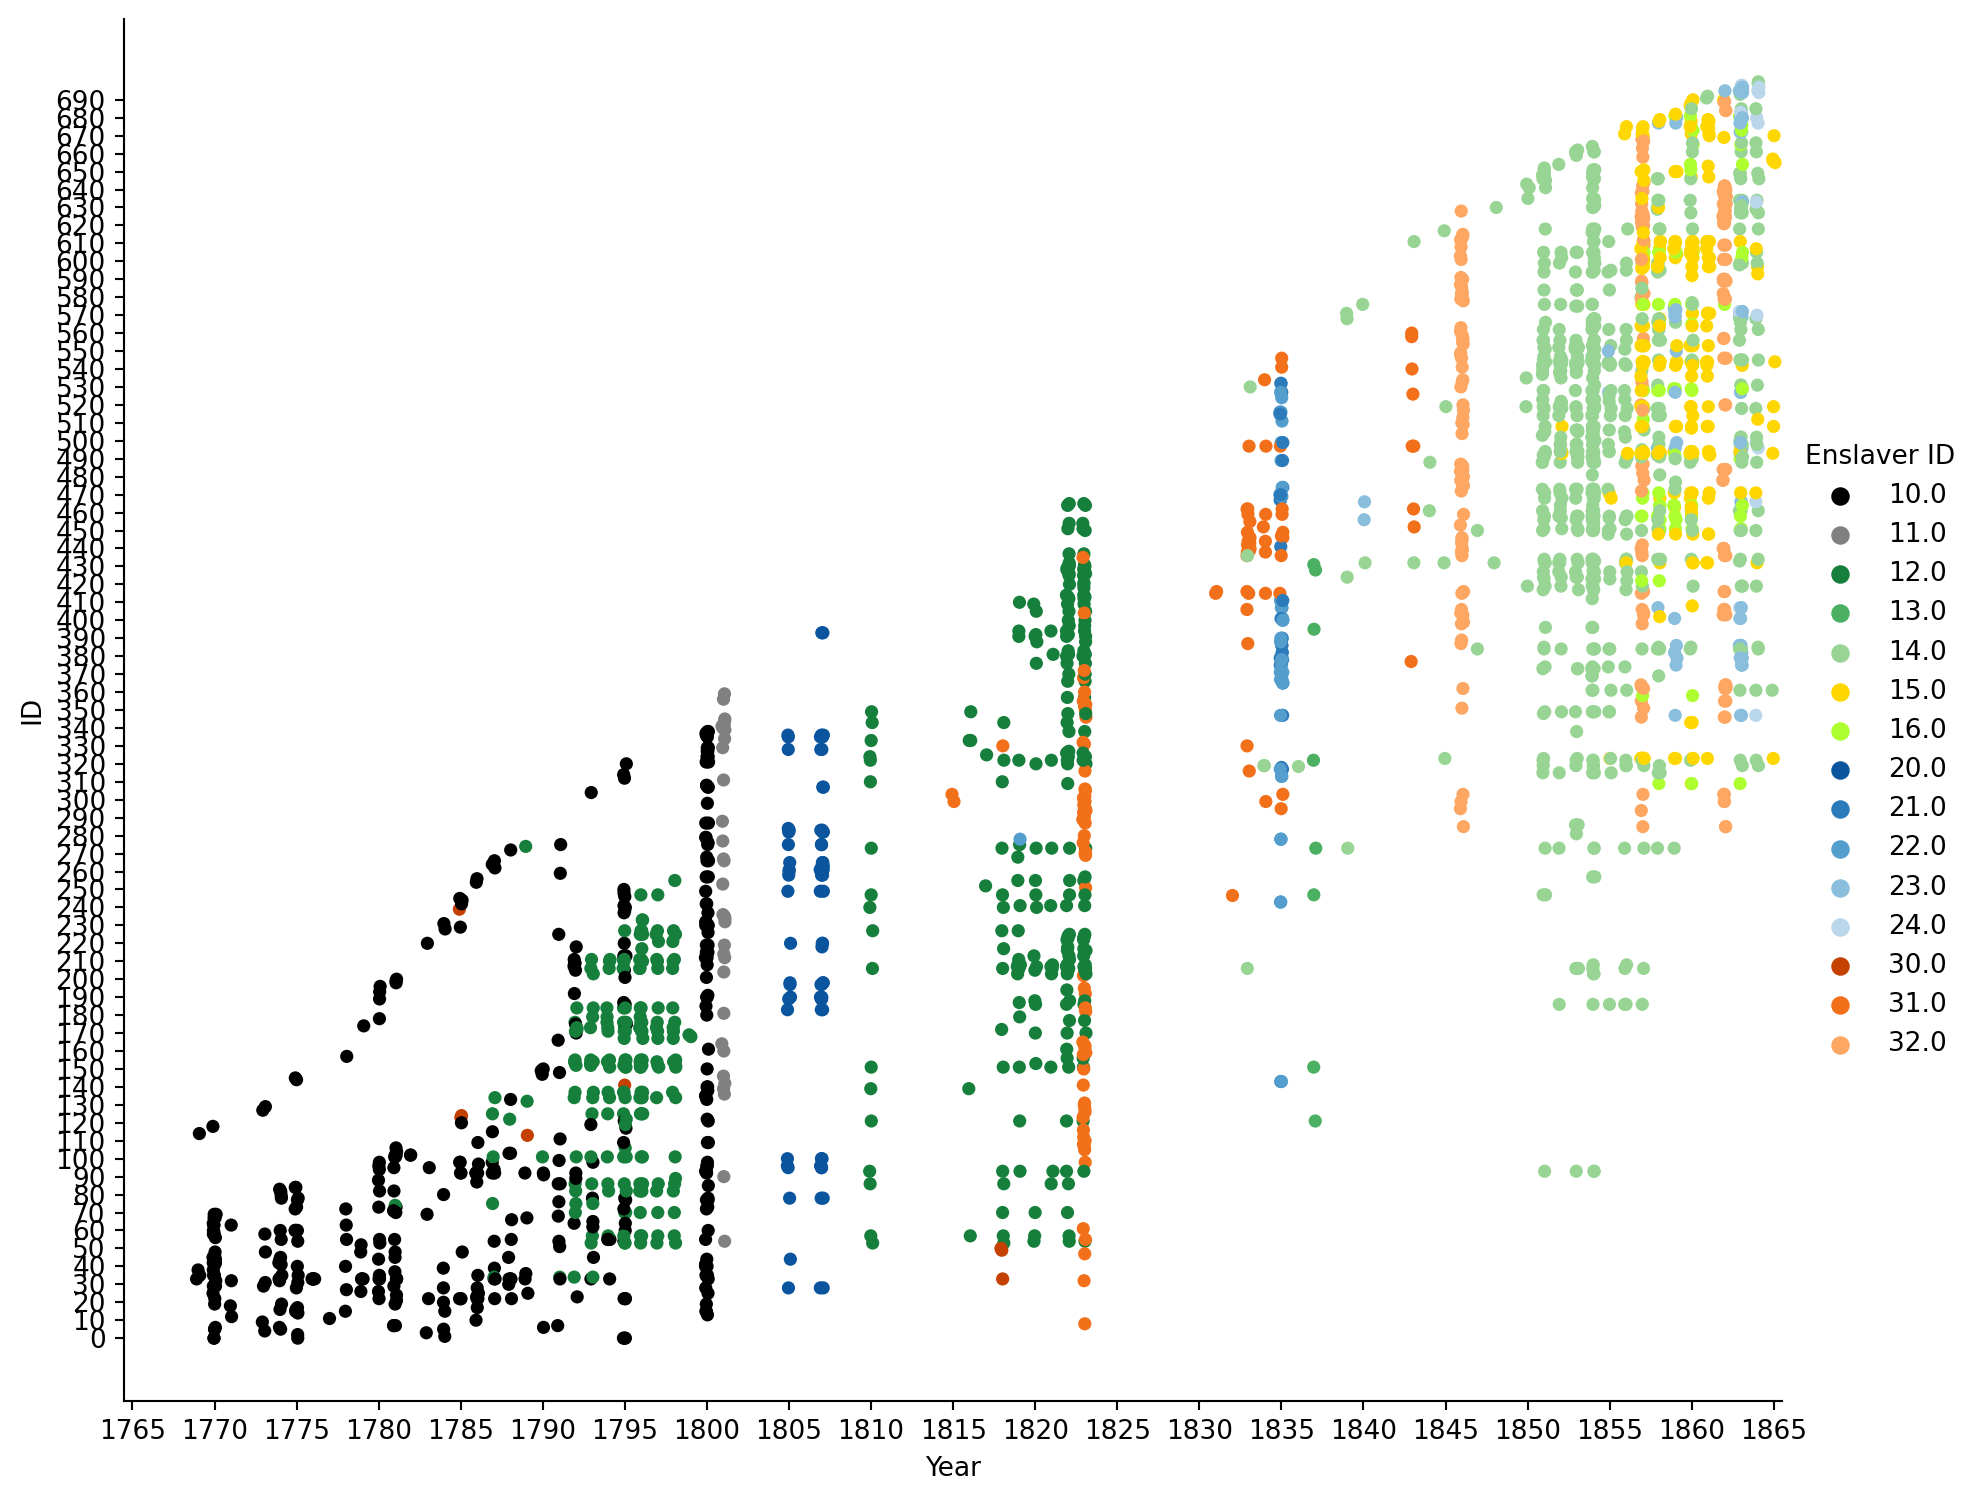

In [257]:
plt.rcParams.update({"figure.dpi": 190})

g= sns.catplot(data=a, x="Year", y="ID", hue="Enslaver ID", height = 8, aspect =1.2, palette=(['black','gray','#157f3b', '#4bb062', '#98d594','gold','greenyellow',   '#0b559f', '#2b7bba', '#539ecd', '#89bedc', '#bad6eb',    '#c54102', '#f3701b', '#fda762']))
g.set(xlabel ="Year")
g.set(yticks=np.arange(0,700,10))
g.set(xticks=np.arange(0,105,5))
g.savefig("EXPORTgraph.png")

#### Get Y-axis values by birth date- not individual number

In [259]:
dates = a.sort_values('ID').drop(columns={'RN','Enslaver ID','Year'}).drop_duplicates()
dates['ID'] =dates['ID']/10
dates['test'] = dates['ID'].apply(lambda x: x.is_integer())
dates = dates[dates['test'] != False]
dates['ID'] =dates['ID']*10
dates= dates[['ID','Birthyear']].sort_values('ID').set_index('ID')
dates 

Birthyear
ID              
0.0       1705.0
10.0      1740.0
20.0      1745.0
30.0      1754.0
40.0      1756.0
50.0      1758.0
60.0      1760.0
70.0      1760.0
80.0      1764.0
90.0      1765.0
100.0     1767.0
110.0     1768.0
120.0     1770.0
130.0     1773.0
140.0     1775.0
150.0     1777.0
160.0     1778.0
170.0     1779.0
180.0     1780.0
190.0     1780.0
200.0     1781.0
210.0     1782.0
220.0     1783.0
230.0     1784.0
240.0     1785.0
250.0     1785.0
260.0     1787.0
270.0     1788.0
280.0     1790.0
290.0     1793.0
300.0     1793.0
310.0     1794.0
320.0     1795.0
330.0     1798.0
340.0     1798.0
350.0     1800.0
360.0     1800.0
370.0     1800.0
380.0     1803.0
390.0     1805.0
400.0     1810.0
410.0     1813.0
420.0     1815.0
430.0     1816.0
440.0     1820.0
450.0     1820.0
460.0     1820.0
470.0     1825.0
480.0     1826.0
490.0     1827.0
500.0     1830.0
510.0     1830.0
520.0     1832.0
530.0     1833.0
540.0     1835.0
550.0     1835.0
560.0     1837.0
570.0     1839.0
580.0     1840.0
590.0     1840.0
600.0     1841.0
610.0     1842.0
620.0     1846.0
630.0     1848.0
640.0     1850.0
650.0     1851.0
660.0     1853.0
670.0     1855.0
680.0     1859.0
690.0     1860.0
700.0     1864.0

## People at Plantations by Decade and Losses of persons over time

### Convert the Event Date to datetime to order events correctly

In [262]:
test = enslaved.copy()
#make a copy 
test = test[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birthyear','Deathyear','Father','Mother','Spouses','Children','Event ID','Event Type','Place','Status','Role','Enslaver ID','Date','Year']]
print(test.shape)
#downselect to just the enslaved
test = test[test['Status']!= 'Enslaver']
test = test[test['Status']!= 'Overseer']

test['Date'] = pd.to_datetime(test['Date'],dayfirst=False, yearfirst=True,format='mixed')

#narrow down to just birth and death year
test[['Birthyear', 'Year']] = test[['Birthyear', 'Year']].astype(int)
test[['Deathyear']] = test[['Deathyear']].astype(float)

test= test[test['Year']<=1865]

print(test.shape)
test.head()

(3913, 20)
(3762, 20)


Person Given Name     Alternate Name Surname Sex   RN  Birthyear  \
0   PERS-CAB-74-UH       Will       Creasy's boy     NaN   M   74       1781   
1  PERS-CAB-259-UH        Sam                NaN     NaN   M  259       1793   
2   PERS-CAB-78-UH       Cate  Creasy's daughter     NaN   F   78       1783   
3   PERS-CAB-97-UH     George                NaN     NaN   M   97       1762   
4  PERS-CAB-916-UH     Edward                NaN     NaN   M  916       1841   

   Deathyear           Father          Mother          Spouses  \
0        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH              NaN   
1        NaN              NaN             NaN              NaN   
2        NaN  PERS-CAB-613-UH  PERS-CAB-73-UH              NaN   
3        NaN   PERS-CAB-14-UH   PERS-CAB-1-UH  PERS-CAB-615-UH   
4        NaN              NaN             NaN              NaN   

          Children     Event ID Event Type    Place    Status  \
0              NaN  EVE-ENS-090   Enslaved  Unknown  Enslaved   
1              NaN  EVE-ENS-090   Enslaved  Unknown  Enslaved   
2  PERS-CAB-620-UH  EVE-ENS-090   Enslaved  Unknown  Enslaved   
3  PERS-CAB-619-UH  EVE-ENS-090   Enslaved  Unknown  Enslaved   
4              NaN  EVE-ENS-090   Enslaved  Unknown  Enslaved   

              Role    Enslaver ID       Date  Year  
0  Enslaved Person  PERS-CAB-0-UH 1808-01-01  1808  
1  Enslaved Person  PERS-CAB-0-UH 1808-01-01  1808  
2  Enslaved Person  PERS-CAB-0-UH 1808-01-01  1808  
3  Enslaved Person  PERS-CAB-0-UH 1808-01-01  1808  
4  Enslaved Person  PERS-CAB-0-UH 1859-01-02  1859

In [263]:
test['Enslaver ID'] = test['Enslaver ID'].replace(regex=[r'\D+'], value="")
test[['Enslaver ID','RN']] = test[['Enslaver ID','RN']].astype(float)

test= test.sort_values(['RN','Date'])
test= test[['RN','Date','Year','Birthyear','Deathyear','Event ID','Place','Event Type','Enslaver ID']]

test= test.drop_duplicates()
print(test.shape)
test.head()

(3762, 9)


RN       Date  Year  Birthyear  Deathyear     Event ID       Place  \
1409  1.0 1770-09-22  1770       1745        NaN  EVE-NEC-002    Colleton   
1723  1.0 1770-09-22  1770       1745        NaN  EVE-ENS-001    Colleton   
1719  1.0 1780-09-25  1780       1745        NaN  EVE-BIR-013  Union Hill   
1722  1.0 1783-11-05  1783       1745        NaN  EVE-BIR-017  Union Hill   
1718  1.0 1785-08-14  1785       1745        NaN  EVE-BIR-020  Union Hill   

       Event Type  Enslaver ID  
1409  Necessities         43.0  
1723     Enslaved         43.0  
1719        Birth         43.0  
1722        Birth         43.0  
1718        Birth         43.0

In [264]:
test = test.sort_values(['RN','Date','Event Type'])
test['Prev_ID'] = test.groupby(['RN'])['Enslaver ID'].shift(1).fillna(10000)

test['Next_ID'] = test.groupby(['RN'])['Enslaver ID'].shift(-1).fillna(10000)
test[['Prev_ID', 'Enslaver ID', 'Next_ID']] = test[['Prev_ID', 'Enslaver ID', 'Next_ID']].astype(float)
test = test[['RN','Date','Birthyear','Deathyear','Event ID','Place','Event Type','Year','Prev_ID','Enslaver ID','Next_ID']]

print(test.shape)
test.head(20)

(3762, 11)


RN       Date  Birthyear  Deathyear     Event ID       Place  \
1723  1.0 1770-09-22       1745        NaN  EVE-ENS-001    Colleton   
1409  1.0 1770-09-22       1745        NaN  EVE-NEC-002    Colleton   
1719  1.0 1780-09-25       1745        NaN  EVE-BIR-013  Union Hill   
1722  1.0 1783-11-05       1745        NaN  EVE-BIR-017  Union Hill   
1718  1.0 1785-08-14       1745        NaN  EVE-BIR-020  Union Hill   
1725  1.0 1785-09-22       1745        NaN  EVE-BIR-021  Union Hill   
1842  1.0 1785-10-22       1745        NaN  EVE-BIR-022  Union Hill   
1728  1.0 1786-01-08       1745        NaN  EVE-BIR-023  Union Hill   
1695  1.0 1786-05-17       1745        NaN  EVE-BIR-024  Union Hill   
1811  1.0 1787-03-03       1745        NaN  EVE-BIR-026  Union Hill   
1729  1.0 1788-01-25       1745        NaN  EVE-BIR-030  Union Hill   
1694  1.0 1795-07-25       1745        NaN  EVE-BIR-033  Union Hill   
1692  1.0 1795-08-07       1745        NaN  EVE-BIR-034  Union Hill   
1693  1.0 1795-12-29       1745        NaN  EVE-BIR-035  Union Hill   
1897  2.0 1780-09-25       1766        NaN  EVE-BIR-013  Union Hill   
1900  2.0 1780-09-25       1766        NaN  EVE-ENS-001  Union Hill   
1901  2.0 1800-01-01       1766        NaN  EVE-PRO-001  Union Hill   
1018  2.0 1800-01-02       1766        NaN  EVE-ENS-011   Montezuma   
1813  2.0 1800-01-02       1766        NaN  EVE-PRO-004  Union Hill   
1019  2.0 1805-05-17       1766        NaN  EVE-CRT-005   Montezuma   

       Event Type  Year  Prev_ID  Enslaver ID  Next_ID  
1723     Enslaved  1770  10000.0         43.0     43.0  
1409  Necessities  1770     43.0         43.0     43.0  
1719        Birth  1780     43.0         43.0     43.0  
1722        Birth  1783     43.0         43.0     43.0  
1718        Birth  1785     43.0         43.0     43.0  
1725        Birth  1785     43.0         43.0     43.0  
1842        Birth  1785     43.0         43.0     43.0  
1728        Birth  1786     43.0         43.0     43.0  
1695        Birth  1786     43.0         43.0     43.0  
1811        Birth  1787     43.0         43.0     43.0  
1729        Birth  1788     43.0         43.0     43.0  
1694        Birth  1795     43.0         43.0     43.0  
1692        Birth  1795     43.0         43.0     43.0  
1693        Birth  1795     43.0         43.0  10000.0  
1897        Birth  1780  10000.0         43.0     43.0  
1900     Enslaved  1780     43.0         43.0     43.0  
1901      Probate  1800     43.0         43.0    271.0  
1018     Enslaved  1800     43.0        271.0     43.0  
1813      Probate  1800    271.0         43.0    271.0  
1019        Court  1805     43.0        271.0    271.0

### Identify people with a documented birth date

In [266]:
people = test[test['Event Type']=='Birth'].sort_values('RN')
people= people[people['Year'] == people['Birthyear']]
people = people['RN'].drop_duplicates().to_list()
len(people)

65

In [267]:
#now distinguish off Union Hill plantations and within the plantations
test['IN'] = 'Existing Person'
test['IN'] = test['IN'].where(test['Prev_ID'] == test['Enslaver ID'],'Transferred In')
test['IN'] = test['IN'].where(test['Prev_ID'].isin(Enslavers),'Bought')
test['IN'] = test['IN'].where(test['Prev_ID'] !=10000, 'New Person')
test['IN'] = test['IN'].where(~test['RN'].isin(people), test['IN'].replace(to_replace='New Person', value='Birth'))
print(test.shape)
test.head(15)

(3762, 12)


RN       Date  Birthyear  Deathyear     Event ID       Place  \
1723  1.0 1770-09-22       1745        NaN  EVE-ENS-001    Colleton   
1409  1.0 1770-09-22       1745        NaN  EVE-NEC-002    Colleton   
1719  1.0 1780-09-25       1745        NaN  EVE-BIR-013  Union Hill   
1722  1.0 1783-11-05       1745        NaN  EVE-BIR-017  Union Hill   
1718  1.0 1785-08-14       1745        NaN  EVE-BIR-020  Union Hill   
1725  1.0 1785-09-22       1745        NaN  EVE-BIR-021  Union Hill   
1842  1.0 1785-10-22       1745        NaN  EVE-BIR-022  Union Hill   
1728  1.0 1786-01-08       1745        NaN  EVE-BIR-023  Union Hill   
1695  1.0 1786-05-17       1745        NaN  EVE-BIR-024  Union Hill   
1811  1.0 1787-03-03       1745        NaN  EVE-BIR-026  Union Hill   
1729  1.0 1788-01-25       1745        NaN  EVE-BIR-030  Union Hill   
1694  1.0 1795-07-25       1745        NaN  EVE-BIR-033  Union Hill   
1692  1.0 1795-08-07       1745        NaN  EVE-BIR-034  Union Hill   
1693  1.0 1795-12-29       1745        NaN  EVE-BIR-035  Union Hill   
1897  2.0 1780-09-25       1766        NaN  EVE-BIR-013  Union Hill   

       Event Type  Year  Prev_ID  Enslaver ID  Next_ID               IN  
1723     Enslaved  1770  10000.0         43.0     43.0       New Person  
1409  Necessities  1770     43.0         43.0     43.0  Existing Person  
1719        Birth  1780     43.0         43.0     43.0  Existing Person  
1722        Birth  1783     43.0         43.0     43.0  Existing Person  
1718        Birth  1785     43.0         43.0     43.0  Existing Person  
1725        Birth  1785     43.0         43.0     43.0  Existing Person  
1842        Birth  1785     43.0         43.0     43.0  Existing Person  
1728        Birth  1786     43.0         43.0     43.0  Existing Person  
1695        Birth  1786     43.0         43.0     43.0  Existing Person  
1811        Birth  1787     43.0         43.0     43.0  Existing Person  
1729        Birth  1788     43.0         43.0     43.0  Existing Person  
1694        Birth  1795     43.0         43.0     43.0  Existing Person  
1692        Birth  1795     43.0         43.0     43.0  Existing Person  
1693        Birth  1795     43.0         43.0  10000.0  Existing Person  
1897        Birth  1780  10000.0         43.0     43.0       New Person

In [268]:
test['IN'].value_counts()

IN
Existing Person    2256
Transferred In      719
New Person          661
Birth                65
Bought               61
Name: count, dtype: int64

### Identify people with a documented death date

In [270]:
people = test[test['Event Type']=='Death'].sort_values('RN')
people= people[people['Year'] == people['Deathyear']]
people = people['RN'].drop_duplicates().to_list()
len(people)

29

In [271]:
test['OUT'] = 'None'
test['OUT'] = test['OUT'].where(test['Next_ID']==test['Enslaver ID'],'Transferring Out')
test['OUT'] = test['OUT'].where(test['Next_ID'].isin(Enslavers),'Sold')
test['OUT'] = test['OUT'].where(test['Next_ID'] != 10000,'Last event')
test['OUT'] = test['OUT'].where(test['Event Type'] != 'Emancipation','Free')
test['OUT'] = test['OUT'].where(~test['RN'].isin(people), test['OUT'].replace(to_replace='Last event', value='Death'))
test['OUT'].value_counts()

OUT
None                2256
Last event           697
Transferring Out     636
Sold                 135
Death                 29
Free                   9
Name: count, dtype: int64

## Summary of In and OUT across the data set

In [273]:
test[test['IN']=='Bought'].drop_duplicates().groupby(['IN'])['RN'].nunique()


IN
Bought    51
Name: RN, dtype: int64

In [274]:
test[test['IN']=='Transferred In'].drop_duplicates().groupby(['IN'])['RN'].nunique()

IN
Transferred In    423
Name: RN, dtype: int64

In [275]:
test[test['IN']=='New Person'].drop_duplicates().groupby(['IN'])['RN'].nunique()

IN
New Person    645
Name: RN, dtype: int64

In [276]:
test[test['OUT']=='Free'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Free    9
Name: RN, dtype: int64

In [277]:
test[test['IN']=='Birth'].drop_duplicates().groupby(['IN'])['RN'].nunique()

IN
Birth    65
Name: RN, dtype: int64

In [278]:
test[test['OUT']=='Transferring Out'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Transferring Out    377
Name: RN, dtype: int64

In [279]:
test[test['OUT']=='Sold'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Sold    121
Name: RN, dtype: int64

In [280]:
test[test['OUT']=='Last event'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Last event    681
Name: RN, dtype: int64

In [281]:
test[test['OUT']=='Death'].drop_duplicates().groupby(['OUT'])['RN'].nunique()

OUT
Death    29
Name: RN, dtype: int64

### Summary data across all Union Hill Plantations - How Enslaved came on plantations

In [283]:
a= test.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = test.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year').fillna(0)

c = a.join(b)
c.head()


total  Birth  Bought  Existing Person  New Person  Transferred In
Year                                                                   
1765      1    0.0     0.0              0.0         1.0             0.0
1769      4    1.0     0.0              0.0         3.0             0.0
1770     26    1.0     0.0              2.0        23.0             0.0
1771      4    0.0     0.0              2.0         2.0             0.0
1773      8    2.0     0.0              3.0         3.0             0.0

In [284]:
a= test.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
e = test.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year').fillna(0)
f = a.join(e)
f.head()

total  Death  Free  Last event  None  Sold  Transferring Out
Year                                                              
1765      1    0.0   0.0         0.0   0.0   0.0               1.0
1769      4    0.0   0.0         1.0   3.0   0.0               0.0
1770     26    0.0   0.0         6.0  20.0   0.0               0.0
1771      4    0.0   0.0         2.0   2.0   0.0               0.0
1773      8    2.0   0.0         3.0   3.0   0.0               0.0

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


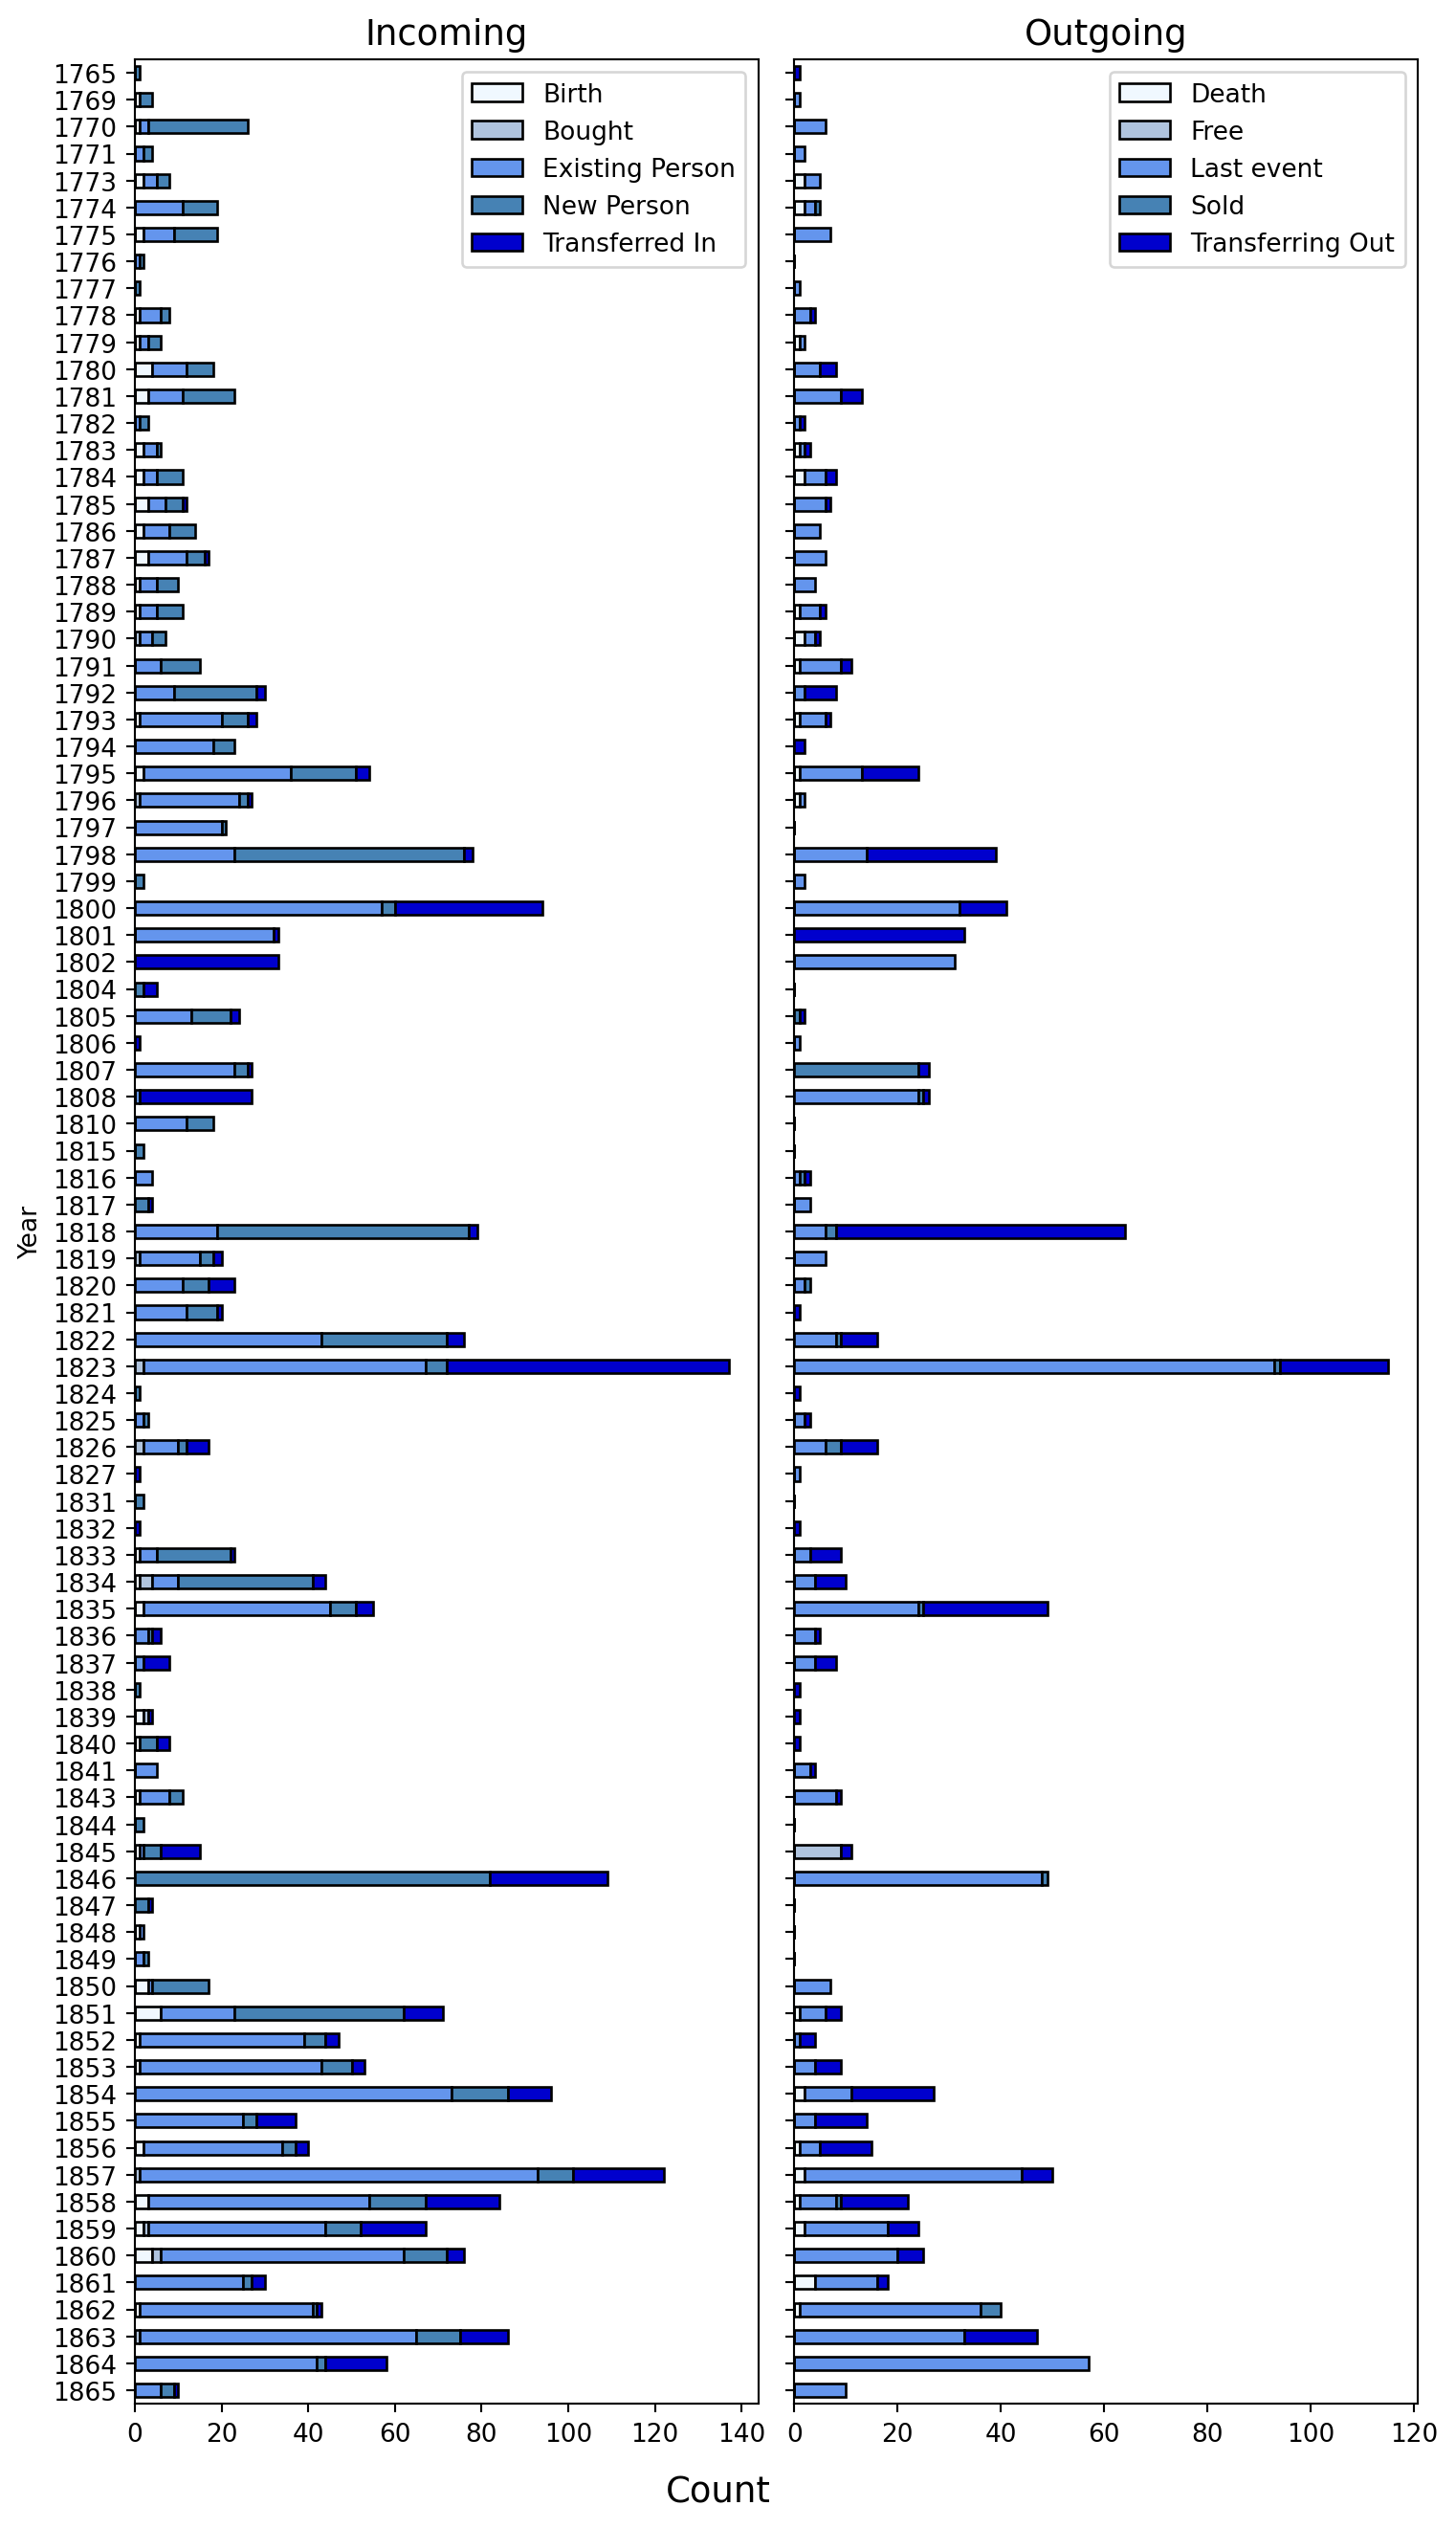

In [285]:
d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 14)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

### Try rounding to year 5-year intervals

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


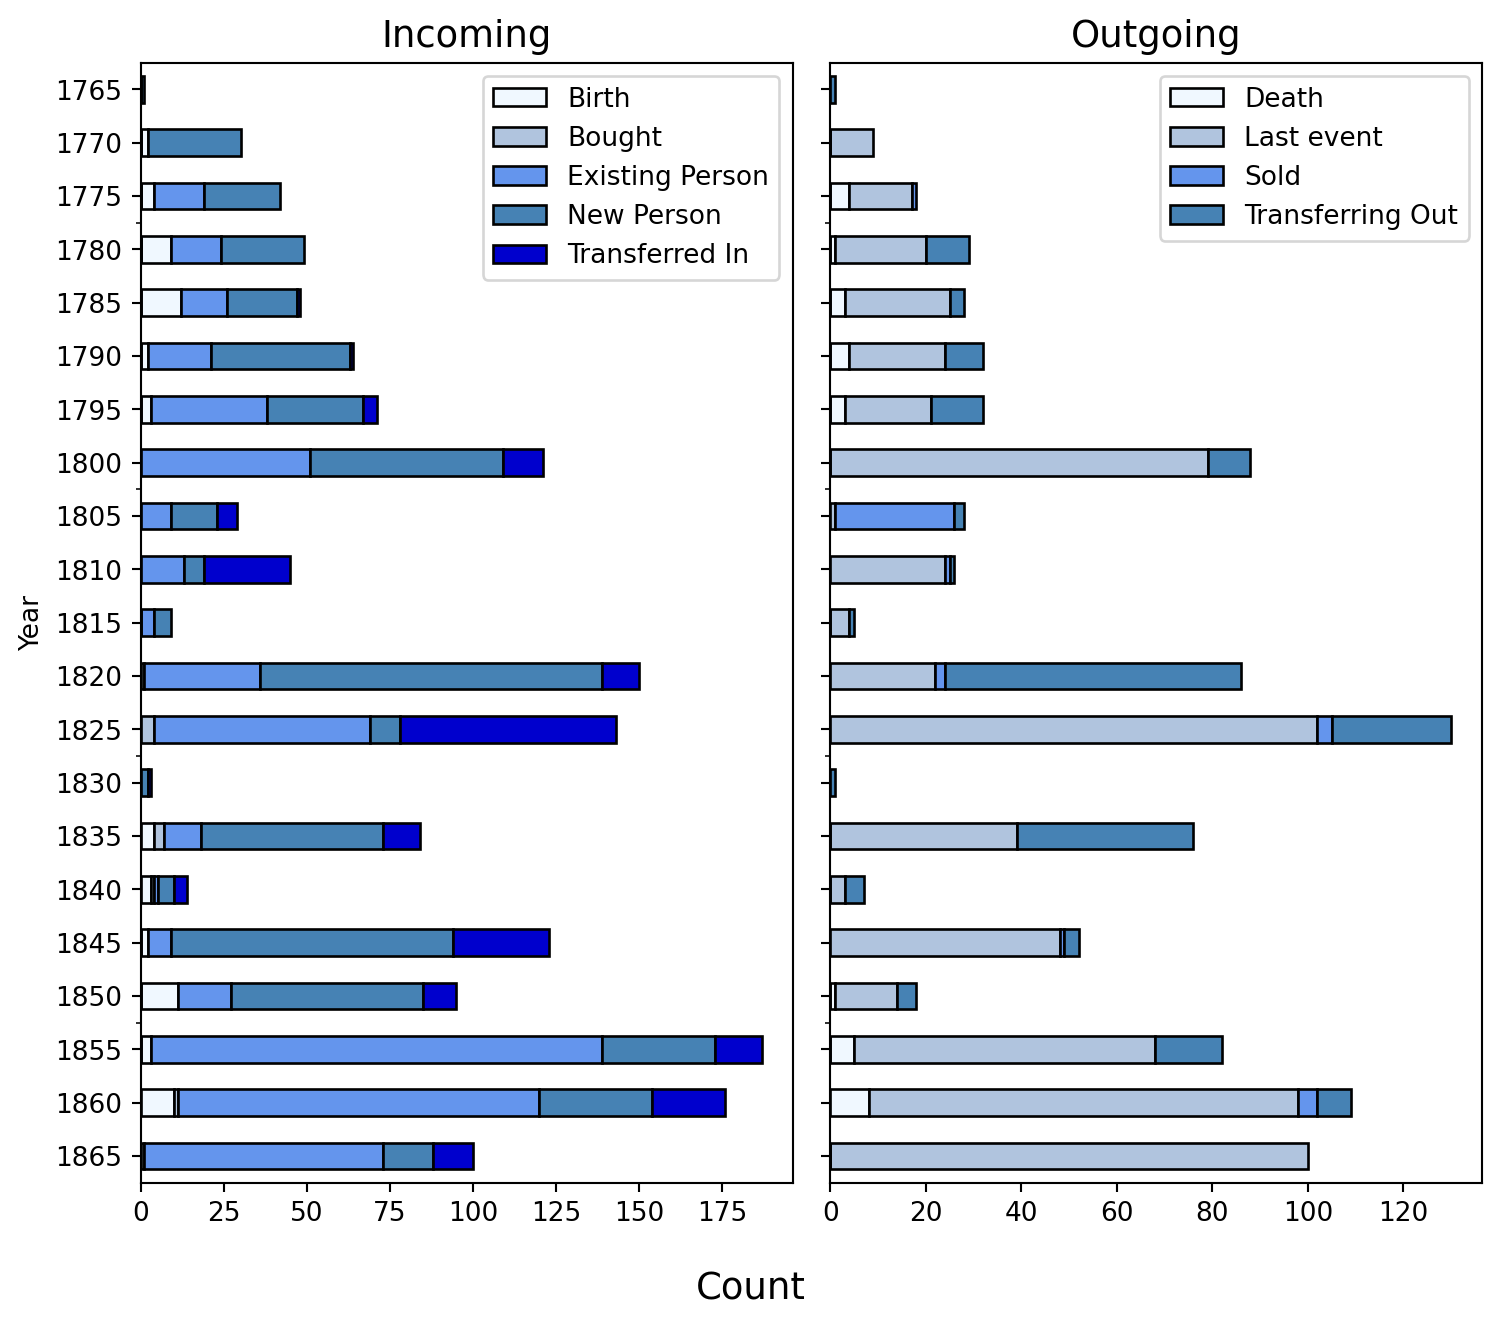

In [287]:
df= test.copy()
df['Year'] = (((df['Year'])*2).round(-1)/2).astype(int)

a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8,7)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

### Union Hill

In [289]:
df = test[test['Place']=='Union Hill']
people = df['RN'].drop_duplicates().tolist()
len(people)

UH = test[test['RN'].isin(people)]

UHenslavers=[43,44,45,46,269,207,282,866]
UH =test[test['RN'].isin(people)]
print(UH.shape)
UH = UH[UH['Enslaver ID'].isin(UHenslavers)]
UH = UH[UH['Year'] >= 1776]
print(UH['RN'].nunique())
UH.head()

(2462, 13)
388


RN       Date  Birthyear  Deathyear     Event ID       Place  \
1719  1.0 1780-09-25       1745        NaN  EVE-BIR-013  Union Hill   
1722  1.0 1783-11-05       1745        NaN  EVE-BIR-017  Union Hill   
1718  1.0 1785-08-14       1745        NaN  EVE-BIR-020  Union Hill   
1725  1.0 1785-09-22       1745        NaN  EVE-BIR-021  Union Hill   
1842  1.0 1785-10-22       1745        NaN  EVE-BIR-022  Union Hill   

     Event Type  Year  Prev_ID  Enslaver ID  Next_ID               IN   OUT  
1719      Birth  1780     43.0         43.0     43.0  Existing Person  None  
1722      Birth  1783     43.0         43.0     43.0  Existing Person  None  
1718      Birth  1785     43.0         43.0     43.0  Existing Person  None  
1725      Birth  1785     43.0         43.0     43.0  Existing Person  None  
1842      Birth  1785     43.0         43.0     43.0  Existing Person  None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


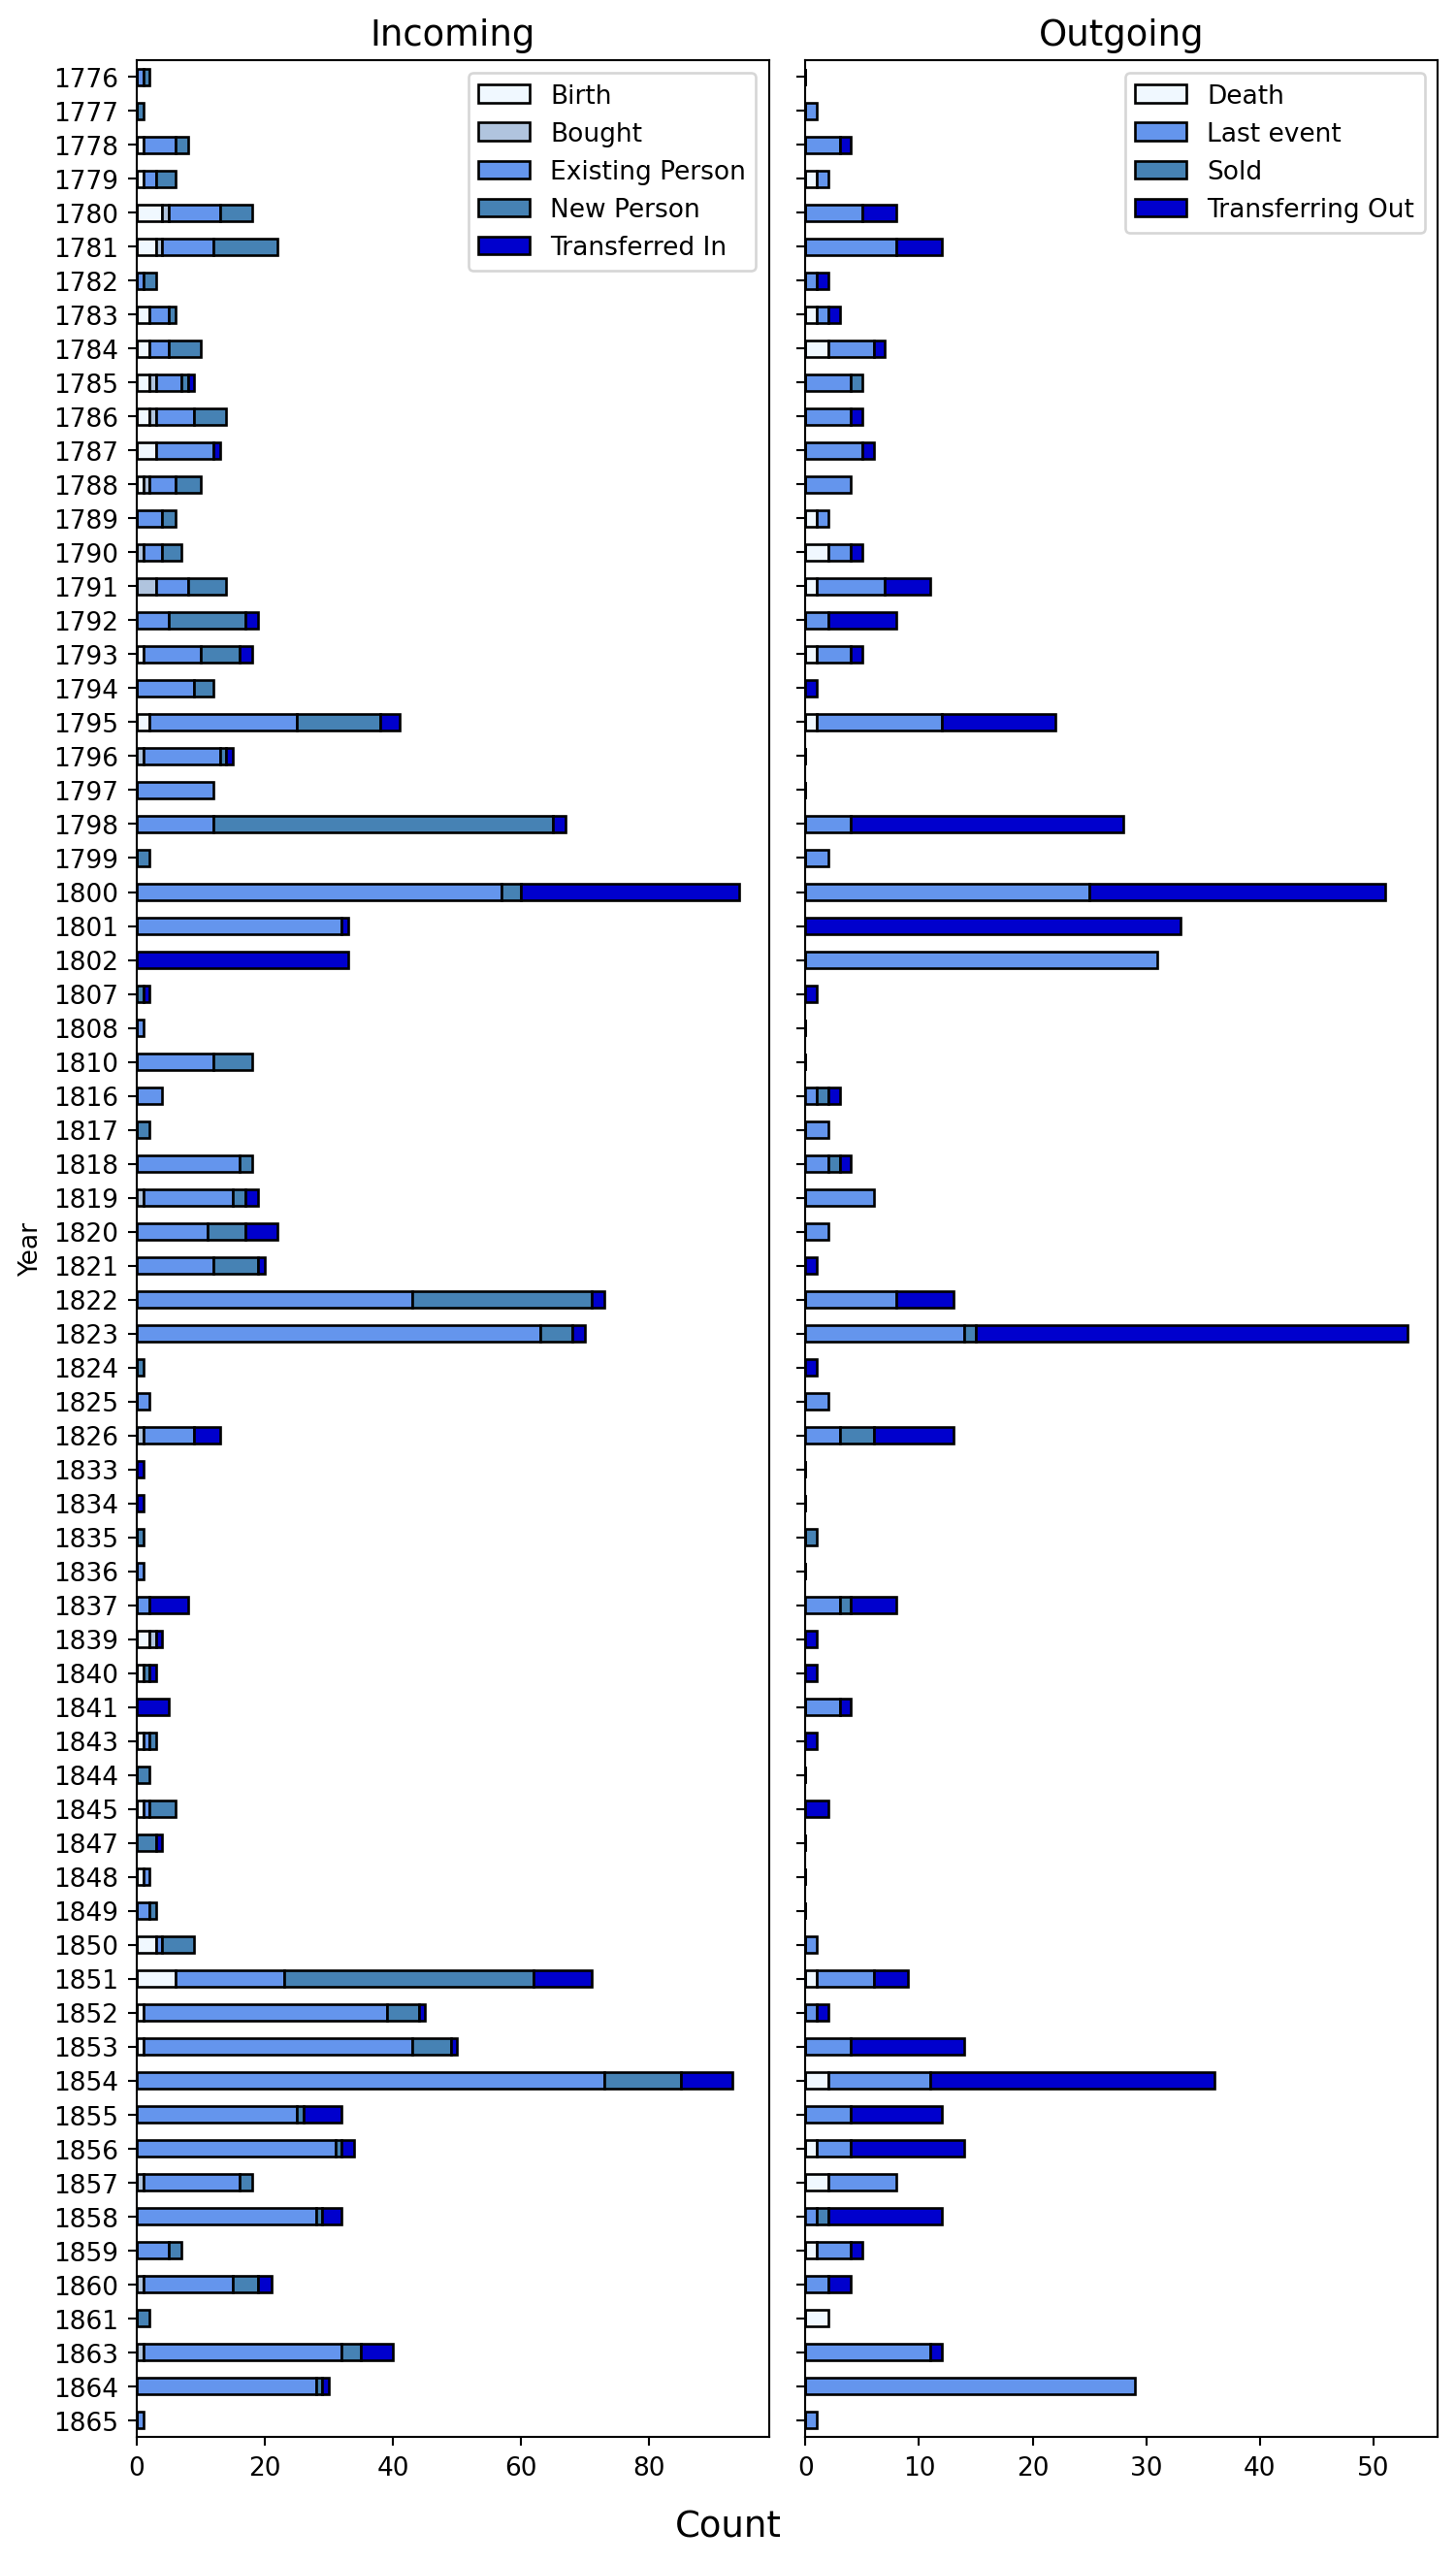

In [290]:
df= UH.copy()
#df['Year'] = (((df['Year'])*2).round(-1)/2).astype(int)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 14)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

### Round year to closest 5 year 

In [292]:
df= UH.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)

a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

total  Birth  Bought  Existing Person  New Person  Transferred In
Year                                                                     
1775.0      3    0.0     0.0              1.0         2.0             0.0
1780.0     48    9.0     2.0             15.0        22.0             0.0
1785.0     41   11.0     2.0             14.0        12.0             2.0
1790.0     50    1.0     5.0             16.0        27.0             1.0
1795.0     54    3.0     1.0             23.0        23.0             4.0
1800.0    110    0.0     0.0             40.0        58.0            12.0
1805.0      2    0.0     0.0              0.0         1.0             1.0
1810.0     19    0.0     0.0             13.0         6.0             0.0
1815.0      6    0.0     0.0              4.0         2.0             0.0
1820.0     86    0.0     1.0             32.0        45.0             8.0
1825.0     71    0.0     0.0             63.0         6.0             2.0
1835.0     11    0.0     0.0              2.0         1.0             8.0
1840.0     12    3.0     1.0              0.0         1.0             7.0
1845.0     14    2.0     0.0              1.0        10.0             1.0
1850.0     87   11.0     0.0             16.0        50.0            10.0
1855.0    113    1.0     1.0             81.0        22.0             8.0
1860.0     48    0.0     0.0             35.0         9.0             4.0
1865.0     42    0.0     1.0             31.0         4.0             6.0

In [293]:
f

total  Death  Last event  None  Sold  Transferring Out
Year                                                          
1775.0      3    0.0         1.0   2.0   0.0               0.0
1780.0     48    1.0        18.0  20.0   0.0               9.0
1785.0     41    3.0        18.0  15.0   1.0               4.0
1790.0     50    4.0        15.0  21.0   0.0              10.0
1795.0     54    2.0        14.0  28.0   0.0              10.0
1800.0    110    0.0        62.0  23.0   0.0              25.0
1805.0      2    0.0         0.0   1.0   0.0               1.0
1810.0     19    0.0         0.0  19.0   0.0               0.0
1815.0      6    0.0         3.0   1.0   1.0               1.0
1820.0     86    0.0        18.0  62.0   1.0               5.0
1825.0     71    0.0        19.0   7.0   3.0              42.0
1835.0     11    0.0         3.0   2.0   2.0               4.0
1840.0     12    0.0         3.0   6.0   0.0               3.0
1845.0     14    0.0         0.0  11.0   0.0               3.0
1850.0     87    1.0         7.0  75.0   0.0               4.0
1855.0    113    5.0        26.0  38.0   0.0              44.0
1860.0     48    3.0         6.0  27.0   1.0              11.0
1865.0     42    0.0        41.0   0.0   0.0               1.0

### Enslaved by Enslaver for 5 year intervals at Union Hill

In [295]:
df= UH.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1775.0 43.0             3
1780.0 43.0            47
       44.0             5
1785.0 43.0            40
       44.0             2
1790.0 43.0            44
       44.0             7
1795.0 43.0            35
       44.0            21
1800.0 43.0            85
       44.0            63
       269.0           36
1805.0 44.0             1
       46.0             1
1810.0 44.0            19
1815.0 44.0             6
1820.0 44.0            86
       45.0             1
1825.0 44.0            64
       45.0            10
       46.0             9
       207.0           16
       282.0           16
1835.0 45.0             9
       46.0             8
1840.0 45.0            12
1845.0 45.0            14
1850.0 45.0            87
1855.0 45.0           113
       866.0            8
1860.0 45.0            47
       866.0            1
1865.0 45.0            42

In [296]:
df= UH.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1780 43.0            67
     44.0             5
1790 43.0            66
     44.0            16
1800 43.0           104
     44.0            69
     269.0           36
1810 44.0            20
     46.0             1
1820 44.0            92
     45.0            10
     46.0             8
     207.0           14
     282.0           16
1830 45.0             3
     46.0             1
     207.0            2
     282.0           13
1840 45.0            27
     46.0             8
1850 45.0           118
     866.0            8
1860 45.0            91
     866.0            1

#### Soldier's Joy

In [298]:
df = test[test['Place']=="Soldier's Joy"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
#SJenslavers=[272,735,1061,1062,1065,1088,1275,1278]
NonSJenslavers=[43,44,45,46,139, 187,207,262,276,892,735,1062,1129,1132, 1133, 1134, 1136,1137,1138,1147,1151,1154,1267,1268,1269,1270,1271,1272,1273,1274,1283,1284,1285,1286,1287,1288,1289]
SJ =test[test['RN'].isin(people)]
print(SJ.shape)
SJ =SJ[~SJ['Enslaver ID'].isin(NonSJenslavers)]
print(SJ.shape)
SJ.head(10)

189
(834, 13)
(640, 13)


RN       Date  Birthyear  Deathyear      Event ID          Place  \
768    8.0 1769-06-04       1755        NaN   EVE-ENS-093            NaN   
1057   8.0 1800-01-03       1755        NaN   EVE-ENS-008  Soldier's Joy   
1063   8.0 1818-06-04       1755        NaN  EVE-WILL-017  Soldier's Joy   
233   13.0 1823-01-01       1755        NaN   EVE-ENS-009  Soldier's Joy   
231   13.0 1823-11-24       1755        NaN   EVE-PRO-018  Soldier's Joy   
1101  34.0 1800-01-03       1760        NaN   EVE-ENS-008  Soldier's Joy   
141   34.0 1823-01-01       1760        NaN   EVE-ENS-009  Soldier's Joy   
221   34.0 1823-11-24       1760        NaN   EVE-PRO-020  Soldier's Joy   
1122  68.0 1800-01-03       1766        NaN   EVE-ENS-008  Soldier's Joy   
151   68.0 1823-01-01       1766        NaN   EVE-ENS-009  Soldier's Joy   

     Event Type  Year  Prev_ID  Enslaver ID  Next_ID               IN  \
768    Enslaved  1769  10000.0       1342.0     43.0       New Person   
1057   Enslaved  1800     43.0        272.0    272.0   Transferred In   
1063       Will  1818    272.0        272.0    735.0  Existing Person   
233    Enslaved  1823   1062.0       1065.0   1065.0           Bought   
231     Probate  1823   1065.0       1065.0  10000.0  Existing Person   
1101   Enslaved  1800     43.0        272.0   1065.0   Transferred In   
141    Enslaved  1823    272.0       1065.0   1065.0   Transferred In   
221     Probate  1823   1065.0       1065.0  10000.0  Existing Person   
1122   Enslaved  1800     43.0        272.0   1065.0   Transferred In   
151    Enslaved  1823    272.0       1065.0   1065.0   Transferred In   

                   OUT  
768   Transferring Out  
1057              None  
1063              Sold  
233               None  
231         Last event  
1101  Transferring Out  
141               None  
221         Last event  
1122  Transferring Out  
151               None

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


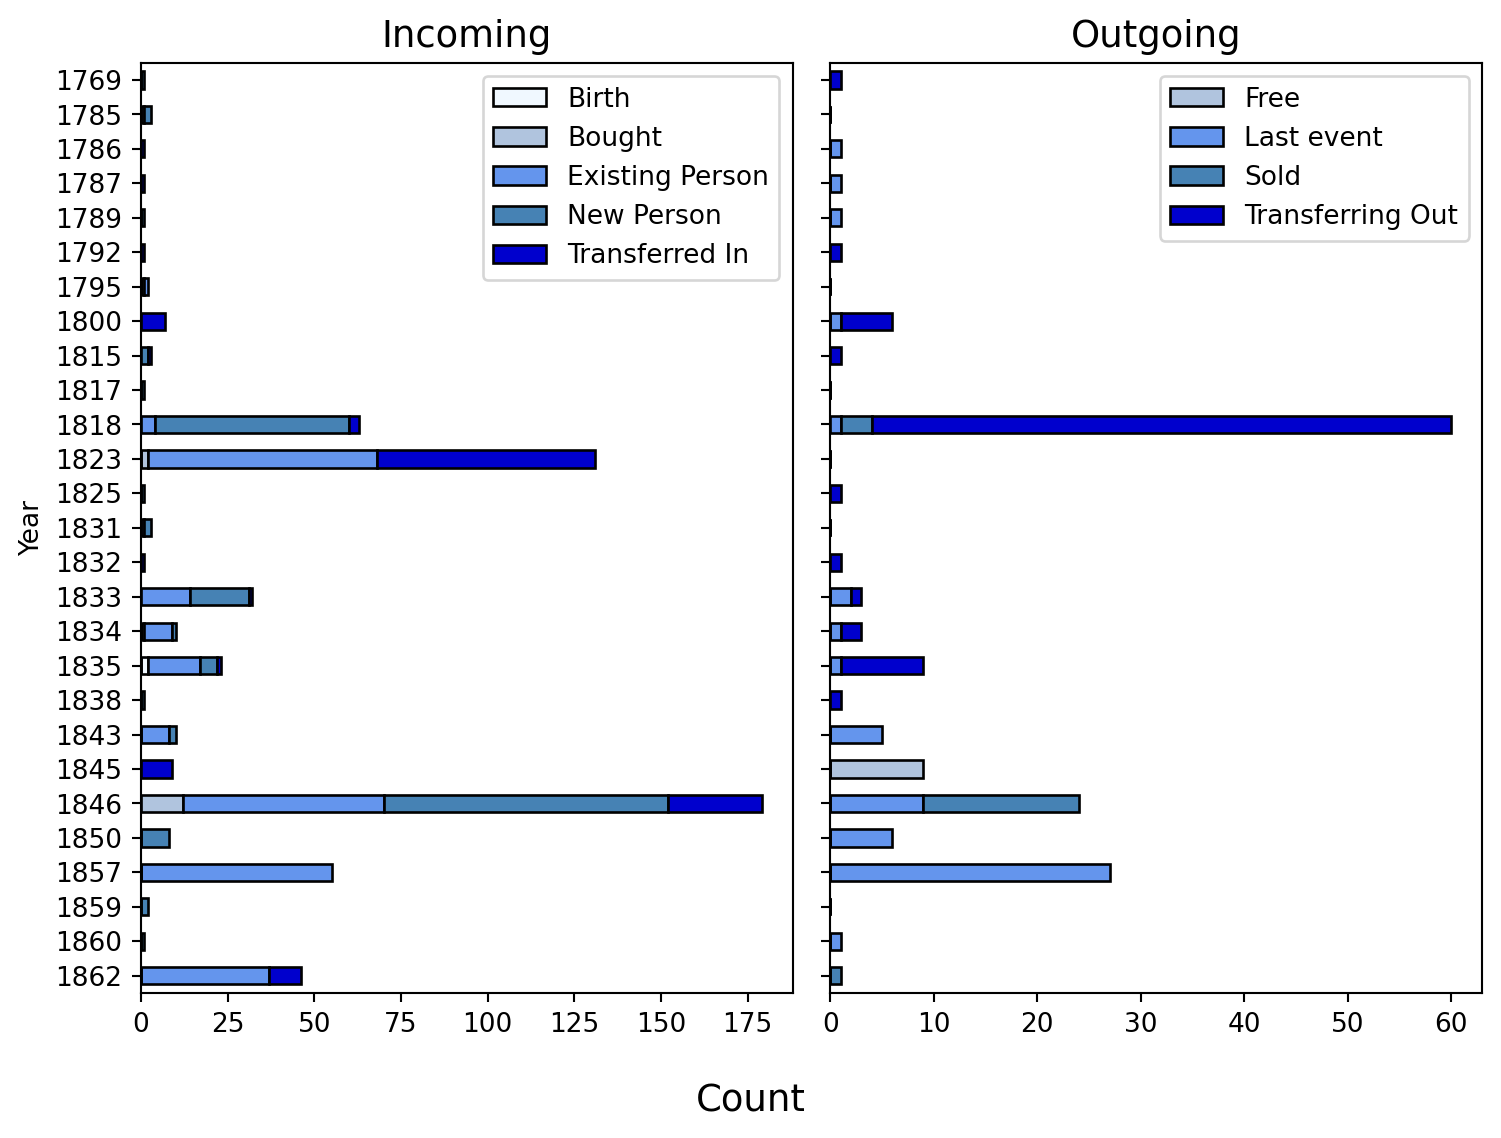

In [299]:
df= SJ.copy()

a= df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = df.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')
c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).first().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 6)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [300]:
df= SJ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)

c


total  Birth  Bought  Existing Person  New Person  Transferred In
Year                                                                     
1770.0      1    0.0     0.0              0.0         1.0             0.0
1785.0      4    0.0     0.0              0.0         2.0             2.0
1790.0      2    0.0     0.0              0.0         1.0             1.0
1795.0      1    0.0     1.0              0.0         0.0             0.0
1800.0      7    0.0     0.0              0.0         0.0             7.0
1815.0      3    0.0     0.0              0.0         3.0             0.0
1820.0     61    0.0     0.0              3.0        56.0             2.0
1825.0     68    0.0     2.0              2.0         1.0            63.0
1830.0      3    0.0     0.0              0.0         2.0             1.0
1835.0     34    3.0     0.0              7.0        23.0             1.0
1840.0      1    0.0     0.0              0.0         1.0             0.0
1845.0    109    0.0     0.0              6.0        75.0            28.0
1850.0      8    0.0     0.0              0.0         8.0             0.0
1855.0     55    0.0     0.0             55.0         0.0             0.0
1860.0     38    0.0     0.0             35.0         3.0             0.0

In [301]:
f

total  Last event  None  Sold  Transferring Out
Year                                                   
1770.0      1         0.0   0.0   0.0               1.0
1785.0      4         2.0   1.0   0.0               1.0
1790.0      2         1.0   0.0   0.0               1.0
1795.0      1         0.0   0.0   0.0               1.0
1800.0      7         1.0   1.0   0.0               5.0
1815.0      3         0.0   3.0   0.0               0.0
1820.0     61         2.0   1.0   3.0              55.0
1825.0     68        59.0   4.0   0.0               5.0
1830.0      3         0.0   2.0   0.0               1.0
1835.0     34         7.0   6.0   0.0              21.0
1840.0      1         0.0   0.0   0.0               1.0
1845.0    109        38.0  60.0  11.0               0.0
1850.0      8         6.0   2.0   0.0               0.0
1855.0     55        27.0  28.0   0.0               0.0
1860.0     38        10.0   0.0  25.0               3.0

### Enslaved by Enslaver and Year at Soldier's Joy

In [303]:
df= SJ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1770.0 1342.0           1
1785.0 272.0            4
1790.0 272.0            2
1795.0 272.0            1
1800.0 272.0            7
1815.0 272.0            2
       1065.0           2
1820.0 272.0           61
       1065.0           1
1825.0 1065.0          68
1830.0 1065.0           3
1835.0 1065.0          34
1840.0 1065.0           1
1845.0 1065.0           8
       1088.0         100
1850.0 1088.0           2
1855.0 1088.0          55
1860.0 1088.0          37
       1275.0           3
       1277.0           1
       1278.0           5

In [304]:
df= SJ.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1770 1342.0           1
1780 272.0            2
1790 272.0            4
1800 272.0            8
1820 272.0           62
     1065.0          69
1830 1065.0          26
1840 1065.0          25
1850 1088.0         102
1860 1088.0          64
     1275.0           3
     1277.0           1
     1278.0           5

#### Montezuma

In [306]:
df = test[test['Place']=="Montezuma"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
MZenslavers=[265,271,280,283,677,1034,1320]
MZ =test[test['RN'].isin(people)]

MZ =MZ[MZ['Enslaver ID'].isin(MZenslavers)]


85


In [307]:
MZ['Enslaver ID'].value_counts()

Enslaver ID
271.0     103
1034.0     91
283.0      72
280.0      58
1320.0     43
677.0       5
265.0       4
Name: count, dtype: int64

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


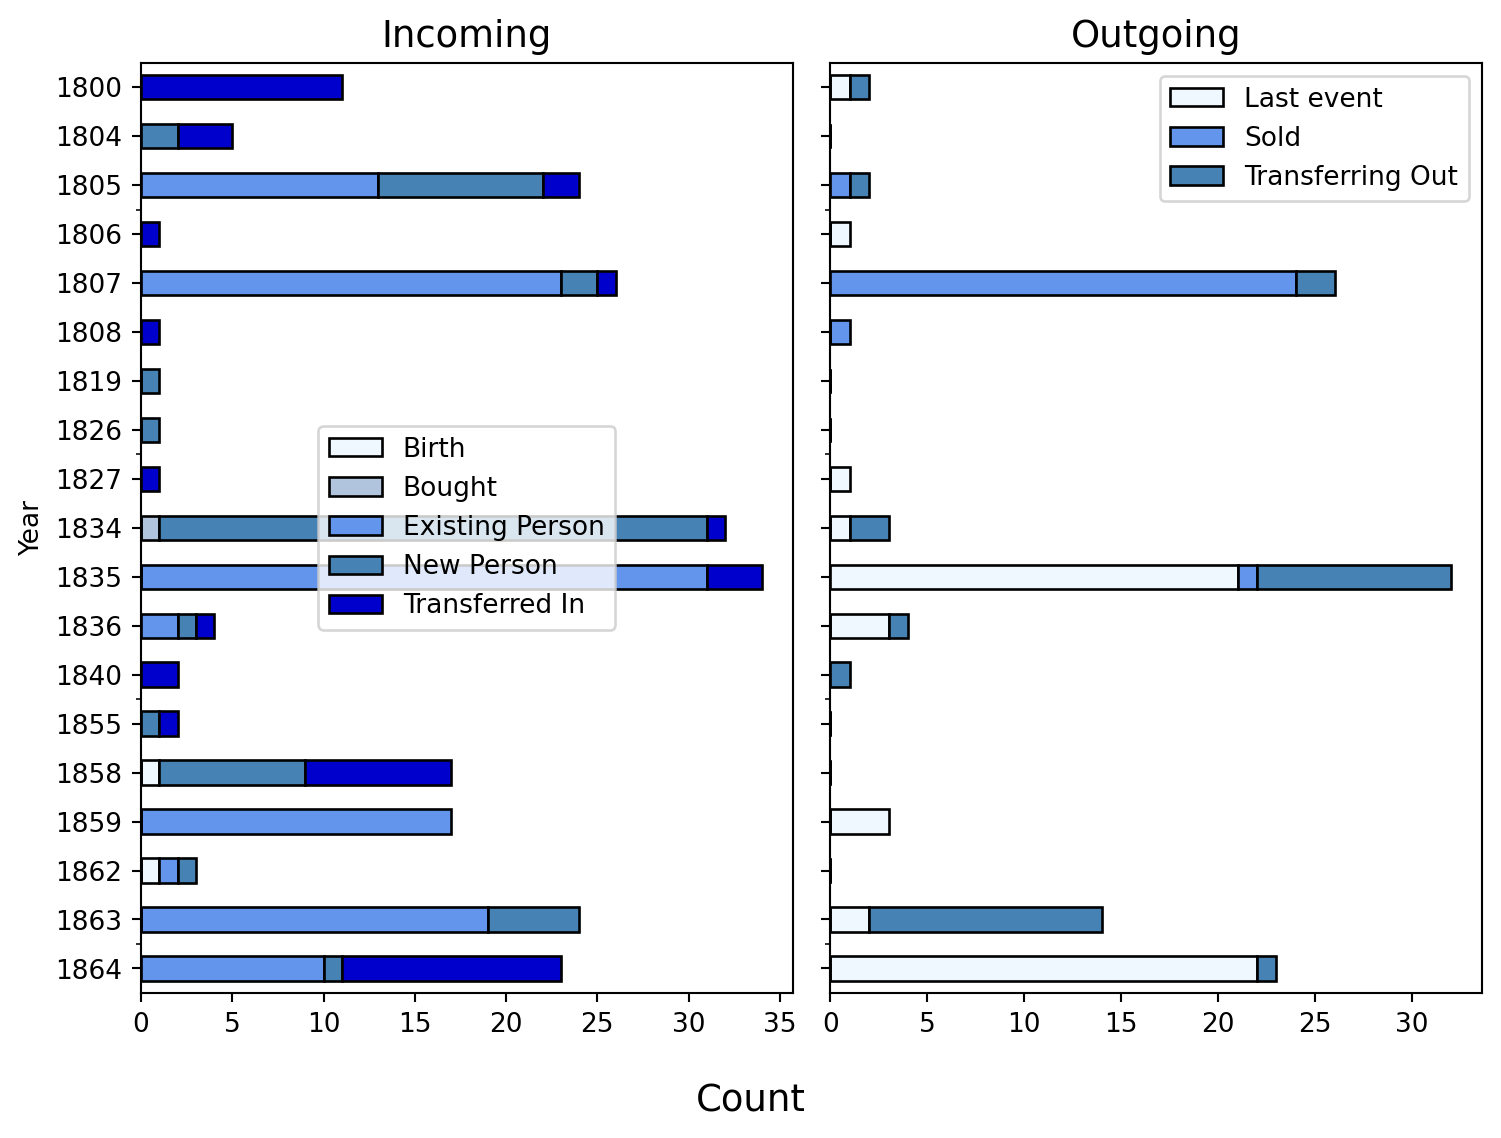

In [308]:
df= MZ.copy()
#df['Year'] = ((df['Year']*2).round(-1)/2).astype(int)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 6)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [309]:
df= MZ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

total  Birth  Bought  Existing Person  New Person  Transferred In
Year                                                                     
1800.0     11    0.0     0.0              0.0         0.0            11.0
1805.0     28    0.0     0.0              9.0        13.0             6.0
1810.0      1    0.0     0.0              0.0         0.0             1.0
1820.0      1    0.0     0.0              0.0         1.0             0.0
1825.0      2    0.0     0.0              0.0         1.0             1.0
1835.0     36    0.0     1.0              2.0        31.0             2.0
1840.0      2    0.0     0.0              0.0         0.0             2.0
1855.0      2    0.0     0.0              0.0         1.0             1.0
1860.0     21    2.0     0.0              2.0         9.0             8.0
1865.0     25    0.0     0.0             19.0         6.0             0.0

In [310]:
f

total  Last event  None  Sold  Transferring Out
Year                                                   
1800.0     11         1.0   9.0   0.0               1.0
1805.0     28         1.0   0.0  25.0               2.0
1810.0      1         0.0   0.0   1.0               0.0
1820.0      1         0.0   1.0   0.0               0.0
1825.0      2         1.0   1.0   0.0               0.0
1835.0     36        25.0   0.0   1.0              10.0
1840.0      2         0.0   1.0   0.0               1.0
1855.0      2         0.0   2.0   0.0               0.0
1860.0     21         3.0  18.0   0.0               0.0
1865.0     25        24.0   0.0   0.0               1.0

### Enslaved by Enslaver and Year at Montezuma

In [312]:
df= MZ.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1800.0 265.0            1
       271.0           10
1805.0 265.0            1
       271.0           28
1810.0 265.0            1
1820.0 283.0            1
1825.0 283.0            2
1835.0 265.0            1
       280.0           28
       283.0           34
       677.0            2
1840.0 1034.0           2
1855.0 1034.0           2
1860.0 1034.0          21
1865.0 280.0            4
       677.0            3
       1034.0          24
       1320.0          22

In [313]:
df= MZ.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1800 265.0            1
     271.0           25
1810 265.0            2
     271.0           26
1820 283.0            1
1830 265.0            1
     283.0           33
1840 280.0           28
     283.0           32
     677.0            2
     1034.0           2
1860 280.0            4
     677.0            3
     1034.0          27
     1320.0          22

#### Norwood

In [315]:
df = test[test['Place']=="Norwood"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))

NWenslavers=[857]
NW =test[test['RN'].isin(people)]
NW =test[test['Enslaver ID'].isin(NWenslavers)]


63


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


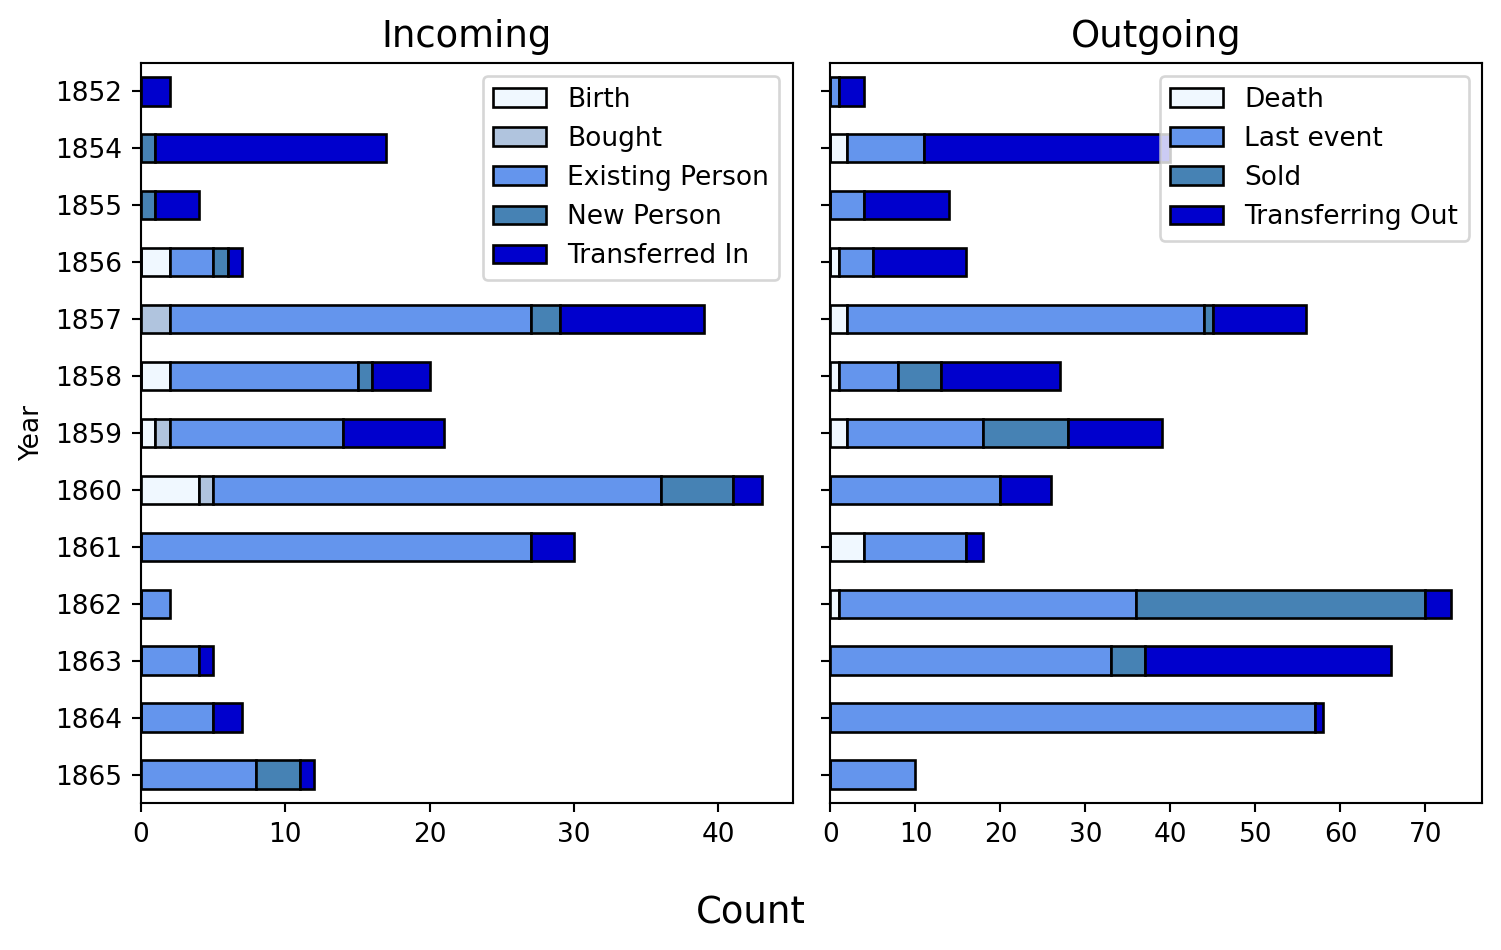

In [316]:
df= NW.copy()
a= df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')
c = a.join(b).fillna(0)

e = test.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None','Free'})

plt.rcParams["figure.figsize"] = (8, 5)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'steelblue','mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [317]:
df= NW.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

total  Birth  Bought  Existing Person  New Person  Transferred In
Year                                                                     
1850.0      2    0.0     0.0              0.0         0.0             2.0
1855.0     32    2.0     2.0              0.0         5.0            23.0
1860.0     51    7.0     2.0             22.0         6.0            14.0
1865.0     18    0.0     0.0             12.0         3.0             3.0

In [318]:
f

total  Death  Last event  None  Sold  Transferring Out
Year                                                          
1850.0      2    0.0         0.0   0.0   0.0               2.0
1855.0     32    0.0         3.0  22.0   1.0               6.0
1860.0     51    4.0        28.0  12.0   0.0               7.0
1865.0     18    0.0        18.0   0.0   0.0               0.0

### Enslaved by Enslaver by Year at Norwood

In [320]:
df= NW.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1850.0 857.0            2
1855.0 857.0           32
1860.0 857.0           51
1865.0 857.0           18

In [321]:
df= NW.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1850 857.0           17
1860 857.0           64

#### Colleton

In [323]:
df = test[test['Place']=="Colleton"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))

CT =test[test['RN'].isin(people)]
CT = CT[CT['Enslaver ID'] != 46]
CT = CT[CT['Enslaver ID'] != 45]
CT= CT.loc[(CT['Year'].between(1760, 1801)) | (CT['Year']>1850)]


130


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


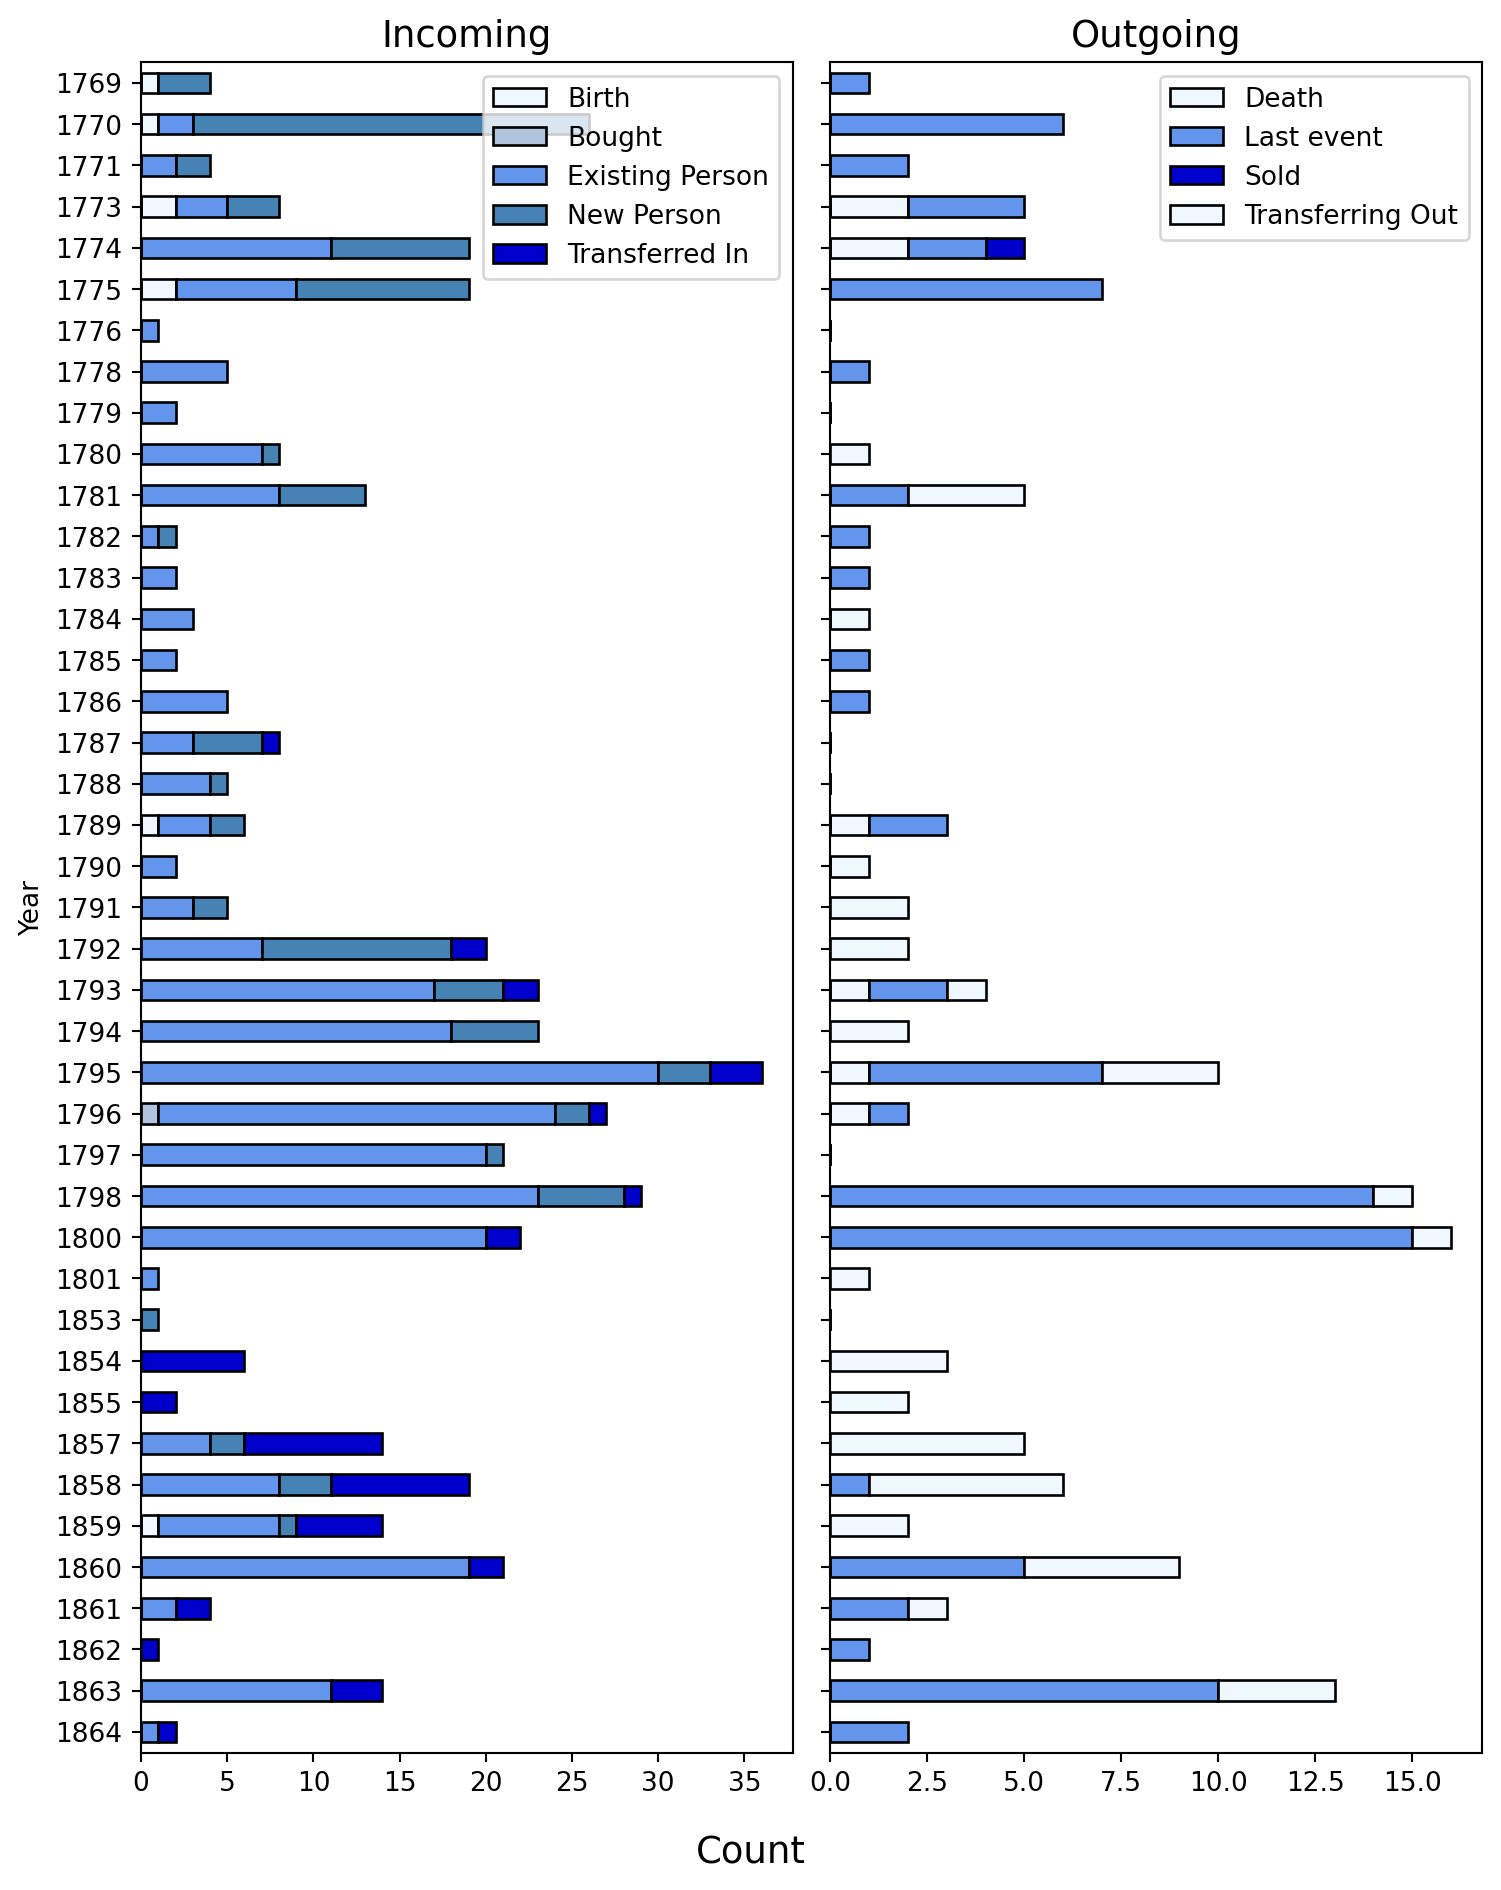

In [324]:
df= CT.copy()
#df['Year'] = ((df['Year']*2).round(-1)/2).astype(int)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

plt.rcParams["figure.figsize"] = (8, 10)
fig, (ax, ax2) = plt.subplots(ncols=2, sharey=True)
color = ['aliceblue', 'lightsteelblue', 'cornflowerblue', 'steelblue','mediumblue']
color2 = ['aliceblue',  'cornflowerblue', 'mediumblue']
ax.set_title('Incoming', fontsize=14)
ax2.set_title('Outgoing', fontsize=14)

d.plot.barh(stacked=True, color= color, edgecolor='black', ax=ax)
plt.legend(loc='best')
plt.gca().invert_yaxis()

g.plot.barh(stacked=True, color= color2, edgecolor='black', ax=ax2)
plt.gca().invert_yaxis()
plt.legend(loc='best')
fig.supxlabel('Count', fontsize=14)

plt.tight_layout()
plt.show()

In [325]:
df= CT.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
a = df.groupby(['Year'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})
b = df.groupby(['RN','Year']).first().reset_index()
b = b.groupby(['Year','IN'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='IN', values='RN').reset_index().sort_values('Year').set_index('Year')

c = a.join(b).fillna(0)

e = df.groupby(['RN','Year']).last().reset_index()
e = e.groupby(['Year','OUT'])['RN'].nunique().to_frame().reset_index().pivot(index=['Year'], columns='OUT', values='RN').reset_index().fillna(0).set_index('Year')
f = a.join(e)
f.head(10)

d= c.drop(columns={'total'})
g = f.drop(columns={'total', 'None'})

c

total  Birth  Existing Person  New Person  Transferred In
Year                                                             
1770.0     30    2.0              0.0        28.0             0.0
1775.0     40    4.0             15.0        21.0             0.0
1780.0     22    0.0             15.0         7.0             0.0
1785.0     16    0.0             11.0         4.0             1.0
1790.0     32    1.0             14.0        16.0             1.0
1795.0     49    0.0             30.0        15.0             4.0
1800.0     46    0.0             38.0         5.0             3.0
1855.0     14    0.0              0.0         3.0            11.0
1860.0     23    1.0              9.0         4.0             9.0
1865.0     15    0.0             11.0         0.0             4.0

In [326]:
f

total  Death  Last event  None  Sold  Transferring Out
Year                                                          
1770.0     30    0.0         9.0  21.0   0.0               0.0
1775.0     40    4.0        12.0  23.0   1.0               0.0
1780.0     22    0.0         4.0  14.0   0.0               4.0
1785.0     16    1.0         3.0  12.0   0.0               0.0
1790.0     32    2.0         2.0  25.0   0.0               3.0
1795.0     49    3.0         9.0  34.0   0.0               3.0
1800.0     46    0.0        29.0  14.0   0.0               3.0
1855.0     14    0.0         0.0   9.0   0.0               5.0
1860.0     23    0.0         9.0  11.0   0.0               3.0
1865.0     15    0.0        12.0   0.0   0.0               3.0

### Enslaved by Enslaver by Year at Colleton

In [328]:
df= CT.copy()
df['Year'] = ((df['Year']*2).round(-1)/2)
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1770.0 43.0            30
       1342.0           1
1775.0 43.0            40
1780.0 43.0            20
       44.0             5
1785.0 43.0            12
       44.0             5
       272.0            1
       1174.0           1
1790.0 43.0            13
       44.0            20
       131.0            1
       137.0            1
       142.0            1
1795.0 43.0            14
       44.0            37
       187.0            1
1800.0 43.0            20
       44.0            26
       262.0            1
       269.0            2
       271.0            3
       272.0            2
1855.0 216.0            4
       857.0            6
       858.0            9
       866.0            2
1860.0 216.0            3
       857.0            7
       858.0           21
       919.0            1
1865.0 857.0            2
       858.0           14

In [329]:
df= CT.copy()
df['Year'] = (df['Year'].round(-1))
df.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year Enslaver ID       
1770 43.0            43
     1342.0           1
1780 43.0            36
     44.0             5
1790 43.0            20
     44.0            30
     131.0            1
     137.0            1
     142.0            1
     187.0            1
     272.0            1
     1174.0           1
1800 43.0            26
     44.0            35
     262.0            1
     269.0            2
     271.0            3
     272.0            2
1850 216.0            1
     857.0            4
     866.0            2
1860 216.0            4
     857.0           11
     858.0           24
     919.0            1

In [330]:
RK = test[test['Place']=="Rock Cliff"]
RK = RK[RK['Enslaver ID'] != 46]
RK = RK[RK['Enslaver ID'] != 45]
RK['Year'] = ((RK['Year']*2).round(-1)/2)
RK.groupby(['Year','Enslaver ID'])['RN'].nunique().to_frame().rename(columns={'RN':'total'})

total
Year   Enslaver ID       
1860.0 919.0            1
1865.0 919.0            2

### Events by Source and Plantation

#### Combine all non-plantation locations into one group

In [333]:
plantations = ['Colleton','Montezuma','Norwood',"Soldier's Joy",'Union Hill']

#### Create look up of Source number with source type

In [335]:
journals = [1,2,3,4,5,6,7,8,11,12,13,14,16,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,56,58]
court = [15,18,19,20,21,23,24,25,26,27,28,29,57,61,66,67,68,72]
adv= [9,10,22,65,70,71]
chancery = [17,69,74]
rolls = [52,59,60,62,63,64,73]
FB = [53,55]


### Look at number of events by source type and plantation

In [337]:
df= enslaved[enslaved['Event Type'] !='Enslaved']
df = df[['Place','Source','Event Type']]
df['Place'] = df['Place'].where(df['Place'].isin(plantations),'other') 
print(df.shape)
df['Source'] = df['Source'].astype(float)
df= df.drop_duplicates().sort_values('Source').dropna()
print(df.shape)
#add column for source type
df['Type'] = 'other'
df['Type'] = df['Type'].where(~df['Source'].isin(journals),'journal') 
df['Type'] = df['Type'].where(~df['Source'].isin(court),'court') 
df['Type'] = df['Type'].where(~df['Source'].isin(adv),'adv') 
df['Type'] = df['Type'].where(~df['Source'].isin(chancery),'chancery') 
df['Type'] = df['Type'].where(~df['Source'].isin(rolls),'rolls') 
df['Type'] = df['Type'].where(~df['Source'].isin(FB),'Freedman') 
print(df['Type'].value_counts())
df.head()

(2666, 3)
(244, 3)
Type
journal     192
court        22
rolls        13
adv           6
Freedman      6
chancery      4
other         1
Name: count, dtype: int64


Place  Source   Event Type     Type
1453  Colleton     1.0  Necessities  journal
1680  Colleton     1.0  Disappeared  journal
1583  Colleton     1.0     Transfer  journal
1525  Colleton     1.0        Birth  journal
1409  Colleton     2.0  Necessities  journal

In [338]:
a = df.groupby(['Place','Type'])['Event Type'].nunique().reset_index().sort_values(['Place','Type']).set_index(['Place','Type'])

#### Look at number of persons identified by source type and location


In [340]:
df= enslaved[enslaved['Event Type'] !='Enslaved']
df = df[['Place','Source','RN']]
df['Place'] = df['Place'].where(df['Place'].isin(plantations),'other') 
print(df.shape)
df['Source'] = df['Source'].astype(float)
df= df.drop_duplicates().sort_values('Source').dropna()
print(df.shape)
#add column for source type
df['Type'] = 'other'
df['Type'] = df['Type'].where(~df['Source'].isin(journals),'journal') 
df['Type'] = df['Type'].where(~df['Source'].isin(court),'court') 
df['Type'] = df['Type'].where(~df['Source'].isin(adv),'adv') 
df['Type'] = df['Type'].where(~df['Source'].isin(chancery),'chancery') 
df['Type'] = df['Type'].where(~df['Source'].isin(rolls),'rolls') 
df['Type'] = df['Type'].where(~df['Source'].isin(FB),'Freedman') 
print(df['Type'].value_counts())
df.head()

(2666, 3)
(1787, 3)
Type
journal     1070
court        395
rolls        109
chancery      90
adv           85
Freedman      37
other          1
Name: count, dtype: int64


Place  Source  RN     Type
1632  Colleton     1.0  15  journal
1453  Colleton     1.0  17  journal
1672  Colleton     1.0   7  journal
1675  Colleton     1.0   6  journal
1631  Colleton     1.0  14  journal

In [341]:
b = df.groupby(['Place','Type'])['RN'].nunique().reset_index().sort_values(['Place','Type']).set_index(['Place','Type']).rename(columns={'RN':'People'})

In [342]:
c= a.join(b)
c

Event Type  People
Place         Type                        
Colleton      adv                1       2
              journal           17     117
              rolls              1      16
Montezuma     Freedman           1       4
              adv                2      47
              chancery           1      23
              court              3      71
              journal            2      23
              rolls              2       5
Norwood       Freedman           1       6
              journal           15      56
              rolls              3      20
Soldier's Joy Freedman           1       4
              adv                2      36
              chancery           2      64
              court              3      79
              journal            8      87
Union Hill    Freedman           1      16
              court              2     111
              journal           20     327
              other              1       1
              rolls              1      19
other         Freedman           2       7
              chancery           1       3
              court              4      30
              journal            6      42
              rolls              2      41

# Final Steps 

### Remove EVE-ENS-090 where the enslaver is not known

In [345]:
print(enslaved.shape)
enslaved = enslaved[enslaved['Event ID'] != 'EVE-ENS-090']
print(enslaved.shape)

(3913, 28)
(3887, 28)


##### List of people that could be buried at Union hill cemetery

In [347]:
#enslaver is William Cabell Sr., William Cabell, Jr., Joseph CArrington Cabell Jr., Mayo CAbell or William Daniel Cabell
UH = ['Union Hill','Colleton','Norwood']
UHcemetery=enslaved[enslaved['Place'].isin(UH)]
UHcemetery[UHcemetery['Status']== 'Enslaved']
print(UHcemetery.shape)
UHcemetery = UHcemetery[['RN','Given Name','Alternate Name','Surname','Sex','Birth date','Death date']]
print(UHcemetery.shape)
UHcemetery['RN']= UHcemetery['RN'].astype(int)
UHcemetery= UHcemetery.drop_duplicates().sort_values('RN')
print(UHcemetery.shape)


(2436, 28)
(2436, 7)
(473, 7)


## Save final file to CSV. Drop duplicate columns used for analytics ('Year' and 'Birthdate')

In [349]:
enslaved = enslaved[['Person','Given Name','Alternate Name','Surname','Sex','RN','Birth date','Death date','Father','Mother','Spouses','Children','Event ID','Event Type','Place','Status','Role','Enslaver ID','Date','Description','Overseers','Source Description','Page','Repository']]
print(enslaved.shape)
enslaved.head(2)

(3887, 24)


Person Given Name Alternate Name Surname Sex   RN Birth date  \
26  PERS-CAB-661-UH     Sophia          Sophy     NaN   F  661   abt 1805   
27  PERS-CAB-670-UH   Margaret            NaN     NaN   F  670   abt 1810   

   Death date Father           Mother          Spouses  \
26        NaN    NaN              NaN  PERS-CAB-647-UH   
27        NaN    NaN  PERS-CAB-668-UH              NaN   

                           Children     Event ID Event Type      Place  \
26  PERS-CAB-662-UH,PERS-CAB-663-UH  EVE-AUC-002    Auction  Montezuma   
27                              NaN  EVE-ENS-013   Enslaved  Montezuma   

      Status              Role       Enslaver ID        Date  \
26  Enslaved  Auctioned person  PERS-CAB-1034-UH  1863-09-18   
27  Enslaved   Enslaved Person  PERS-CAB-1034-UH        1858   

                                          Description Overseers  \
26  Valuable Lands for Sale. September, 1863, at p...       NaN   
27                 Enslaved by James Bruce McClelland       NaN   

                                   Source Description Page  \
26  “Valuable Lands for Sale,” Richmond Times Disp...  NaN   
27                                                NaN  NaN   

                                     Repository  
26  Newspapers.com (https://www.newspapers.com)  
27                                          NaN

### Drop columns without sources (Enslaved events used for data analysis)

In [351]:
print("The percent complete each field is")
enslaved.notnull().sum()/len(enslaved) * 100

The percent complete each field is


Person                100.000000
Given Name            100.000000
Alternate Name         11.474145
Surname                27.347569
Sex                   100.000000
RN                    100.000000
Birth date            100.000000
Death date              9.055827
Father                 21.070234
Mother                 31.592488
Spouses                28.891176
Children               28.273733
Event ID               97.170054
Event Type             97.170054
Place                  97.144327
Status                100.000000
Role                   97.170054
Enslaver ID            95.472086
Date                   97.170054
Description            97.170054
Overseers              62.387445
Source Description     74.633393
Page                   44.147157
Repository             72.858245
dtype: float64

In [353]:
enslaved = enslaved.dropna(subset=['Source Description'])
print(enslaved['RN'].nunique())
enslaved.head(2)

818


Person Given Name Alternate Name   Surname Sex   RN Birth date  \
26  PERS-CAB-661-UH     Sophia          Sophy       NaN   F  661   abt 1805   
28  PERS-CAB-663-UH     Sawney            NaN  Jemmeson   M  663   abt 1832   

   Death date           Father           Mother           Spouses  \
26        NaN              NaN              NaN   PERS-CAB-647-UH   
28        NaN  PERS-CAB-647-UH  PERS-CAB-661-UH  PERS-CAB-1032-UH   

                                             Children     Event ID Event Type  \
26                    PERS-CAB-662-UH,PERS-CAB-663-UH  EVE-AUC-002    Auction   
28  PERS-CAB-1335-UH,PERS-CAB-1336-UH,PERS-CAB-133...  EVE-CRT-001      Court   

        Place    Status              Role       Enslaver ID        Date  \
26  Montezuma  Enslaved  Auctioned person  PERS-CAB-1034-UH  1863-09-18   
28  Montezuma  Enslaved     Listed Person  PERS-CAB-1034-UH  1859-11-15   

                                          Description Overseers  \
26  Valuable Lands for Sale. September, 1863, at p...       NaN   
28  James B. McClelland doth grant unto the said J...       NaN   

                                   Source Description Page  \
26  “Valuable Lands for Sale,” Richmond Times Disp...  NaN   
28  Deed of Trust for Benvenue Estate.Nelson Count...  137   

                                      Repository  
26   Newspapers.com (https://www.newspapers.com)  
28  Nelson County Circuit Court, Lovingston, Va.

In [352]:
enslaved['RN'].nunique()

820

In [583]:
enslaved.groupby(['Status','Sex'])['RN'].nunique().to_frame().reset_index()

Status Sex   RN
0  Enslaved   ?   18
1  Enslaved   F  291
2  Enslaved   M  352
3  Enslaver   F   29
4  Enslaver   M   80
5      Free   F   22
6      Free   M   71

In [354]:
print("The percent complete each field is")
enslaved.notnull().sum()/len(enslaved) * 100

The percent complete each field is


Person                100.000000
Given Name            100.000000
Alternate Name         11.754567
Surname                32.126853
Sex                   100.000000
RN                    100.000000
Birth date            100.000000
Death date             10.410203
Father                 23.164426
Mother                 32.781799
Spouses                33.505688
Children               31.092727
Event ID               96.242675
Event Type             96.242675
Place                  96.208204
Status                100.000000
Role                   96.242675
Enslaver ID            93.967597
Date                   96.242675
Description            96.242675
Overseers              65.804895
Source Description    100.000000
Page                   59.152017
Repository             97.621510
dtype: float64

In [579]:
enslaved['Event ID'].nunique()

656

In [581]:
enslaved['RN'].nunique()

818

In [355]:
enslaved.to_csv("ExportUHEnslavedFull.txt", sep='\t', index=False, header=True)

# DONE

In [593]:
df = enslaved[enslaved['Place']=="Montezuma"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
print(df['Event ID'].nunique())

83
26


In [595]:
df = enslaved[enslaved['Place']=="Union Hill"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
print(df['Event ID'].nunique())

387
281


In [597]:
df = enslaved[enslaved['Place']=="Norwood"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
print(df['Event ID'].nunique())

63
91


In [599]:
df = enslaved[enslaved['Place']=="Colleton"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
print(df['Event ID'].nunique())

121
90


In [601]:
df = enslaved[enslaved['Place']=="Soldier's Joy"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
print(df['Event ID'].nunique())

186
68


In [603]:
df = enslaved[enslaved['Place']=="Rock Cliff"]
people = df['RN'].drop_duplicates().tolist()
print(len(people))
print(df['Event ID'].nunique())

3
2
